Frame enumuration and submission to Hyp3 with Tropo, Iono, SET corrections.

In [1]:
from s1_frame_enumerator import (get_s1_stack, 
                                 filter_s1_stack_by_geometric_coverage_per_pass, 
                                 get_global_s1_frames, 
                                 get_overlapping_s1_frames, 
                                 enumerate_dates, 
                                 frames2gdf, 
                                 enumerate_gunw_time_series,
                                 gdf2frames)
from shapely.geometry import Point
import geopandas as gpd
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import warnings
import json
import pandas as pd
import datetime
from tqdm import tqdm
from pathlib import Path
from itertools import starmap
import yaml

# Paramaters

In [2]:
YAML_FILE = 'enumeration_parameters.yml'

In [3]:
with open(YAML_FILE) as f:
    enum_params = yaml.safe_load(f)['enumeration_parameters']

# Load Parameters

In [4]:
# AOI Name
AOI_NAME = enum_params['aoi_name']
STACK_DIR = enum_params['stack_directory']
ENUM_DIR = enum_params['enum_directory']

# Hyp3 Paramaters
TEMPORAL_BASELINES_DAYS = enum_params['min_temporal_baseline_days']
NEIGHBORS = enum_params['neighbors']
IONOSPHERE = True
SET = True
WEATHER_MODEL = 'HRRR'

# Notebook Parameters
RECOMPUTE_STACKS = False

In [5]:
STACK_DIR, ENUM_DIR, TEMPORAL_BASELINES_DAYS, NEIGHBORS, WEATHER_MODEL, AOI_NAME, 

('out/stack/mainland_us_coast_thru_202305',
 'out/enum/mainland_us_coast_thru_202305',
 [0, 180, 365],
 2,
 'HRRR',
 'mainland_us_coast')

In [6]:
stack_dir = Path(STACK_DIR)
stack_dir.mkdir(exist_ok=True, parents=True)

enum_dir = Path(ENUM_DIR)
enum_dir.mkdir(exist_ok=True, parents=True)

# Load AOI

<Axes: >

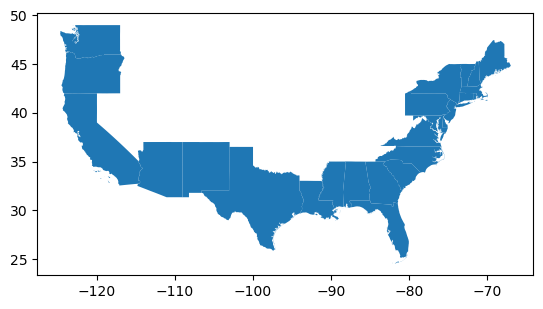

In [7]:
df_coastal_us = gpd.read_file(f'AOIs/{AOI_NAME}.geojson')
# This ensures we only get the mainland part
df_coastal_us.plot()

# Get Frames overlapping AOI

In [8]:
aoi_geo = df_coastal_us.geometry.unary_union
frames = get_overlapping_s1_frames(aoi_geo)
df_frames_all = frames2gdf(frames)
df_frames_all.head()

,frame_id,hemisphere,track_number_min,track_number_max,geometry
0,491,west,4,4,"POLYGON Z ((-77.55802 33.30969 0.00000, -77.71..."
1,492,west,4,4,"POLYGON Z ((-77.82534 34.47332 0.00000, -78.06..."
2,493,west,4,4,"POLYGON Z ((-78.09591 35.63539 0.00000, -78.33..."
3,494,west,4,4,"POLYGON Z ((-78.37797 36.81111 0.00000, -78.41..."
4,495,west,4,4,"POLYGON Z ((-78.65322 37.95742 0.00000, -78.73..."


Let's remove frames that have less than 25% overlap with our AOI. This ensures ISCE2 will have roughly enough area to process.

In [9]:
intersection_geo = df_frames_all.geometry.intersection(aoi_geo)
with warnings.catch_warnings():
    # yes, we are computing areas in lat/lon - that's ok at these latitudes
    warnings.simplefilter("ignore", category=UserWarning)
    percent_overlap = intersection_geo.area / df_frames_all.geometry.area
df_frames = df_frames_all[percent_overlap >= .2].reset_index(drop=True)
df_frames = df_frames.explode()
frames = gdf2frames(df_frames)

/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_82449/3762525945.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  df_frames = df_frames.explode()


(23.70927522851776, 50.61472809039068)

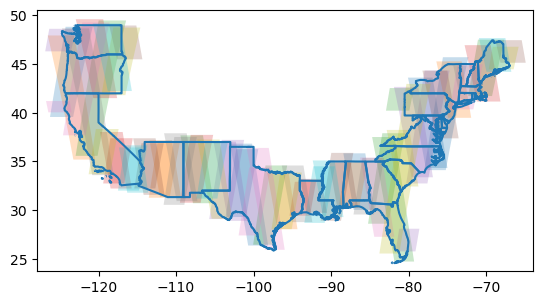

In [10]:
fig, ax = plt.subplots()
df_coastal_us.geometry.boundary.plot(ax=ax)
df_frames_by_track = df_frames.dissolve(by='track_number_min').reset_index(drop=False)
df_frames_by_track.plot(ax=ax, 
                        column='track_number_min',
                        categorical=True,
                        alpha=.25, 
                        #legend=True
                       )
xmin, ymin, xmax, ymax = df_frames_by_track.total_bounds
ax.set_xlim(xmin - 1, xmax + 1)
ax.set_ylim(ymin - 1, ymax + 1)

# Get Stack from Frame

If `RECOMPUTE_STACKS` is True, then will overwrite existing stack

In [11]:
all_tracks = df_frames.track_number_min.unique().tolist()

In [12]:
def id_formatter(row: pd.Series):
    """Returns 'track<track_number>' for first instance and then 'track<track_number>_k' for each subsequent k index"""
    if row['level_1']:
        return f"track{row['track_number_min']}_{row['level_1']}"
    else:
        return f"track{row['track_number_min']}"

df_track_aois = df_frames_by_track.explode().reset_index(drop=False)
df_track_aois['track_aoi_id'] = df_track_aois.apply(id_formatter, axis=1)
df_track_aois.head()

/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_82449/2628663778.py:8: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  df_track_aois = df_frames_by_track.explode().reset_index(drop=False)


,level_0,level_1,track_number_min,frame_id,hemisphere,track_number_max,geometry,track_aoi_id
0,0,0,4,492,west,4,"POLYGON Z ((-78.06076 35.48755 0.00000, -78.06...",track4
1,1,0,5,649,west,5,"POLYGON Z ((-100.95129 27.52268 0.00000, -100....",track5
2,2,0,11,1624,west,11,"POLYGON Z ((-77.75658 35.26745 0.00000, -77.75...",track11
3,3,0,12,1798,west,12,"POLYGON Z ((-103.39264 30.44650 0.00000, -103....",track12
4,4,0,13,1924,west,13,"POLYGON Z ((-126.01699 40.73057 0.00000, -126....",track13


In [13]:
track2frames = {row['track_aoi_id']: [f for f in frames 
                                      if row['track_number_min'] in f.track_numbers 
                                      if row['geometry'].intersects(f.frame_geometry)
                       ] 
                for _, row in df_track_aois.iterrows()}
track2frames['track4']

[S1Frame(frame_id=492, hemisphere='west', track_numbers=[4], frame_geometry=<POLYGON Z ((-77.825 34.473 0, -78.064 35.483 0, -78.06 35.484 0, -78.061 35...>, footprint_geometry=<POLYGON ((-77.744 34.126, -78.064 35.483, -78.06 35.484, -78.099 35.65, -77...>),
 S1Frame(frame_id=493, hemisphere='west', track_numbers=[4], frame_geometry=<POLYGON Z ((-78.096 35.635 0, -78.339 36.651 0, -75.472 36.651 0, -75.298 3...>, footprint_geometry=<POLYGON ((-75.238 35.485, -75.2 35.298, -76.07 35.183, -76.093 35.292, -76....>),
 S1Frame(frame_id=494, hemisphere='west', track_numbers=[4], frame_geometry=<POLYGON Z ((-78.378 36.811 0, -78.414 36.977 0, -78.618 37.813 0, -75.706 3...>, footprint_geometry=<POLYGON ((-77.308 36.32, -77.368 36.585, -78.291 36.45, -78.378 36.811, -78...>),
 S1Frame(frame_id=495, hemisphere='west', track_numbers=[4], frame_geometry=<POLYGON Z ((-78.653 37.957 0, -78.739 38.304 0, -78.734 38.305 0, -78.901 3...>, footprint_geometry=<POLYGON ((-77.57 37.482, -77.632 37.746, -

In [15]:
track_log = tqdm(total=0, position=0, bar_format='{desc}')

def get_s1_stack_and_serialize(track_aoi_id, frames, recompute_stack=RECOMPUTE_STACKS):
    if not frames:
        warnings.warn('No frames submitted')
        return
    track_stack_path = stack_dir / f'{track_aoi_id}-{AOI_NAME}.geojson'
    track_log.set_description_str(f'Current track: {track_stack_path}')
    if track_stack_path.exists() and (not recompute_stack):
        return track_stack_path
    df_stack = get_s1_stack(frames, minimum_coverage_ratio_per_frame=.2, minimum_coverage_ratio_per_pass=.8)
    if df_stack.empty:
        warnings.warn(f'Empty stack - still writing for records - check {track_aoi_id} on asf_search')
    df_stack.to_file(track_stack_path, driver='GeoJSON')
    return track_stack_path

In [16]:
input_frame_data = list(track2frames.items())
stack_paths = list(starmap(get_s1_stack_and_serialize, tqdm(input_frame_data)))


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 4000.20it/s]


# Generate IFG Pairs

In [19]:
IFG_COLUMNS = ['reference', 'secondary', 'reference_date', 'secondary_date', 'frame_id', 'geometry']
def encode_dataframe_for_serialization(df_ifg: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    df_ifg['reference_date'] = df_ifg['reference_date'].dt.date.astype(str)
    df_ifg['secondary_date'] = df_ifg['secondary_date'].dt.date.astype(str)
    
    df_ifg['reference'] = df_ifg['reference'].map(lambda l: ' '.join(l))
    df_ifg['secondary'] = df_ifg['secondary'].map(lambda l: ' '.join(l))
    
    df_ifg.crs = CRS.from_epsg(4326)
    return df_ifg  


def enumerate_one_stack(stack_path: Path, 
                        temporal_baselines_days: list = None, 
                        neighbors=NEIGHBORS):
    temporal_baselines_days = temporal_baselines_days or TEMPORAL_BASELINES_DAYS
    df_stack = gpd.read_file(stack_path)
    
    stack_path_stem = stack_path.stem
    track_aoi_key, aoi_name = stack_path_stem.split('-')
    
    frames = track2frames[track_aoi_key]
    enum_data_path_track_aoi = enum_dir / f'{track_aoi_key}.geojson'
    
    # We prepare an empty output dataframe in case any steps yeild empty frames
    df_ifg = gpd.GeoDataFrame(columns=IFG_COLUMNS)
    df_ifg.crs = CRS.from_epsg(4326)
    
    # ## Only check if HRRR and nonempty stack
    # if WEATHER_MODEL == 'HRRR' and (not df_stack.empty):
    #    cond = df_stack.repeat_pass_timestamp < (pd.Timestamp.today(tz='UTC') - pd.Timedelta(days=93))
    #    df_stack = df_stack[cond].reset_index(drop=True)

    all_data = []
    # Only enumerate if stack non-empty
    if not df_stack.empty:
        for tb in temporal_baselines_days:
            data = enumerate_gunw_time_series(df_stack, 
                                              tb, 
                                              n_secondary_scenes_per_ref=NEIGHBORS,
                                              frames=frames 
                                              )
            all_data += data

    # There are situations when the stack is non-empty and we have no pairs (literally one pass - see track 55)
    if all_data:
        df_ifg = gpd.GeoDataFrame(all_data)
        df_ifg = df_ifg.drop_duplicates(subset=['reference_date', 
                                                'secondary_date', 
                                                'frame_id']).reset_index(drop=True)
        df_ifg = encode_dataframe_for_serialization(df_ifg)
    
    df_ifg.to_file(enum_data_path_track_aoi, driver='GeoJSON')
    return enum_data_path_track_aoi

In [20]:
ifg_data_paths = list(map(enumerate_one_stack, tqdm(stack_paths[:])))


  0%|                                                                                                           | 0/65 [00:00<?, ?it/s]

Date Pairs:   0%|                                                                                              | 0/377 [00:00<?, ?it/s]

Date Pairs:   0%|▏                                                                                     | 1/377 [00:00<00:39,  9.46it/s]

Date Pairs:   1%|▍                                                                                     | 2/377 [00:00<00:39,  9.49it/s]

Date Pairs:   1%|▋                                                                                     | 3/377 [00:00<00:39,  9.48it/s]

Date Pairs:   1%|▉                                                                                     | 4/377 [00:00<00:39,  9.55it/s]

Date Pairs:   1%|█▏                                                                                    | 5/377 [00:00<00:38,  9.62it/s]

Date Pairs:   2%|█▎                     

Date Pairs:  15%|████████████▋                                                                        | 56/377 [00:05<00:33,  9.58it/s]

Date Pairs:  15%|████████████▊                                                                        | 57/377 [00:06<00:33,  9.62it/s]

Date Pairs:  15%|█████████████                                                                        | 58/377 [00:06<00:33,  9.66it/s]

Date Pairs:  16%|█████████████▎                                                                       | 59/377 [00:06<00:32,  9.70it/s]

Date Pairs:  16%|█████████████▌                                                                       | 60/377 [00:06<00:32,  9.70it/s]

Date Pairs:  16%|█████████████▊                                                                       | 61/377 [00:06<00:32,  9.74it/s]

Date Pairs:  16%|█████████████▉                                                                       | 62/377 [00:06<00:32,  9.71it/s]

Date Pairs:  17%|██████████████▏         

Date Pairs:  30%|█████████████████████████▏                                                          | 113/377 [00:11<00:27,  9.71it/s]

Date Pairs:  30%|█████████████████████████▍                                                          | 114/377 [00:11<00:27,  9.72it/s]

Date Pairs:  31%|█████████████████████████▌                                                          | 115/377 [00:12<00:26,  9.71it/s]

Date Pairs:  31%|█████████████████████████▊                                                          | 116/377 [00:12<00:27,  9.66it/s]

Date Pairs:  31%|██████████████████████████                                                          | 117/377 [00:12<00:26,  9.70it/s]

Date Pairs:  31%|██████████████████████████▎                                                         | 118/377 [00:12<00:26,  9.71it/s]

Date Pairs:  32%|██████████████████████████▌                                                         | 119/377 [00:12<00:26,  9.70it/s]

Date Pairs:  32%|████████████████████████

Date Pairs:  45%|█████████████████████████████████████▉                                              | 170/377 [00:17<00:22,  9.24it/s]

Date Pairs:  45%|██████████████████████████████████████                                              | 171/377 [00:17<00:22,  9.26it/s]

Date Pairs:  46%|██████████████████████████████████████▎                                             | 172/377 [00:18<00:21,  9.39it/s]

Date Pairs:  46%|██████████████████████████████████████▌                                             | 173/377 [00:18<00:21,  9.38it/s]

Date Pairs:  46%|██████████████████████████████████████▊                                             | 174/377 [00:18<00:21,  9.44it/s]

Date Pairs:  46%|██████████████████████████████████████▉                                             | 175/377 [00:18<00:21,  9.28it/s]

Date Pairs:  47%|███████████████████████████████████████▏                                            | 176/377 [00:18<00:21,  9.30it/s]

Date Pairs:  47%|████████████████████████

Date Pairs:  60%|██████████████████████████████████████████████████▌                                 | 227/377 [00:23<00:16,  9.31it/s]

Date Pairs:  60%|██████████████████████████████████████████████████▊                                 | 228/377 [00:23<00:16,  9.29it/s]

Date Pairs:  61%|███████████████████████████████████████████████████                                 | 229/377 [00:24<00:15,  9.41it/s]

Date Pairs:  61%|███████████████████████████████████████████████████▏                                | 230/377 [00:24<00:15,  9.46it/s]

Date Pairs:  61%|███████████████████████████████████████████████████▍                                | 231/377 [00:24<00:15,  9.55it/s]

Date Pairs:  62%|███████████████████████████████████████████████████▋                                | 232/377 [00:24<00:15,  9.20it/s]

Date Pairs:  62%|███████████████████████████████████████████████████▉                                | 233/377 [00:24<00:15,  9.17it/s]

Date Pairs:  62%|████████████████████████

Date Pairs:  75%|███████████████████████████████████████████████████████████████▎                    | 284/377 [00:29<00:09,  9.39it/s]

Date Pairs:  76%|███████████████████████████████████████████████████████████████▌                    | 285/377 [00:29<00:09,  9.52it/s]

Date Pairs:  76%|███████████████████████████████████████████████████████████████▋                    | 286/377 [00:29<00:09,  9.59it/s]

Date Pairs:  76%|███████████████████████████████████████████████████████████████▉                    | 287/377 [00:30<00:09,  9.62it/s]

Date Pairs:  76%|████████████████████████████████████████████████████████████████▏                   | 288/377 [00:30<00:09,  9.60it/s]

Date Pairs:  77%|████████████████████████████████████████████████████████████████▍                   | 289/377 [00:30<00:09,  9.42it/s]

Date Pairs:  77%|████████████████████████████████████████████████████████████████▌                   | 290/377 [00:30<00:09,  9.46it/s]

Date Pairs:  77%|████████████████████████

Date Pairs:  90%|███████████████████████████████████████████████████████████████████████████▉        | 341/377 [00:35<00:03,  9.55it/s]

Date Pairs:  91%|████████████████████████████████████████████████████████████████████████████▏       | 342/377 [00:35<00:03,  9.53it/s]

Date Pairs:  91%|████████████████████████████████████████████████████████████████████████████▍       | 343/377 [00:35<00:03,  9.60it/s]

Date Pairs:  91%|████████████████████████████████████████████████████████████████████████████▋       | 344/377 [00:36<00:03,  9.63it/s]

Date Pairs:  92%|████████████████████████████████████████████████████████████████████████████▊       | 345/377 [00:36<00:03,  9.65it/s]

Date Pairs:  92%|█████████████████████████████████████████████████████████████████████████████       | 346/377 [00:36<00:03,  9.69it/s]

Date Pairs:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 347/377 [00:36<00:03,  9.71it/s]

Date Pairs:  92%|████████████████████████

Date Pairs:  11%|█████████▌                                                                           | 20/177 [00:02<00:16,  9.38it/s]

Date Pairs:  12%|██████████                                                                           | 21/177 [00:02<00:16,  9.36it/s]

Date Pairs:  12%|██████████▌                                                                          | 22/177 [00:02<00:16,  9.39it/s]

Date Pairs:  13%|███████████                                                                          | 23/177 [00:02<00:16,  9.44it/s]

Date Pairs:  14%|███████████▌                                                                         | 24/177 [00:02<00:16,  9.53it/s]

Date Pairs:  14%|████████████                                                                         | 25/177 [00:02<00:15,  9.51it/s]

Date Pairs:  15%|████████████▍                                                                        | 26/177 [00:02<00:15,  9.52it/s]

Date Pairs:  15%|████████████▉           

Date Pairs:  44%|████████████████████████████████████▉                                                | 77/177 [00:08<00:10,  9.45it/s]

Date Pairs:  44%|█████████████████████████████████████▍                                               | 78/177 [00:08<00:10,  9.38it/s]

Date Pairs:  45%|█████████████████████████████████████▉                                               | 79/177 [00:08<00:10,  9.43it/s]

Date Pairs:  45%|██████████████████████████████████████▍                                              | 80/177 [00:08<00:10,  9.48it/s]

Date Pairs:  46%|██████████████████████████████████████▉                                              | 81/177 [00:08<00:10,  9.52it/s]

Date Pairs:  46%|███████████████████████████████████████▍                                             | 82/177 [00:08<00:09,  9.59it/s]

Date Pairs:  47%|███████████████████████████████████████▊                                             | 83/177 [00:08<00:09,  9.55it/s]

Date Pairs:  47%|████████████████████████

Date Pairs:  76%|███████████████████████████████████████████████████████████████▌                    | 134/177 [00:14<00:04,  9.54it/s]

Date Pairs:  76%|████████████████████████████████████████████████████████████████                    | 135/177 [00:14<00:04,  9.57it/s]

Date Pairs:  77%|████████████████████████████████████████████████████████████████▌                   | 136/177 [00:14<00:04,  9.62it/s]

Date Pairs:  77%|█████████████████████████████████████████████████████████████████                   | 137/177 [00:14<00:04,  9.64it/s]

Date Pairs:  78%|█████████████████████████████████████████████████████████████████▍                  | 138/177 [00:14<00:04,  9.66it/s]

Date Pairs:  79%|█████████████████████████████████████████████████████████████████▉                  | 139/177 [00:14<00:03,  9.64it/s]

Date Pairs:  79%|██████████████████████████████████████████████████████████████████▍                 | 140/177 [00:14<00:03,  9.68it/s]

Date Pairs:  80%|████████████████████████

Date Pairs:  19%|████████████████▍                                                                     | 13/68 [00:01<00:05,  9.43it/s]

Date Pairs:  21%|█████████████████▋                                                                    | 14/68 [00:01<00:05,  9.40it/s]

Date Pairs:  22%|██████████████████▉                                                                   | 15/68 [00:01<00:05,  9.47it/s]

Date Pairs:  24%|████████████████████▏                                                                 | 16/68 [00:01<00:05,  9.50it/s]

Date Pairs:  25%|█████████████████████▌                                                                | 17/68 [00:01<00:05,  9.54it/s]

Date Pairs:  26%|██████████████████████▊                                                               | 18/68 [00:01<00:05,  9.53it/s]

Date Pairs:  28%|████████████████████████                                                              | 19/68 [00:02<00:05,  9.47it/s]

Date Pairs:  29%|████████████████████████

Date Pairs:   0%|                                                                                              | 0/363 [00:00<?, ?it/s]

Date Pairs:   0%|▏                                                                                     | 1/363 [00:00<00:42,  8.59it/s]

Date Pairs:   1%|▍                                                                                     | 2/363 [00:00<00:41,  8.64it/s]

Date Pairs:   1%|▋                                                                                     | 3/363 [00:00<00:42,  8.54it/s]

Date Pairs:   1%|▉                                                                                     | 4/363 [00:00<00:41,  8.58it/s]

Date Pairs:   1%|█▏                                                                                    | 5/363 [00:00<00:41,  8.60it/s]

Date Pairs:   2%|█▍                                                                                    | 6/363 [00:00<00:41,  8.61it/s]

Date Pairs:   2%|█▋                      

Date Pairs:  16%|█████████████▎                                                                       | 57/363 [00:06<00:35,  8.51it/s]

Date Pairs:  16%|█████████████▌                                                                       | 58/363 [00:06<00:35,  8.56it/s]

Date Pairs:  16%|█████████████▊                                                                       | 59/363 [00:06<00:35,  8.53it/s]

Date Pairs:  17%|██████████████                                                                       | 60/363 [00:07<00:35,  8.56it/s]

Date Pairs:  17%|██████████████▎                                                                      | 61/363 [00:07<00:35,  8.49it/s]

Date Pairs:  17%|██████████████▌                                                                      | 62/363 [00:07<00:35,  8.50it/s]

Date Pairs:  17%|██████████████▊                                                                      | 63/363 [00:07<00:35,  8.54it/s]

Date Pairs:  18%|██████████████▉         

Date Pairs:  31%|██████████████████████████▍                                                         | 114/363 [00:13<00:31,  7.84it/s]

Date Pairs:  32%|██████████████████████████▌                                                         | 115/363 [00:13<00:31,  7.96it/s]

Date Pairs:  32%|██████████████████████████▊                                                         | 116/363 [00:13<00:30,  8.10it/s]

Date Pairs:  32%|███████████████████████████                                                         | 117/363 [00:13<00:29,  8.23it/s]

Date Pairs:  33%|███████████████████████████▎                                                        | 118/363 [00:13<00:29,  8.27it/s]

Date Pairs:  33%|███████████████████████████▌                                                        | 119/363 [00:14<00:29,  8.39it/s]

Date Pairs:  33%|███████████████████████████▊                                                        | 120/363 [00:14<00:28,  8.41it/s]

Date Pairs:  33%|████████████████████████

Date Pairs:  47%|███████████████████████████████████████▌                                            | 171/363 [00:20<00:23,  8.32it/s]

Date Pairs:  47%|███████████████████████████████████████▊                                            | 172/363 [00:20<00:22,  8.36it/s]

Date Pairs:  48%|████████████████████████████████████████                                            | 173/363 [00:20<00:22,  8.38it/s]

Date Pairs:  48%|████████████████████████████████████████▎                                           | 174/363 [00:20<00:22,  8.37it/s]

Date Pairs:  48%|████████████████████████████████████████▍                                           | 175/363 [00:20<00:22,  8.39it/s]

Date Pairs:  48%|████████████████████████████████████████▋                                           | 176/363 [00:20<00:22,  8.41it/s]

Date Pairs:  49%|████████████████████████████████████████▉                                           | 177/363 [00:20<00:21,  8.49it/s]

Date Pairs:  49%|████████████████████████

Date Pairs:  63%|████████████████████████████████████████████████████▊                               | 228/363 [00:27<00:15,  8.58it/s]

Date Pairs:  63%|████████████████████████████████████████████████████▉                               | 229/363 [00:27<00:15,  8.55it/s]

Date Pairs:  63%|█████████████████████████████████████████████████████▏                              | 230/363 [00:27<00:15,  8.49it/s]

Date Pairs:  64%|█████████████████████████████████████████████████████▍                              | 231/363 [00:27<00:15,  8.51it/s]

Date Pairs:  64%|█████████████████████████████████████████████████████▋                              | 232/363 [00:27<00:15,  8.54it/s]

Date Pairs:  64%|█████████████████████████████████████████████████████▉                              | 233/363 [00:27<00:15,  8.60it/s]

Date Pairs:  64%|██████████████████████████████████████████████████████▏                             | 234/363 [00:27<00:15,  8.53it/s]

Date Pairs:  65%|████████████████████████

Date Pairs:  79%|█████████████████████████████████████████████████████████████████▉                  | 285/363 [00:33<00:09,  8.55it/s]

Date Pairs:  79%|██████████████████████████████████████████████████████████████████▏                 | 286/363 [00:33<00:09,  8.47it/s]

Date Pairs:  79%|██████████████████████████████████████████████████████████████████▍                 | 287/363 [00:34<00:08,  8.52it/s]

Date Pairs:  79%|██████████████████████████████████████████████████████████████████▋                 | 288/363 [00:34<00:08,  8.53it/s]

Date Pairs:  80%|██████████████████████████████████████████████████████████████████▉                 | 289/363 [00:34<00:08,  8.28it/s]

Date Pairs:  80%|███████████████████████████████████████████████████████████████████                 | 290/363 [00:34<00:08,  8.14it/s]

Date Pairs:  80%|███████████████████████████████████████████████████████████████████▎                | 291/363 [00:34<00:08,  8.13it/s]

Date Pairs:  80%|████████████████████████

Date Pairs:  94%|███████████████████████████████████████████████████████████████████████████████▏    | 342/363 [00:40<00:02,  8.43it/s]

Date Pairs:  94%|███████████████████████████████████████████████████████████████████████████████▎    | 343/363 [00:40<00:02,  8.36it/s]

Date Pairs:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 344/363 [00:40<00:02,  8.30it/s]

Date Pairs:  95%|███████████████████████████████████████████████████████████████████████████████▊    | 345/363 [00:40<00:02,  8.38it/s]

Date Pairs:  95%|████████████████████████████████████████████████████████████████████████████████    | 346/363 [00:41<00:02,  8.48it/s]

Date Pairs:  96%|████████████████████████████████████████████████████████████████████████████████▎   | 347/363 [00:41<00:01,  8.42it/s]

Date Pairs:  96%|████████████████████████████████████████████████████████████████████████████████▌   | 348/363 [00:41<00:01,  8.45it/s]

Date Pairs:  96%|████████████████████████

Date Pairs:  21%|█████████████████▊                                                                   | 35/167 [00:04<00:15,  8.54it/s]

Date Pairs:  22%|██████████████████▎                                                                  | 36/167 [00:04<00:15,  8.52it/s]

Date Pairs:  22%|██████████████████▊                                                                  | 37/167 [00:04<00:15,  8.49it/s]

Date Pairs:  23%|███████████████████▎                                                                 | 38/167 [00:04<00:15,  8.45it/s]

Date Pairs:  23%|███████████████████▊                                                                 | 39/167 [00:04<00:15,  8.36it/s]

Date Pairs:  24%|████████████████████▎                                                                | 40/167 [00:04<00:15,  8.38it/s]

Date Pairs:  25%|████████████████████▊                                                                | 41/167 [00:04<00:14,  8.41it/s]

Date Pairs:  25%|█████████████████████▍  

Date Pairs:  55%|██████████████████████████████████████████████▊                                      | 92/167 [00:11<00:09,  8.12it/s]

Date Pairs:  56%|███████████████████████████████████████████████▎                                     | 93/167 [00:11<00:09,  8.21it/s]

Date Pairs:  56%|███████████████████████████████████████████████▊                                     | 94/167 [00:11<00:08,  8.31it/s]

Date Pairs:  57%|████████████████████████████████████████████████▎                                    | 95/167 [00:11<00:08,  8.34it/s]

Date Pairs:  57%|████████████████████████████████████████████████▊                                    | 96/167 [00:11<00:08,  8.31it/s]

Date Pairs:  58%|█████████████████████████████████████████████████▎                                   | 97/167 [00:11<00:08,  8.35it/s]

Date Pairs:  59%|█████████████████████████████████████████████████▉                                   | 98/167 [00:11<00:08,  8.41it/s]

Date Pairs:  59%|████████████████████████

Date Pairs:  89%|██████████████████████████████████████████████████████████████████████████▉         | 149/167 [00:17<00:02,  8.11it/s]

Date Pairs:  90%|███████████████████████████████████████████████████████████████████████████▍        | 150/167 [00:17<00:02,  8.11it/s]

Date Pairs:  90%|███████████████████████████████████████████████████████████████████████████▉        | 151/167 [00:18<00:01,  8.24it/s]

Date Pairs:  91%|████████████████████████████████████████████████████████████████████████████▍       | 152/167 [00:18<00:01,  8.29it/s]

Date Pairs:  92%|████████████████████████████████████████████████████████████████████████████▉       | 153/167 [00:18<00:01,  8.34it/s]

Date Pairs:  92%|█████████████████████████████████████████████████████████████████████████████▍      | 154/167 [00:18<00:01,  8.38it/s]

Date Pairs:  93%|█████████████████████████████████████████████████████████████████████████████▉      | 155/167 [00:18<00:01,  8.27it/s]

Date Pairs:  93%|████████████████████████

Date Pairs:  81%|█████████████████████████████████████████████████████████████████████▌                | 38/47 [00:04<00:01,  8.46it/s]

Date Pairs:  83%|███████████████████████████████████████████████████████████████████████▎              | 39/47 [00:04<00:00,  8.43it/s]

Date Pairs:  85%|█████████████████████████████████████████████████████████████████████████▏            | 40/47 [00:04<00:00,  8.37it/s]

Date Pairs:  87%|███████████████████████████████████████████████████████████████████████████           | 41/47 [00:04<00:00,  8.43it/s]

Date Pairs:  89%|████████████████████████████████████████████████████████████████████████████▊         | 42/47 [00:04<00:00,  8.35it/s]

Date Pairs:  91%|██████████████████████████████████████████████████████████████████████████████▋       | 43/47 [00:05<00:00,  8.30it/s]

Date Pairs:  94%|████████████████████████████████████████████████████████████████████████████████▌     | 44/47 [00:05<00:00,  8.28it/s]

Date Pairs:  96%|████████████████████████

Date Pairs:   3%|██▉                                                                                   | 4/117 [00:00<00:09, 12.22it/s]

Date Pairs:   5%|████▍                                                                                 | 6/117 [00:00<00:08, 12.34it/s]

Date Pairs:   7%|█████▉                                                                                | 8/117 [00:00<00:08, 12.36it/s]

Date Pairs:   9%|███████▎                                                                             | 10/117 [00:00<00:08, 12.26it/s]

Date Pairs:  10%|████████▋                                                                            | 12/117 [00:00<00:08, 12.25it/s]

Date Pairs:  12%|██████████▏                                                                          | 14/117 [00:01<00:08, 12.29it/s]

Date Pairs:  14%|███████████▌                                                                         | 16/117 [00:01<00:08, 12.41it/s]

Date Pairs:  15%|█████████████           

Date Pairs:   0%|                                                                                               | 0/30 [00:00<?, ?it/s]

Date Pairs:   7%|█████▊                                                                                 | 2/30 [00:00<00:02, 12.45it/s]

Date Pairs:  13%|███████████▌                                                                           | 4/30 [00:00<00:02, 12.34it/s]

Date Pairs:  20%|█████████████████▍                                                                     | 6/30 [00:00<00:01, 12.32it/s]

Date Pairs:  27%|███████████████████████▏                                                               | 8/30 [00:00<00:01, 12.30it/s]

Date Pairs:  33%|████████████████████████████▋                                                         | 10/30 [00:00<00:01, 12.33it/s]

Date Pairs:  40%|██████████████████████████████████▍                                                   | 12/30 [00:00<00:01, 12.28it/s]

Date Pairs:  47%|████████████████████████

Date Pairs:  19%|████████████████▎                                                                    | 68/355 [00:04<00:19, 14.75it/s]

Date Pairs:  20%|████████████████▊                                                                    | 70/355 [00:04<00:19, 14.63it/s]

Date Pairs:  20%|█████████████████▏                                                                   | 72/355 [00:04<00:19, 14.75it/s]

Date Pairs:  21%|█████████████████▋                                                                   | 74/355 [00:05<00:18, 14.80it/s]

Date Pairs:  21%|██████████████████▏                                                                  | 76/355 [00:05<00:18, 14.84it/s]

Date Pairs:  22%|██████████████████▋                                                                  | 78/355 [00:05<00:18, 14.83it/s]

Date Pairs:  23%|███████████████████▏                                                                 | 80/355 [00:05<00:18, 14.83it/s]

Date Pairs:  23%|███████████████████▋    

Date Pairs:  51%|███████████████████████████████████████████                                         | 182/355 [00:12<00:11, 14.88it/s]

Date Pairs:  52%|███████████████████████████████████████████▌                                        | 184/355 [00:12<00:11, 14.92it/s]

Date Pairs:  52%|████████████████████████████████████████████                                        | 186/355 [00:12<00:11, 14.89it/s]

Date Pairs:  53%|████████████████████████████████████████████▍                                       | 188/355 [00:12<00:11, 14.94it/s]

Date Pairs:  54%|████████████████████████████████████████████▉                                       | 190/355 [00:12<00:11, 14.92it/s]

Date Pairs:  54%|█████████████████████████████████████████████▍                                      | 192/355 [00:12<00:10, 14.91it/s]

Date Pairs:  55%|█████████████████████████████████████████████▉                                      | 194/355 [00:13<00:10, 14.97it/s]

Date Pairs:  55%|████████████████████████

Date Pairs:  83%|██████████████████████████████████████████████████████████████████████              | 296/355 [00:20<00:03, 14.76it/s]

Date Pairs:  84%|██████████████████████████████████████████████████████████████████████▌             | 298/355 [00:20<00:03, 14.74it/s]

Date Pairs:  85%|██████████████████████████████████████████████████████████████████████▉             | 300/355 [00:20<00:03, 14.71it/s]

Date Pairs:  85%|███████████████████████████████████████████████████████████████████████▍            | 302/355 [00:20<00:03, 14.60it/s]

Date Pairs:  86%|███████████████████████████████████████████████████████████████████████▉            | 304/355 [00:20<00:03, 14.57it/s]

Date Pairs:  86%|████████████████████████████████████████████████████████████████████████▍           | 306/355 [00:20<00:03, 14.56it/s]

Date Pairs:  87%|████████████████████████████████████████████████████████████████████████▉           | 308/355 [00:20<00:03, 14.59it/s]

Date Pairs:  87%|████████████████████████

Date Pairs:  35%|██████████████████████████████                                                       | 54/153 [00:03<00:06, 14.48it/s]

Date Pairs:  37%|███████████████████████████████                                                      | 56/153 [00:03<00:06, 14.58it/s]

Date Pairs:  38%|████████████████████████████████▏                                                    | 58/153 [00:03<00:06, 14.50it/s]

Date Pairs:  39%|█████████████████████████████████▎                                                   | 60/153 [00:04<00:06, 14.65it/s]

Date Pairs:  41%|██████████████████████████████████▍                                                  | 62/153 [00:04<00:06, 14.69it/s]

Date Pairs:  42%|███████████████████████████████████▌                                                 | 64/153 [00:04<00:06, 14.66it/s]

Date Pairs:  43%|████████████████████████████████████▋                                                | 66/153 [00:04<00:05, 14.57it/s]

Date Pairs:  44%|████████████████████████

Date Pairs:  39%|█████████████████████████████████▍                                                    | 14/36 [00:00<00:01, 14.68it/s]

Date Pairs:  44%|██████████████████████████████████████▏                                               | 16/36 [00:01<00:01, 14.82it/s]

Date Pairs:  50%|███████████████████████████████████████████                                           | 18/36 [00:01<00:01, 14.85it/s]

Date Pairs:  56%|███████████████████████████████████████████████▊                                      | 20/36 [00:01<00:01, 14.89it/s]

Date Pairs:  61%|████████████████████████████████████████████████████▌                                 | 22/36 [00:01<00:00, 14.74it/s]

Date Pairs:  67%|█████████████████████████████████████████████████████████▎                            | 24/36 [00:01<00:00, 14.40it/s]

Date Pairs:  72%|██████████████████████████████████████████████████████████████                        | 26/36 [00:01<00:00, 14.44it/s]

Date Pairs:  78%|████████████████████████

Date Pairs:  30%|█████████████████████████▎                                                           | 88/295 [00:05<00:12, 16.47it/s]

Date Pairs:  31%|█████████████████████████▉                                                           | 90/295 [00:05<00:12, 16.53it/s]

Date Pairs:  31%|██████████████████████████▌                                                          | 92/295 [00:05<00:12, 16.40it/s]

Date Pairs:  32%|███████████████████████████                                                          | 94/295 [00:05<00:12, 16.32it/s]

Date Pairs:  33%|███████████████████████████▋                                                         | 96/295 [00:05<00:12, 16.43it/s]

Date Pairs:  33%|████████████████████████████▏                                                        | 98/295 [00:06<00:11, 16.45it/s]

Date Pairs:  34%|████████████████████████████▍                                                       | 100/295 [00:06<00:11, 16.49it/s]

Date Pairs:  35%|████████████████████████

Date Pairs:  68%|█████████████████████████████████████████████████████████▌                          | 202/295 [00:12<00:05, 16.38it/s]

Date Pairs:  69%|██████████████████████████████████████████████████████████                          | 204/295 [00:12<00:05, 16.36it/s]

Date Pairs:  70%|██████████████████████████████████████████████████████████▋                         | 206/295 [00:12<00:05, 16.29it/s]

Date Pairs:  71%|███████████████████████████████████████████████████████████▏                        | 208/295 [00:12<00:05, 16.29it/s]

Date Pairs:  71%|███████████████████████████████████████████████████████████▊                        | 210/295 [00:12<00:05, 16.38it/s]

Date Pairs:  72%|████████████████████████████████████████████████████████████▎                       | 212/295 [00:12<00:05, 16.41it/s]

Date Pairs:  73%|████████████████████████████████████████████████████████████▉                       | 214/295 [00:13<00:04, 16.37it/s]

Date Pairs:  73%|████████████████████████

Date Pairs:  17%|██████████████▏                                                                      | 20/120 [00:01<00:06, 16.39it/s]

Date Pairs:  18%|███████████████▌                                                                     | 22/120 [00:01<00:05, 16.38it/s]

Date Pairs:  20%|█████████████████                                                                    | 24/120 [00:01<00:05, 16.43it/s]

Date Pairs:  22%|██████████████████▍                                                                  | 26/120 [00:01<00:05, 16.39it/s]

Date Pairs:  23%|███████████████████▊                                                                 | 28/120 [00:01<00:05, 16.32it/s]

Date Pairs:  25%|█████████████████████▎                                                               | 30/120 [00:01<00:05, 16.43it/s]

Date Pairs:  27%|██████████████████████▋                                                              | 32/120 [00:01<00:05, 16.51it/s]

Date Pairs:  28%|████████████████████████

Date Pairs:  38%|████████████████████████████████▎                                                     | 12/32 [00:00<00:01, 16.19it/s]

Date Pairs:  44%|█████████████████████████████████████▋                                                | 14/32 [00:00<00:01, 16.25it/s]

Date Pairs:  50%|███████████████████████████████████████████                                           | 16/32 [00:00<00:00, 16.26it/s]

Date Pairs:  56%|████████████████████████████████████████████████▍                                     | 18/32 [00:01<00:00, 16.35it/s]

Date Pairs:  62%|█████████████████████████████████████████████████████▊                                | 20/32 [00:01<00:00, 16.34it/s]

Date Pairs:  69%|███████████████████████████████████████████████████████████▏                          | 22/32 [00:01<00:00, 16.22it/s]

Date Pairs:  75%|████████████████████████████████████████████████████████████████▌                     | 24/32 [00:01<00:00, 16.14it/s]

Date Pairs:  81%|████████████████████████

Date Pairs:  21%|██████████████████                                                                   | 82/387 [00:05<00:20, 14.89it/s]

Date Pairs:  22%|██████████████████▍                                                                  | 84/387 [00:05<00:20, 14.71it/s]

Date Pairs:  22%|██████████████████▉                                                                  | 86/387 [00:05<00:20, 14.72it/s]

Date Pairs:  23%|███████████████████▎                                                                 | 88/387 [00:05<00:20, 14.71it/s]

Date Pairs:  23%|███████████████████▊                                                                 | 90/387 [00:06<00:20, 14.81it/s]

Date Pairs:  24%|████████████████████▏                                                                | 92/387 [00:06<00:19, 14.82it/s]

Date Pairs:  24%|████████████████████▋                                                                | 94/387 [00:06<00:19, 14.81it/s]

Date Pairs:  25%|█████████████████████   

Date Pairs:  51%|██████████████████████████████████████████▌                                         | 196/387 [00:13<00:12, 14.81it/s]

Date Pairs:  51%|██████████████████████████████████████████▉                                         | 198/387 [00:13<00:12, 14.79it/s]

Date Pairs:  52%|███████████████████████████████████████████▍                                        | 200/387 [00:13<00:12, 14.79it/s]

Date Pairs:  52%|███████████████████████████████████████████▊                                        | 202/387 [00:13<00:12, 14.81it/s]

Date Pairs:  53%|████████████████████████████████████████████▎                                       | 204/387 [00:13<00:12, 14.80it/s]

Date Pairs:  53%|████████████████████████████████████████████▋                                       | 206/387 [00:14<00:12, 14.75it/s]

Date Pairs:  54%|█████████████████████████████████████████████▏                                      | 208/387 [00:14<00:12, 14.72it/s]

Date Pairs:  54%|████████████████████████

Date Pairs:  80%|███████████████████████████████████████████████████████████████████▎                | 310/387 [00:21<00:05, 14.28it/s]

Date Pairs:  81%|███████████████████████████████████████████████████████████████████▋                | 312/387 [00:21<00:05, 14.36it/s]

Date Pairs:  81%|████████████████████████████████████████████████████████████████████▏               | 314/387 [00:21<00:05, 14.52it/s]

Date Pairs:  82%|████████████████████████████████████████████████████████████████████▌               | 316/387 [00:21<00:04, 14.56it/s]

Date Pairs:  82%|█████████████████████████████████████████████████████████████████████               | 318/387 [00:21<00:04, 14.63it/s]

Date Pairs:  83%|█████████████████████████████████████████████████████████████████████▍              | 320/387 [00:21<00:04, 14.67it/s]

Date Pairs:  83%|█████████████████████████████████████████████████████████████████████▉              | 322/387 [00:21<00:04, 14.72it/s]

Date Pairs:  84%|████████████████████████

Date Pairs:  27%|██████████████████████▊                                                              | 36/134 [00:02<00:06, 14.46it/s]

Date Pairs:  28%|████████████████████████                                                             | 38/134 [00:02<00:06, 14.55it/s]

Date Pairs:  30%|█████████████████████████▎                                                           | 40/134 [00:02<00:06, 14.59it/s]

Date Pairs:  31%|██████████████████████████▋                                                          | 42/134 [00:02<00:06, 14.59it/s]

Date Pairs:  33%|███████████████████████████▉                                                         | 44/134 [00:03<00:06, 14.73it/s]

Date Pairs:  34%|█████████████████████████████▏                                                       | 46/134 [00:03<00:05, 14.77it/s]

Date Pairs:  36%|██████████████████████████████▍                                                      | 48/134 [00:03<00:05, 14.87it/s]

Date Pairs:  37%|████████████████████████

Date Pairs:  33%|████████████████████████████▋                                                         | 14/42 [00:00<00:01, 14.74it/s]

Date Pairs:  38%|████████████████████████████████▊                                                     | 16/42 [00:01<00:01, 14.74it/s]

Date Pairs:  43%|████████████████████████████████████▊                                                 | 18/42 [00:01<00:01, 14.71it/s]

Date Pairs:  48%|████████████████████████████████████████▉                                             | 20/42 [00:01<00:01, 14.77it/s]

Date Pairs:  52%|█████████████████████████████████████████████                                         | 22/42 [00:01<00:01, 14.78it/s]

Date Pairs:  57%|█████████████████████████████████████████████████▏                                    | 24/42 [00:01<00:01, 14.79it/s]

Date Pairs:  62%|█████████████████████████████████████████████████████▏                                | 26/42 [00:01<00:01, 13.38it/s]

Date Pairs:  67%|████████████████████████

Date Pairs:  22%|██████████████████▋                                                                  | 82/373 [00:05<00:19, 14.65it/s]

Date Pairs:  23%|███████████████████▏                                                                 | 84/373 [00:05<00:19, 14.74it/s]

Date Pairs:  23%|███████████████████▌                                                                 | 86/373 [00:05<00:19, 14.77it/s]

Date Pairs:  24%|████████████████████                                                                 | 88/373 [00:05<00:19, 14.80it/s]

Date Pairs:  24%|████████████████████▌                                                                | 90/373 [00:06<00:19, 14.86it/s]

Date Pairs:  25%|████████████████████▉                                                                | 92/373 [00:06<00:18, 14.82it/s]

Date Pairs:  25%|█████████████████████▍                                                               | 94/373 [00:06<00:18, 14.89it/s]

Date Pairs:  26%|█████████████████████▉  

Date Pairs:  53%|████████████████████████████████████████████▏                                       | 196/373 [00:13<00:12, 14.14it/s]

Date Pairs:  53%|████████████████████████████████████████████▌                                       | 198/373 [00:13<00:12, 14.45it/s]

Date Pairs:  54%|█████████████████████████████████████████████                                       | 200/373 [00:13<00:11, 14.62it/s]

Date Pairs:  54%|█████████████████████████████████████████████▍                                      | 202/373 [00:13<00:11, 14.47it/s]

Date Pairs:  55%|█████████████████████████████████████████████▉                                      | 204/373 [00:13<00:11, 14.46it/s]

Date Pairs:  55%|██████████████████████████████████████████████▍                                     | 206/373 [00:14<00:12, 13.14it/s]

Date Pairs:  56%|██████████████████████████████████████████████▊                                     | 208/373 [00:14<00:12, 13.63it/s]

Date Pairs:  56%|████████████████████████

Date Pairs:  83%|█████████████████████████████████████████████████████████████████████▊              | 310/373 [00:21<00:04, 14.65it/s]

Date Pairs:  84%|██████████████████████████████████████████████████████████████████████▎             | 312/373 [00:21<00:04, 14.79it/s]

Date Pairs:  84%|██████████████████████████████████████████████████████████████████████▋             | 314/373 [00:21<00:03, 14.76it/s]

Date Pairs:  85%|███████████████████████████████████████████████████████████████████████▏            | 316/373 [00:21<00:03, 14.81it/s]

Date Pairs:  85%|███████████████████████████████████████████████████████████████████████▌            | 318/373 [00:21<00:03, 14.85it/s]

Date Pairs:  86%|████████████████████████████████████████████████████████████████████████            | 320/373 [00:21<00:03, 14.82it/s]

Date Pairs:  86%|████████████████████████████████████████████████████████████████████████▌           | 322/373 [00:21<00:03, 14.73it/s]

Date Pairs:  87%|████████████████████████

Date Pairs:  24%|████████████████████▋                                                                | 50/206 [00:03<00:10, 14.68it/s]

Date Pairs:  25%|█████████████████████▍                                                               | 52/206 [00:03<00:11, 13.30it/s]

Date Pairs:  26%|██████████████████████▎                                                              | 54/206 [00:03<00:11, 13.65it/s]

Date Pairs:  27%|███████████████████████                                                              | 56/206 [00:03<00:10, 14.01it/s]

Date Pairs:  28%|███████████████████████▉                                                             | 58/206 [00:04<00:10, 14.14it/s]

Date Pairs:  29%|████████████████████████▊                                                            | 60/206 [00:04<00:10, 14.37it/s]

Date Pairs:  30%|█████████████████████████▌                                                           | 62/206 [00:04<00:09, 14.41it/s]

Date Pairs:  31%|████████████████████████

Date Pairs:  80%|██████████████████████████████████████████████████████████████████▊                 | 164/206 [00:11<00:02, 14.65it/s]

Date Pairs:  81%|███████████████████████████████████████████████████████████████████▋                | 166/206 [00:11<00:02, 14.66it/s]

Date Pairs:  82%|████████████████████████████████████████████████████████████████████▌               | 168/206 [00:11<00:02, 14.81it/s]

Date Pairs:  83%|█████████████████████████████████████████████████████████████████████▎              | 170/206 [00:11<00:02, 14.86it/s]

Date Pairs:  83%|██████████████████████████████████████████████████████████████████████▏             | 172/206 [00:11<00:02, 14.95it/s]

Date Pairs:  84%|██████████████████████████████████████████████████████████████████████▉             | 174/206 [00:11<00:02, 14.87it/s]

Date Pairs:  85%|███████████████████████████████████████████████████████████████████████▊            | 176/206 [00:11<00:02, 14.80it/s]

Date Pairs:  86%|████████████████████████

Date Pairs:   3%|██▋                                                                                  | 12/375 [00:00<00:27, 13.32it/s]

Date Pairs:   4%|███▏                                                                                 | 14/375 [00:00<00:26, 13.72it/s]

Date Pairs:   4%|███▋                                                                                 | 16/375 [00:01<00:25, 14.14it/s]

Date Pairs:   5%|████                                                                                 | 18/375 [00:01<00:24, 14.31it/s]

Date Pairs:   5%|████▌                                                                                | 20/375 [00:01<00:24, 14.41it/s]

Date Pairs:   6%|████▉                                                                                | 22/375 [00:01<00:24, 14.56it/s]

Date Pairs:   6%|█████▍                                                                               | 24/375 [00:01<00:24, 14.58it/s]

Date Pairs:   7%|█████▉                  

Date Pairs:  34%|████████████████████████████▏                                                       | 126/375 [00:08<00:17, 14.64it/s]

Date Pairs:  34%|████████████████████████████▋                                                       | 128/375 [00:08<00:16, 14.76it/s]

Date Pairs:  35%|█████████████████████████████                                                       | 130/375 [00:08<00:16, 14.85it/s]

Date Pairs:  35%|█████████████████████████████▌                                                      | 132/375 [00:08<00:16, 14.78it/s]

Date Pairs:  36%|██████████████████████████████                                                      | 134/375 [00:09<00:16, 14.71it/s]

Date Pairs:  36%|██████████████████████████████▍                                                     | 136/375 [00:09<00:16, 14.84it/s]

Date Pairs:  37%|██████████████████████████████▉                                                     | 138/375 [00:09<00:16, 14.78it/s]

Date Pairs:  37%|████████████████████████

Date Pairs:  64%|█████████████████████████████████████████████████████▊                              | 240/375 [00:16<00:09, 14.55it/s]

Date Pairs:  65%|██████████████████████████████████████████████████████▏                             | 242/375 [00:16<00:09, 14.68it/s]

Date Pairs:  65%|██████████████████████████████████████████████████████▋                             | 244/375 [00:16<00:08, 14.66it/s]

Date Pairs:  66%|███████████████████████████████████████████████████████                             | 246/375 [00:16<00:08, 14.62it/s]

Date Pairs:  66%|███████████████████████████████████████████████████████▌                            | 248/375 [00:16<00:08, 14.66it/s]

Date Pairs:  67%|████████████████████████████████████████████████████████                            | 250/375 [00:17<00:08, 14.73it/s]

Date Pairs:  67%|████████████████████████████████████████████████████████▍                           | 252/375 [00:17<00:08, 14.72it/s]

Date Pairs:  68%|████████████████████████

Date Pairs:  94%|███████████████████████████████████████████████████████████████████████████████▎    | 354/375 [00:24<00:01, 14.87it/s]

Date Pairs:  95%|███████████████████████████████████████████████████████████████████████████████▋    | 356/375 [00:24<00:01, 14.42it/s]

Date Pairs:  95%|████████████████████████████████████████████████████████████████████████████████▏   | 358/375 [00:24<00:01, 14.22it/s]

Date Pairs:  96%|████████████████████████████████████████████████████████████████████████████████▋   | 360/375 [00:24<00:01, 14.17it/s]

Date Pairs:  97%|█████████████████████████████████████████████████████████████████████████████████   | 362/375 [00:24<00:00, 14.09it/s]

Date Pairs:  97%|█████████████████████████████████████████████████████████████████████████████████▌  | 364/375 [00:24<00:00, 14.05it/s]

Date Pairs:  98%|█████████████████████████████████████████████████████████████████████████████████▉  | 366/375 [00:24<00:00, 14.05it/s]

Date Pairs:  98%|████████████████████████

Date Pairs:  53%|█████████████████████████████████████████████▍                                       | 92/172 [00:06<00:05, 14.68it/s]

Date Pairs:  55%|██████████████████████████████████████████████▍                                      | 94/172 [00:06<00:05, 14.70it/s]

Date Pairs:  56%|███████████████████████████████████████████████▍                                     | 96/172 [00:06<00:05, 14.83it/s]

Date Pairs:  57%|████████████████████████████████████████████████▍                                    | 98/172 [00:06<00:04, 14.86it/s]

Date Pairs:  58%|████████████████████████████████████████████████▊                                   | 100/172 [00:06<00:04, 14.82it/s]

Date Pairs:  59%|█████████████████████████████████████████████████▊                                  | 102/172 [00:07<00:04, 14.77it/s]

Date Pairs:  60%|██████████████████████████████████████████████████▊                                 | 104/172 [00:07<00:04, 14.61it/s]

Date Pairs:  62%|████████████████████████

Date Pairs:  76%|█████████████████████████████████████████████████████████████████▌                    | 32/42 [00:02<00:00, 14.73it/s]

Date Pairs:  81%|█████████████████████████████████████████████████████████████████████▌                | 34/42 [00:02<00:00, 14.73it/s]

Date Pairs:  86%|█████████████████████████████████████████████████████████████████████████▋            | 36/42 [00:02<00:00, 14.78it/s]

Date Pairs:  90%|█████████████████████████████████████████████████████████████████████████████▊        | 38/42 [00:02<00:00, 14.86it/s]

Date Pairs:  95%|█████████████████████████████████████████████████████████████████████████████████▉    | 40/42 [00:02<00:00, 14.89it/s]

Date Pairs: 100%|██████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 14.77it/s]

 17%|████████████████▌                                                                                 | 11/65 [05:41<30:17, 33.65s/it]

Date Pairs:   0%|                        

Date Pairs:  16%|█████████████▍                                                                       | 50/315 [00:07<00:38,  6.88it/s]

Date Pairs:  16%|█████████████▊                                                                       | 51/315 [00:07<00:38,  6.93it/s]

Date Pairs:  17%|██████████████                                                                       | 52/315 [00:07<00:37,  6.95it/s]

Date Pairs:  17%|██████████████▎                                                                      | 53/315 [00:07<00:41,  6.36it/s]

Date Pairs:  17%|██████████████▌                                                                      | 54/315 [00:07<00:39,  6.57it/s]

Date Pairs:  17%|██████████████▊                                                                      | 55/315 [00:07<00:38,  6.72it/s]

Date Pairs:  18%|███████████████                                                                      | 56/315 [00:08<00:38,  6.79it/s]

Date Pairs:  18%|███████████████▍        

Date Pairs:  34%|████████████████████████████▌                                                       | 107/315 [00:15<00:29,  7.07it/s]

Date Pairs:  34%|████████████████████████████▊                                                       | 108/315 [00:15<00:29,  7.04it/s]

Date Pairs:  35%|█████████████████████████████                                                       | 109/315 [00:15<00:29,  6.99it/s]

Date Pairs:  35%|█████████████████████████████▎                                                      | 110/315 [00:15<00:29,  7.03it/s]

Date Pairs:  35%|█████████████████████████████▌                                                      | 111/315 [00:15<00:28,  7.05it/s]

Date Pairs:  36%|█████████████████████████████▊                                                      | 112/315 [00:16<00:28,  7.06it/s]

Date Pairs:  36%|██████████████████████████████▏                                                     | 113/315 [00:16<00:28,  7.08it/s]

Date Pairs:  36%|████████████████████████

Date Pairs:  52%|███████████████████████████████████████████▋                                        | 164/315 [00:23<00:21,  7.01it/s]

Date Pairs:  52%|████████████████████████████████████████████                                        | 165/315 [00:23<00:21,  7.02it/s]

Date Pairs:  53%|████████████████████████████████████████████▎                                       | 166/315 [00:23<00:21,  7.04it/s]

Date Pairs:  53%|████████████████████████████████████████████▌                                       | 167/315 [00:23<00:20,  7.07it/s]

Date Pairs:  53%|████████████████████████████████████████████▊                                       | 168/315 [00:24<00:20,  7.11it/s]

Date Pairs:  54%|█████████████████████████████████████████████                                       | 169/315 [00:24<00:20,  7.09it/s]

Date Pairs:  54%|█████████████████████████████████████████████▎                                      | 170/315 [00:24<00:20,  7.09it/s]

Date Pairs:  54%|████████████████████████

Date Pairs:  70%|██████████████████████████████████████████████████████████▉                         | 221/315 [00:31<00:13,  6.98it/s]

Date Pairs:  70%|███████████████████████████████████████████████████████████▏                        | 222/315 [00:31<00:13,  6.98it/s]

Date Pairs:  71%|███████████████████████████████████████████████████████████▍                        | 223/315 [00:31<00:13,  7.05it/s]

Date Pairs:  71%|███████████████████████████████████████████████████████████▋                        | 224/315 [00:32<00:12,  7.11it/s]

Date Pairs:  71%|████████████████████████████████████████████████████████████                        | 225/315 [00:32<00:12,  7.06it/s]

Date Pairs:  72%|████████████████████████████████████████████████████████████▎                       | 226/315 [00:32<00:12,  7.06it/s]

Date Pairs:  72%|████████████████████████████████████████████████████████████▌                       | 227/315 [00:32<00:12,  7.07it/s]

Date Pairs:  72%|████████████████████████

Date Pairs:  88%|██████████████████████████████████████████████████████████████████████████▏         | 278/315 [00:39<00:05,  7.00it/s]

Date Pairs:  89%|██████████████████████████████████████████████████████████████████████████▍         | 279/315 [00:39<00:05,  7.00it/s]

Date Pairs:  89%|██████████████████████████████████████████████████████████████████████████▋         | 280/315 [00:40<00:04,  7.03it/s]

Date Pairs:  89%|██████████████████████████████████████████████████████████████████████████▉         | 281/315 [00:40<00:04,  7.04it/s]

Date Pairs:  90%|███████████████████████████████████████████████████████████████████████████▏        | 282/315 [00:40<00:04,  7.05it/s]

Date Pairs:  90%|███████████████████████████████████████████████████████████████████████████▍        | 283/315 [00:40<00:04,  7.08it/s]

Date Pairs:  90%|███████████████████████████████████████████████████████████████████████████▋        | 284/315 [00:40<00:04,  7.09it/s]

Date Pairs:  90%|████████████████████████

Date Pairs:  13%|███████████▎                                                                         | 19/142 [00:02<00:17,  7.02it/s]

Date Pairs:  14%|███████████▉                                                                         | 20/142 [00:02<00:17,  7.02it/s]

Date Pairs:  15%|████████████▌                                                                        | 21/142 [00:02<00:17,  7.03it/s]

Date Pairs:  15%|█████████████▏                                                                       | 22/142 [00:03<00:17,  7.04it/s]

Date Pairs:  16%|█████████████▊                                                                       | 23/142 [00:03<00:16,  7.04it/s]

Date Pairs:  17%|██████████████▎                                                                      | 24/142 [00:03<00:16,  7.08it/s]

Date Pairs:  18%|██████████████▉                                                                      | 25/142 [00:03<00:16,  7.09it/s]

Date Pairs:  18%|███████████████▌        

Date Pairs:  54%|█████████████████████████████████████████████▍                                       | 76/142 [00:10<00:09,  7.10it/s]

Date Pairs:  54%|██████████████████████████████████████████████                                       | 77/142 [00:10<00:09,  7.10it/s]

Date Pairs:  55%|██████████████████████████████████████████████▋                                      | 78/142 [00:11<00:09,  7.07it/s]

Date Pairs:  56%|███████████████████████████████████████████████▎                                     | 79/142 [00:11<00:09,  6.94it/s]

Date Pairs:  56%|███████████████████████████████████████████████▉                                     | 80/142 [00:11<00:08,  6.91it/s]

Date Pairs:  57%|████████████████████████████████████████████████▍                                    | 81/142 [00:11<00:08,  6.94it/s]

Date Pairs:  58%|█████████████████████████████████████████████████                                    | 82/142 [00:11<00:08,  6.98it/s]

Date Pairs:  58%|████████████████████████

Date Pairs:  94%|██████████████████████████████████████████████████████████████████████████████▋     | 133/142 [00:18<00:01,  7.06it/s]

Date Pairs:  94%|███████████████████████████████████████████████████████████████████████████████▎    | 134/142 [00:19<00:01,  7.06it/s]

Date Pairs:  95%|███████████████████████████████████████████████████████████████████████████████▊    | 135/142 [00:19<00:00,  7.05it/s]

Date Pairs:  96%|████████████████████████████████████████████████████████████████████████████████▍   | 136/142 [00:19<00:00,  7.07it/s]

Date Pairs:  96%|█████████████████████████████████████████████████████████████████████████████████   | 137/142 [00:19<00:00,  7.06it/s]

Date Pairs:  97%|█████████████████████████████████████████████████████████████████████████████████▋  | 138/142 [00:19<00:00,  7.09it/s]

Date Pairs:  98%|██████████████████████████████████████████████████████████████████████████████████▏ | 139/142 [00:19<00:00,  7.08it/s]

Date Pairs:  99%|████████████████████████



Date Pairs:   0%|                                                                                               | 0/45 [00:00<?, ?it/s]

Date Pairs:   2%|█▉                                                                                     | 1/45 [00:00<00:04,  9.06it/s]

Date Pairs:   4%|███▊                                                                                   | 2/45 [00:00<00:04,  9.09it/s]

Date Pairs:   7%|█████▊                                                                                 | 3/45 [00:00<00:04,  9.14it/s]

Date Pairs:   9%|███████▋                                                                               | 4/45 [00:00<00:04,  9.16it/s]

Date Pairs:  11%|█████████▋                                                                             | 5/45 [00:00<00:04,  9.14it/s]

Date Pairs:  13%|███████████▌                                                                           | 6/45 [00:00<00:04,  9.18it/s]

Date Pairs:  16%|█████████████▌        

Date Pairs:  92%|██████████████████████████████████████████████████████████████████████████████▊       | 11/12 [00:01<00:00,  9.10it/s]

Date Pairs: 100%|██████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.13it/s]


Date Pairs:   0%|                                                                                                | 0/6 [00:00<?, ?it/s]

Date Pairs:  17%|██████████████▋                                                                         | 1/6 [00:00<00:00,  9.16it/s]

Date Pairs:  33%|█████████████████████████████▎                                                          | 2/6 [00:00<00:00,  9.15it/s]

Date Pairs:  50%|████████████████████████████████████████████                                            | 3/6 [00:00<00:00,  9.15it/s]

Date Pairs:  67%|██████████████████████████████████████████████████████████▋                             | 4/6 [00:00<00:00,  9.14it/s]

Date Pairs:  83%|███████████████████████

Date Pairs:  13%|███████████▍                                                                         | 47/351 [00:06<00:43,  6.96it/s]

Date Pairs:  14%|███████████▌                                                                         | 48/351 [00:06<00:43,  6.90it/s]

Date Pairs:  14%|███████████▊                                                                         | 49/351 [00:07<00:43,  6.96it/s]

Date Pairs:  14%|████████████                                                                         | 50/351 [00:07<00:43,  6.90it/s]

Date Pairs:  15%|████████████▎                                                                        | 51/351 [00:07<00:43,  6.94it/s]

Date Pairs:  15%|████████████▌                                                                        | 52/351 [00:07<00:43,  6.92it/s]

Date Pairs:  15%|████████████▊                                                                        | 53/351 [00:07<00:43,  6.92it/s]

Date Pairs:  15%|█████████████           

Date Pairs:  30%|████████████████████████▉                                                           | 104/351 [00:15<00:35,  6.87it/s]

Date Pairs:  30%|█████████████████████████▏                                                          | 105/351 [00:15<00:35,  6.91it/s]

Date Pairs:  30%|█████████████████████████▎                                                          | 106/351 [00:15<00:35,  6.89it/s]

Date Pairs:  30%|█████████████████████████▌                                                          | 107/351 [00:15<00:34,  6.98it/s]

Date Pairs:  31%|█████████████████████████▊                                                          | 108/351 [00:15<00:35,  6.94it/s]

Date Pairs:  31%|██████████████████████████                                                          | 109/351 [00:15<00:34,  6.94it/s]

Date Pairs:  31%|██████████████████████████▎                                                         | 110/351 [00:15<00:34,  6.93it/s]

Date Pairs:  32%|████████████████████████

Date Pairs:  46%|██████████████████████████████████████▌                                             | 161/351 [00:23<00:27,  6.97it/s]

Date Pairs:  46%|██████████████████████████████████████▊                                             | 162/351 [00:23<00:27,  6.95it/s]

Date Pairs:  46%|███████████████████████████████████████                                             | 163/351 [00:23<00:26,  6.97it/s]

Date Pairs:  47%|███████████████████████████████████████▏                                            | 164/351 [00:23<00:26,  6.98it/s]

Date Pairs:  47%|███████████████████████████████████████▍                                            | 165/351 [00:23<00:26,  6.97it/s]

Date Pairs:  47%|███████████████████████████████████████▋                                            | 166/351 [00:24<00:26,  6.95it/s]

Date Pairs:  48%|███████████████████████████████████████▉                                            | 167/351 [00:24<00:26,  6.95it/s]

Date Pairs:  48%|████████████████████████

Date Pairs:  62%|████████████████████████████████████████████████████▏                               | 218/351 [00:31<00:19,  6.91it/s]

Date Pairs:  62%|████████████████████████████████████████████████████▍                               | 219/351 [00:31<00:18,  6.95it/s]

Date Pairs:  63%|████████████████████████████████████████████████████▋                               | 220/351 [00:31<00:19,  6.85it/s]

Date Pairs:  63%|████████████████████████████████████████████████████▉                               | 221/351 [00:31<00:19,  6.83it/s]

Date Pairs:  63%|█████████████████████████████████████████████████████▏                              | 222/351 [00:32<00:18,  6.90it/s]

Date Pairs:  64%|█████████████████████████████████████████████████████▎                              | 223/351 [00:32<00:18,  6.94it/s]

Date Pairs:  64%|█████████████████████████████████████████████████████▌                              | 224/351 [00:32<00:18,  6.95it/s]

Date Pairs:  64%|████████████████████████

Date Pairs:  78%|█████████████████████████████████████████████████████████████████▊                  | 275/351 [00:39<00:10,  6.97it/s]

Date Pairs:  79%|██████████████████████████████████████████████████████████████████                  | 276/351 [00:39<00:10,  6.94it/s]

Date Pairs:  79%|██████████████████████████████████████████████████████████████████▎                 | 277/351 [00:40<00:10,  6.93it/s]

Date Pairs:  79%|██████████████████████████████████████████████████████████████████▌                 | 278/351 [00:40<00:10,  6.97it/s]

Date Pairs:  79%|██████████████████████████████████████████████████████████████████▊                 | 279/351 [00:40<00:10,  7.01it/s]

Date Pairs:  80%|███████████████████████████████████████████████████████████████████                 | 280/351 [00:40<00:10,  7.01it/s]

Date Pairs:  80%|███████████████████████████████████████████████████████████████████▏                | 281/351 [00:40<00:09,  7.02it/s]

Date Pairs:  80%|████████████████████████

Date Pairs:  95%|███████████████████████████████████████████████████████████████████████████████▍    | 332/351 [00:48<00:02,  6.95it/s]

Date Pairs:  95%|███████████████████████████████████████████████████████████████████████████████▋    | 333/351 [00:48<00:02,  6.96it/s]

Date Pairs:  95%|███████████████████████████████████████████████████████████████████████████████▉    | 334/351 [00:48<00:02,  6.98it/s]

Date Pairs:  95%|████████████████████████████████████████████████████████████████████████████████▏   | 335/351 [00:48<00:02,  6.95it/s]

Date Pairs:  96%|████████████████████████████████████████████████████████████████████████████████▍   | 336/351 [00:48<00:02,  6.93it/s]

Date Pairs:  96%|████████████████████████████████████████████████████████████████████████████████▋   | 337/351 [00:48<00:02,  6.94it/s]

Date Pairs:  96%|████████████████████████████████████████████████████████████████████████████████▉   | 338/351 [00:48<00:01,  6.95it/s]

Date Pairs:  97%|████████████████████████

Date Pairs:  23%|███████████████████▋                                                                 | 37/160 [00:05<00:17,  6.99it/s]

Date Pairs:  24%|████████████████████▏                                                                | 38/160 [00:05<00:17,  6.98it/s]

Date Pairs:  24%|████████████████████▋                                                                | 39/160 [00:05<00:17,  6.99it/s]

Date Pairs:  25%|█████████████████████▎                                                               | 40/160 [00:05<00:17,  7.00it/s]

Date Pairs:  26%|█████████████████████▊                                                               | 41/160 [00:05<00:16,  7.00it/s]

Date Pairs:  26%|██████████████████████▎                                                              | 42/160 [00:06<00:16,  6.99it/s]

Date Pairs:  27%|██████████████████████▊                                                              | 43/160 [00:06<00:16,  6.97it/s]

Date Pairs:  28%|███████████████████████▍

Date Pairs:  59%|█████████████████████████████████████████████████▉                                   | 94/160 [00:13<00:09,  7.00it/s]

Date Pairs:  59%|██████████████████████████████████████████████████▍                                  | 95/160 [00:13<00:09,  7.03it/s]

Date Pairs:  60%|███████████████████████████████████████████████████                                  | 96/160 [00:13<00:09,  6.97it/s]

Date Pairs:  61%|███████████████████████████████████████████████████▌                                 | 97/160 [00:13<00:09,  6.98it/s]

Date Pairs:  61%|████████████████████████████████████████████████████                                 | 98/160 [00:14<00:08,  6.97it/s]

Date Pairs:  62%|████████████████████████████████████████████████████▌                                | 99/160 [00:14<00:08,  6.97it/s]

Date Pairs:  62%|████████████████████████████████████████████████████▌                               | 100/160 [00:14<00:08,  6.98it/s]

Date Pairs:  63%|████████████████████████

Date Pairs:  94%|███████████████████████████████████████████████████████████████████████████████▎    | 151/160 [00:21<00:01,  6.95it/s]

Date Pairs:  95%|███████████████████████████████████████████████████████████████████████████████▊    | 152/160 [00:21<00:01,  6.98it/s]

Date Pairs:  96%|████████████████████████████████████████████████████████████████████████████████▎   | 153/160 [00:22<00:00,  7.00it/s]

Date Pairs:  96%|████████████████████████████████████████████████████████████████████████████████▊   | 154/160 [00:22<00:00,  7.01it/s]

Date Pairs:  97%|█████████████████████████████████████████████████████████████████████████████████▍  | 155/160 [00:22<00:00,  7.02it/s]

Date Pairs:  98%|█████████████████████████████████████████████████████████████████████████████████▉  | 156/160 [00:22<00:00,  7.01it/s]

Date Pairs:  98%|██████████████████████████████████████████████████████████████████████████████████▍ | 157/160 [00:22<00:00,  6.94it/s]

Date Pairs:  99%|████████████████████████

Date Pairs:  92%|███████████████████████████████████████████████████████████████████████████████▎      | 47/51 [00:06<00:00,  6.90it/s]

Date Pairs:  94%|████████████████████████████████████████████████████████████████████████████████▉     | 48/51 [00:07<00:00,  6.87it/s]

Date Pairs:  96%|██████████████████████████████████████████████████████████████████████████████████▋   | 49/51 [00:07<00:00,  6.88it/s]

Date Pairs:  98%|████████████████████████████████████████████████████████████████████████████████████▎ | 50/51 [00:07<00:00,  6.94it/s]

Date Pairs: 100%|██████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:07<00:00,  6.81it/s]

 25%|████████████████████████                                                                          | 16/65 [08:22<27:43, 33.94s/it]

Date Pairs:   0%|                                                                                              | 0/327 [00:00<?, ?it/s]

Date Pairs:   1%|▌                       

Date Pairs:  31%|██████████████████████████▏                                                         | 102/327 [00:07<00:17, 13.01it/s]

Date Pairs:  32%|██████████████████████████▋                                                         | 104/327 [00:08<00:17, 13.03it/s]

Date Pairs:  32%|███████████████████████████▏                                                        | 106/327 [00:08<00:16, 13.08it/s]

Date Pairs:  33%|███████████████████████████▋                                                        | 108/327 [00:08<00:16, 13.06it/s]

Date Pairs:  34%|████████████████████████████▎                                                       | 110/327 [00:08<00:16, 13.09it/s]

Date Pairs:  34%|████████████████████████████▊                                                       | 112/327 [00:08<00:16, 13.08it/s]

Date Pairs:  35%|█████████████████████████████▎                                                      | 114/327 [00:08<00:16, 13.06it/s]

Date Pairs:  35%|████████████████████████

Date Pairs:  66%|███████████████████████████████████████████████████████▍                            | 216/327 [00:16<00:08, 13.06it/s]

Date Pairs:  67%|████████████████████████████████████████████████████████                            | 218/327 [00:16<00:08, 12.98it/s]

Date Pairs:  67%|████████████████████████████████████████████████████████▌                           | 220/327 [00:16<00:08, 13.00it/s]

Date Pairs:  68%|█████████████████████████████████████████████████████████                           | 222/327 [00:17<00:08, 12.98it/s]

Date Pairs:  69%|█████████████████████████████████████████████████████████▌                          | 224/327 [00:17<00:07, 13.00it/s]

Date Pairs:  69%|██████████████████████████████████████████████████████████                          | 226/327 [00:17<00:07, 12.99it/s]

Date Pairs:  70%|██████████████████████████████████████████████████████████▌                         | 228/327 [00:17<00:07, 13.05it/s]

Date Pairs:  70%|████████████████████████

Date Pairs:   2%|█▍                                                                                    | 2/123 [00:00<00:09, 13.07it/s]

Date Pairs:   3%|██▊                                                                                   | 4/123 [00:00<00:09, 13.09it/s]

Date Pairs:   5%|████▏                                                                                 | 6/123 [00:00<00:08, 13.12it/s]

Date Pairs:   7%|█████▌                                                                                | 8/123 [00:00<00:08, 13.10it/s]

Date Pairs:   8%|██████▉                                                                              | 10/123 [00:00<00:08, 13.07it/s]

Date Pairs:  10%|████████▎                                                                            | 12/123 [00:00<00:08, 13.11it/s]

Date Pairs:  11%|█████████▋                                                                           | 14/123 [00:01<00:08, 13.11it/s]

Date Pairs:  13%|███████████             

Date Pairs:  94%|███████████████████████████████████████████████████████████████████████████████▏    | 116/123 [00:08<00:00, 12.73it/s]

Date Pairs:  96%|████████████████████████████████████████████████████████████████████████████████▌   | 118/123 [00:09<00:00, 12.85it/s]

Date Pairs:  98%|█████████████████████████████████████████████████████████████████████████████████▉  | 120/123 [00:09<00:00, 12.93it/s]

Date Pairs: 100%|████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:09<00:00, 13.05it/s]


Date Pairs:   0%|                                                                                               | 0/36 [00:00<?, ?it/s]

Date Pairs:   6%|████▊                                                                                  | 2/36 [00:00<00:02, 13.08it/s]

Date Pairs:  11%|█████████▋                                                                             | 4/36 [00:00<00:02, 13.12it/s]

Date Pairs:  17%|██████████████▌        

Date Pairs:  13%|██████████▉                                                                          | 56/437 [00:04<00:32, 11.77it/s]

Date Pairs:  13%|███████████▎                                                                         | 58/437 [00:04<00:32, 11.66it/s]

Date Pairs:  14%|███████████▋                                                                         | 60/437 [00:05<00:32, 11.66it/s]

Date Pairs:  14%|████████████                                                                         | 62/437 [00:05<00:32, 11.66it/s]

Date Pairs:  15%|████████████▍                                                                        | 64/437 [00:05<00:32, 11.66it/s]

Date Pairs:  15%|████████████▊                                                                        | 66/437 [00:05<00:31, 11.67it/s]

Date Pairs:  16%|█████████████▏                                                                       | 68/437 [00:05<00:31, 11.66it/s]

Date Pairs:  16%|█████████████▌          

Date Pairs:  39%|████████████████████████████████▋                                                   | 170/437 [00:14<00:22, 11.64it/s]

Date Pairs:  39%|█████████████████████████████████                                                   | 172/437 [00:14<00:22, 11.63it/s]

Date Pairs:  40%|█████████████████████████████████▍                                                  | 174/437 [00:14<00:22, 11.61it/s]

Date Pairs:  40%|█████████████████████████████████▊                                                  | 176/437 [00:15<00:22, 11.64it/s]

Date Pairs:  41%|██████████████████████████████████▏                                                 | 178/437 [00:15<00:22, 11.69it/s]

Date Pairs:  41%|██████████████████████████████████▌                                                 | 180/437 [00:15<00:21, 11.82it/s]

Date Pairs:  42%|██████████████████████████████████▉                                                 | 182/437 [00:15<00:21, 11.70it/s]

Date Pairs:  42%|████████████████████████

Date Pairs:  65%|██████████████████████████████████████████████████████▌                             | 284/437 [00:24<00:13, 11.72it/s]

Date Pairs:  65%|██████████████████████████████████████████████████████▉                             | 286/437 [00:24<00:12, 11.73it/s]

Date Pairs:  66%|███████████████████████████████████████████████████████▎                            | 288/437 [00:24<00:12, 11.72it/s]

Date Pairs:  66%|███████████████████████████████████████████████████████▋                            | 290/437 [00:24<00:12, 11.77it/s]

Date Pairs:  67%|████████████████████████████████████████████████████████▏                           | 292/437 [00:24<00:12, 11.68it/s]

Date Pairs:  67%|████████████████████████████████████████████████████████▌                           | 294/437 [00:25<00:12, 11.74it/s]

Date Pairs:  68%|████████████████████████████████████████████████████████▉                           | 296/437 [00:25<00:11, 11.80it/s]

Date Pairs:  68%|████████████████████████

Date Pairs:  91%|████████████████████████████████████████████████████████████████████████████▌       | 398/437 [00:33<00:03, 11.92it/s]

Date Pairs:  92%|████████████████████████████████████████████████████████████████████████████▉       | 400/437 [00:34<00:03, 11.86it/s]

Date Pairs:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 402/437 [00:34<00:02, 11.80it/s]

Date Pairs:  92%|█████████████████████████████████████████████████████████████████████████████▋      | 404/437 [00:34<00:02, 11.82it/s]

Date Pairs:  93%|██████████████████████████████████████████████████████████████████████████████      | 406/437 [00:34<00:02, 11.82it/s]

Date Pairs:  93%|██████████████████████████████████████████████████████████████████████████████▍     | 408/437 [00:34<00:02, 11.75it/s]

Date Pairs:  94%|██████████████████████████████████████████████████████████████████████████████▊     | 410/437 [00:34<00:02, 11.66it/s]

Date Pairs:  94%|████████████████████████

Date Pairs:  33%|███████████████████████████▉                                                         | 74/225 [00:06<00:12, 11.80it/s]

Date Pairs:  34%|████████████████████████████▋                                                        | 76/225 [00:06<00:12, 11.81it/s]

Date Pairs:  35%|█████████████████████████████▍                                                       | 78/225 [00:06<00:12, 11.79it/s]

Date Pairs:  36%|██████████████████████████████▏                                                      | 80/225 [00:06<00:12, 11.87it/s]

Date Pairs:  36%|██████████████████████████████▉                                                      | 82/225 [00:06<00:12, 11.06it/s]

Date Pairs:  37%|███████████████████████████████▋                                                     | 84/225 [00:07<00:12, 11.26it/s]

Date Pairs:  38%|████████████████████████████████▍                                                    | 86/225 [00:07<00:12, 11.44it/s]

Date Pairs:  39%|████████████████████████

Date Pairs:  84%|██████████████████████████████████████████████████████████████████████▏             | 188/225 [00:15<00:03, 11.75it/s]

Date Pairs:  84%|██████████████████████████████████████████████████████████████████████▉             | 190/225 [00:16<00:02, 11.77it/s]

Date Pairs:  85%|███████████████████████████████████████████████████████████████████████▋            | 192/225 [00:16<00:02, 11.79it/s]

Date Pairs:  86%|████████████████████████████████████████████████████████████████████████▍           | 194/225 [00:16<00:02, 11.81it/s]

Date Pairs:  87%|█████████████████████████████████████████████████████████████████████████▏          | 196/225 [00:16<00:02, 11.79it/s]

Date Pairs:  88%|█████████████████████████████████████████████████████████████████████████▉          | 198/225 [00:16<00:02, 11.85it/s]

Date Pairs:  89%|██████████████████████████████████████████████████████████████████████████▋         | 200/225 [00:16<00:02, 11.83it/s]

Date Pairs:  90%|████████████████████████

Date Pairs:   2%|█▊                                                                                    | 8/385 [00:00<00:25, 14.83it/s]

Date Pairs:   3%|██▏                                                                                  | 10/385 [00:00<00:25, 14.89it/s]

Date Pairs:   3%|██▋                                                                                  | 12/385 [00:00<00:24, 14.95it/s]

Date Pairs:   4%|███                                                                                  | 14/385 [00:00<00:24, 15.01it/s]

Date Pairs:   4%|███▌                                                                                 | 16/385 [00:01<00:24, 14.93it/s]

Date Pairs:   5%|███▉                                                                                 | 18/385 [00:01<00:24, 14.92it/s]

Date Pairs:   5%|████▍                                                                                | 20/385 [00:01<00:24, 14.96it/s]

Date Pairs:   6%|████▊                   

Date Pairs:  32%|██████████████████████████▌                                                         | 122/385 [00:08<00:17, 15.00it/s]

Date Pairs:  32%|███████████████████████████                                                         | 124/385 [00:08<00:17, 15.01it/s]

Date Pairs:  33%|███████████████████████████▍                                                        | 126/385 [00:08<00:17, 15.03it/s]

Date Pairs:  33%|███████████████████████████▉                                                        | 128/385 [00:08<00:17, 14.95it/s]

Date Pairs:  34%|████████████████████████████▎                                                       | 130/385 [00:08<00:17, 14.98it/s]

Date Pairs:  34%|████████████████████████████▊                                                       | 132/385 [00:08<00:16, 14.97it/s]

Date Pairs:  35%|█████████████████████████████▏                                                      | 134/385 [00:08<00:16, 14.91it/s]

Date Pairs:  35%|████████████████████████

Date Pairs:  61%|███████████████████████████████████████████████████▍                                | 236/385 [00:15<00:09, 14.94it/s]

Date Pairs:  62%|███████████████████████████████████████████████████▉                                | 238/385 [00:15<00:09, 14.98it/s]

Date Pairs:  62%|████████████████████████████████████████████████████▎                               | 240/385 [00:16<00:09, 15.00it/s]

Date Pairs:  63%|████████████████████████████████████████████████████▊                               | 242/385 [00:16<00:09, 15.01it/s]

Date Pairs:  63%|█████████████████████████████████████████████████████▏                              | 244/385 [00:16<00:09, 15.02it/s]

Date Pairs:  64%|█████████████████████████████████████████████████████▋                              | 246/385 [00:16<00:09, 14.90it/s]

Date Pairs:  64%|██████████████████████████████████████████████████████                              | 248/385 [00:16<00:09, 14.90it/s]

Date Pairs:  65%|████████████████████████

Date Pairs:  91%|████████████████████████████████████████████████████████████████████████████▎       | 350/385 [00:23<00:02, 15.02it/s]

Date Pairs:  91%|████████████████████████████████████████████████████████████████████████████▊       | 352/385 [00:23<00:02, 15.04it/s]

Date Pairs:  92%|█████████████████████████████████████████████████████████████████████████████▏      | 354/385 [00:23<00:02, 15.06it/s]

Date Pairs:  92%|█████████████████████████████████████████████████████████████████████████████▋      | 356/385 [00:23<00:01, 15.10it/s]

Date Pairs:  93%|██████████████████████████████████████████████████████████████████████████████      | 358/385 [00:23<00:01, 15.00it/s]

Date Pairs:  94%|██████████████████████████████████████████████████████████████████████████████▌     | 360/385 [00:24<00:01, 14.91it/s]

Date Pairs:  94%|██████████████████████████████████████████████████████████████████████████████▉     | 362/385 [00:24<00:01, 14.90it/s]

Date Pairs:  95%|████████████████████████

Date Pairs:  35%|█████████████████████████████▎                                                       | 78/226 [00:05<00:09, 15.20it/s]

Date Pairs:  35%|██████████████████████████████                                                       | 80/226 [00:05<00:09, 15.17it/s]

Date Pairs:  36%|██████████████████████████████▊                                                      | 82/226 [00:05<00:09, 15.16it/s]

Date Pairs:  37%|███████████████████████████████▌                                                     | 84/226 [00:05<00:09, 15.16it/s]

Date Pairs:  38%|████████████████████████████████▎                                                    | 86/226 [00:05<00:09, 15.13it/s]

Date Pairs:  39%|█████████████████████████████████                                                    | 88/226 [00:05<00:09, 15.17it/s]

Date Pairs:  40%|█████████████████████████████████▊                                                   | 90/226 [00:06<00:08, 15.14it/s]

Date Pairs:  41%|████████████████████████

Date Pairs:  85%|███████████████████████████████████████████████████████████████████████▎            | 192/226 [00:12<00:02, 14.99it/s]

Date Pairs:  86%|████████████████████████████████████████████████████████████████████████            | 194/226 [00:12<00:02, 14.94it/s]

Date Pairs:  87%|████████████████████████████████████████████████████████████████████████▊           | 196/226 [00:13<00:02, 14.99it/s]

Date Pairs:  88%|█████████████████████████████████████████████████████████████████████████▌          | 198/226 [00:13<00:01, 15.06it/s]

Date Pairs:  88%|██████████████████████████████████████████████████████████████████████████▎         | 200/226 [00:13<00:01, 15.00it/s]

Date Pairs:  89%|███████████████████████████████████████████████████████████████████████████         | 202/226 [00:13<00:01, 14.95it/s]

Date Pairs:  90%|███████████████████████████████████████████████████████████████████████████▊        | 204/226 [00:13<00:01, 15.01it/s]

Date Pairs:  91%|████████████████████████

Date Pairs:   4%|███▏                                                                                 | 15/395 [00:00<00:15, 23.97it/s]

Date Pairs:   5%|███▊                                                                                 | 18/395 [00:00<00:15, 24.03it/s]

Date Pairs:   5%|████▌                                                                                | 21/395 [00:00<00:15, 23.88it/s]

Date Pairs:   6%|█████▏                                                                               | 24/395 [00:01<00:15, 23.80it/s]

Date Pairs:   7%|█████▊                                                                               | 27/395 [00:01<00:15, 23.76it/s]

Date Pairs:   8%|██████▍                                                                              | 30/395 [00:01<00:15, 23.84it/s]

Date Pairs:   8%|███████                                                                              | 33/395 [00:01<00:15, 23.87it/s]

Date Pairs:   9%|███████▋                

Date Pairs:  47%|███████████████████████████████████████▌                                            | 186/395 [00:07<00:08, 24.09it/s]

Date Pairs:  48%|████████████████████████████████████████▏                                           | 189/395 [00:07<00:08, 24.03it/s]

Date Pairs:  49%|████████████████████████████████████████▊                                           | 192/395 [00:08<00:08, 23.93it/s]

Date Pairs:  49%|█████████████████████████████████████████▍                                          | 195/395 [00:08<00:08, 23.90it/s]

Date Pairs:  50%|██████████████████████████████████████████                                          | 198/395 [00:08<00:08, 24.06it/s]

Date Pairs:  51%|██████████████████████████████████████████▋                                         | 201/395 [00:08<00:08, 24.05it/s]

Date Pairs:  52%|███████████████████████████████████████████▍                                        | 204/395 [00:08<00:08, 23.81it/s]

Date Pairs:  52%|████████████████████████

Date Pairs:  90%|███████████████████████████████████████████████████████████████████████████▉        | 357/395 [00:14<00:01, 23.44it/s]

Date Pairs:  91%|████████████████████████████████████████████████████████████████████████████▌       | 360/395 [00:15<00:01, 23.59it/s]

Date Pairs:  92%|█████████████████████████████████████████████████████████████████████████████▏      | 363/395 [00:15<00:01, 23.72it/s]

Date Pairs:  93%|█████████████████████████████████████████████████████████████████████████████▊      | 366/395 [00:15<00:01, 23.64it/s]

Date Pairs:  93%|██████████████████████████████████████████████████████████████████████████████▍     | 369/395 [00:15<00:01, 23.84it/s]

Date Pairs:  94%|███████████████████████████████████████████████████████████████████████████████     | 372/395 [00:15<00:00, 23.71it/s]

Date Pairs:  95%|███████████████████████████████████████████████████████████████████████████████▋    | 375/395 [00:15<00:00, 23.78it/s]

Date Pairs:  96%|████████████████████████

Date Pairs:  72%|████████████████████████████████████████████████████████████▌                       | 132/183 [00:05<00:02, 23.77it/s]

Date Pairs:  74%|█████████████████████████████████████████████████████████████▉                      | 135/183 [00:05<00:02, 23.87it/s]

Date Pairs:  75%|███████████████████████████████████████████████████████████████▎                    | 138/183 [00:05<00:01, 23.98it/s]

Date Pairs:  77%|████████████████████████████████████████████████████████████████▋                   | 141/183 [00:05<00:01, 23.97it/s]

Date Pairs:  79%|██████████████████████████████████████████████████████████████████                  | 144/183 [00:06<00:01, 23.96it/s]

Date Pairs:  80%|███████████████████████████████████████████████████████████████████▍                | 147/183 [00:06<00:01, 23.90it/s]

Date Pairs:  82%|████████████████████████████████████████████████████████████████████▊               | 150/183 [00:06<00:01, 23.94it/s]

Date Pairs:  84%|████████████████████████

Date Pairs:   9%|███████▊                                                                             | 34/367 [00:03<00:31, 10.49it/s]

Date Pairs:  10%|████████▎                                                                            | 36/367 [00:03<00:31, 10.57it/s]

Date Pairs:  10%|████████▊                                                                            | 38/367 [00:03<00:30, 10.66it/s]

Date Pairs:  11%|█████████▎                                                                           | 40/367 [00:03<00:30, 10.66it/s]

Date Pairs:  11%|█████████▋                                                                           | 42/367 [00:03<00:30, 10.67it/s]

Date Pairs:  12%|██████████▏                                                                          | 44/367 [00:04<00:30, 10.69it/s]

Date Pairs:  13%|██████████▋                                                                          | 46/367 [00:04<00:29, 10.73it/s]

Date Pairs:  13%|███████████             

Date Pairs:  40%|█████████████████████████████████▊                                                  | 148/367 [00:13<00:20, 10.72it/s]

Date Pairs:  41%|██████████████████████████████████▎                                                 | 150/367 [00:13<00:20, 10.71it/s]

Date Pairs:  41%|██████████████████████████████████▊                                                 | 152/367 [00:14<00:20, 10.72it/s]

Date Pairs:  42%|███████████████████████████████████▏                                                | 154/367 [00:14<00:19, 10.69it/s]

Date Pairs:  43%|███████████████████████████████████▋                                                | 156/367 [00:14<00:19, 10.76it/s]

Date Pairs:  43%|████████████████████████████████████▏                                               | 158/367 [00:14<00:19, 10.71it/s]

Date Pairs:  44%|████████████████████████████████████▌                                               | 160/367 [00:14<00:19, 10.68it/s]

Date Pairs:  44%|████████████████████████

Date Pairs:  71%|███████████████████████████████████████████████████████████▉                        | 262/367 [00:24<00:09, 10.56it/s]

Date Pairs:  72%|████████████████████████████████████████████████████████████▍                       | 264/367 [00:24<00:09, 10.61it/s]

Date Pairs:  72%|████████████████████████████████████████████████████████████▉                       | 266/367 [00:24<00:09, 10.64it/s]

Date Pairs:  73%|█████████████████████████████████████████████████████████████▎                      | 268/367 [00:25<00:09, 10.62it/s]

Date Pairs:  74%|█████████████████████████████████████████████████████████████▊                      | 270/367 [00:25<00:09, 10.68it/s]

Date Pairs:  74%|██████████████████████████████████████████████████████████████▎                     | 272/367 [00:25<00:08, 10.73it/s]

Date Pairs:  75%|██████████████████████████████████████████████████████████████▋                     | 274/367 [00:25<00:08, 10.85it/s]

Date Pairs:  75%|████████████████████████

Date Pairs:   6%|█████▌                                                                                | 8/124 [00:00<00:10, 10.76it/s]

Date Pairs:   8%|██████▊                                                                              | 10/124 [00:00<00:10, 10.69it/s]

Date Pairs:  10%|████████▏                                                                            | 12/124 [00:01<00:10, 10.65it/s]

Date Pairs:  11%|█████████▌                                                                           | 14/124 [00:01<00:10, 10.63it/s]

Date Pairs:  13%|██████████▉                                                                          | 16/124 [00:01<00:10, 10.69it/s]

Date Pairs:  15%|████████████▎                                                                        | 18/124 [00:01<00:09, 10.74it/s]

Date Pairs:  16%|█████████████▋                                                                       | 20/124 [00:01<00:09, 10.75it/s]

Date Pairs:  18%|███████████████         

Date Pairs:  98%|██████████████████████████████████████████████████████████████████████████████████▋ | 122/124 [00:11<00:00, 10.78it/s]

Date Pairs: 100%|████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:11<00:00, 10.76it/s]


Date Pairs:   0%|                                                                                               | 0/60 [00:00<?, ?it/s]

Date Pairs:   3%|██▉                                                                                    | 2/60 [00:00<00:05, 10.78it/s]

Date Pairs:   7%|█████▊                                                                                 | 4/60 [00:00<00:05, 10.78it/s]

Date Pairs:  10%|████████▋                                                                              | 6/60 [00:00<00:04, 10.82it/s]

Date Pairs:  13%|███████████▌                                                                           | 8/60 [00:00<00:04, 10.82it/s]

Date Pairs:  17%|██████████████▎        

Date Pairs:   8%|███████▏                                                                             | 46/545 [00:03<00:39, 12.69it/s]

Date Pairs:   9%|███████▍                                                                             | 48/545 [00:03<00:39, 12.69it/s]

Date Pairs:   9%|███████▊                                                                             | 50/545 [00:03<00:38, 12.80it/s]

Date Pairs:  10%|████████                                                                             | 52/545 [00:04<00:38, 12.90it/s]

Date Pairs:  10%|████████▍                                                                            | 54/545 [00:04<00:37, 12.93it/s]

Date Pairs:  10%|████████▋                                                                            | 56/545 [00:04<00:37, 12.94it/s]

Date Pairs:  11%|█████████                                                                            | 58/545 [00:04<00:37, 13.04it/s]

Date Pairs:  11%|█████████▎              

Date Pairs:  29%|████████████████████████▋                                                           | 160/545 [00:12<00:29, 13.12it/s]

Date Pairs:  30%|████████████████████████▉                                                           | 162/545 [00:12<00:31, 12.05it/s]

Date Pairs:  30%|█████████████████████████▎                                                          | 164/545 [00:12<00:30, 12.38it/s]

Date Pairs:  30%|█████████████████████████▌                                                          | 166/545 [00:12<00:30, 12.63it/s]

Date Pairs:  31%|█████████████████████████▉                                                          | 168/545 [00:12<00:29, 12.69it/s]

Date Pairs:  31%|██████████████████████████▏                                                         | 170/545 [00:13<00:29, 12.86it/s]

Date Pairs:  32%|██████████████████████████▌                                                         | 172/545 [00:13<00:28, 12.99it/s]

Date Pairs:  32%|████████████████████████

Date Pairs:  50%|██████████████████████████████████████████▏                                         | 274/545 [00:20<00:20, 13.20it/s]

Date Pairs:  51%|██████████████████████████████████████████▌                                         | 276/545 [00:21<00:20, 13.16it/s]

Date Pairs:  51%|██████████████████████████████████████████▊                                         | 278/545 [00:21<00:20, 13.19it/s]

Date Pairs:  51%|███████████████████████████████████████████▏                                        | 280/545 [00:21<00:20, 13.15it/s]

Date Pairs:  52%|███████████████████████████████████████████▍                                        | 282/545 [00:21<00:20, 13.12it/s]

Date Pairs:  52%|███████████████████████████████████████████▊                                        | 284/545 [00:21<00:19, 13.10it/s]

Date Pairs:  52%|████████████████████████████████████████████                                        | 286/545 [00:21<00:19, 13.12it/s]

Date Pairs:  53%|████████████████████████

Date Pairs:  71%|███████████████████████████████████████████████████████████▊                        | 388/545 [00:29<00:12, 12.53it/s]

Date Pairs:  72%|████████████████████████████████████████████████████████████                        | 390/545 [00:29<00:12, 12.71it/s]

Date Pairs:  72%|████████████████████████████████████████████████████████████▍                       | 392/545 [00:29<00:11, 12.84it/s]

Date Pairs:  72%|████████████████████████████████████████████████████████████▋                       | 394/545 [00:30<00:11, 12.95it/s]

Date Pairs:  73%|█████████████████████████████████████████████████████████████                       | 396/545 [00:30<00:11, 13.00it/s]

Date Pairs:  73%|█████████████████████████████████████████████████████████████▎                      | 398/545 [00:30<00:11, 13.03it/s]

Date Pairs:  73%|█████████████████████████████████████████████████████████████▋                      | 400/545 [00:30<00:11, 13.06it/s]

Date Pairs:  74%|████████████████████████

Date Pairs:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 502/545 [00:38<00:03, 13.30it/s]

Date Pairs:  92%|█████████████████████████████████████████████████████████████████████████████▋      | 504/545 [00:38<00:03, 13.24it/s]

Date Pairs:  93%|█████████████████████████████████████████████████████████████████████████████▉      | 506/545 [00:38<00:02, 13.22it/s]

Date Pairs:  93%|██████████████████████████████████████████████████████████████████████████████▎     | 508/545 [00:38<00:02, 13.25it/s]

Date Pairs:  94%|██████████████████████████████████████████████████████████████████████████████▌     | 510/545 [00:38<00:02, 13.25it/s]

Date Pairs:  94%|██████████████████████████████████████████████████████████████████████████████▉     | 512/545 [00:39<00:02, 13.26it/s]

Date Pairs:  94%|███████████████████████████████████████████████████████████████████████████████▏    | 514/545 [00:39<00:02, 13.23it/s]

Date Pairs:  95%|████████████████████████

Date Pairs:  37%|███████████████████████████████▍                                                     | 70/189 [00:05<00:09, 12.77it/s]

Date Pairs:  38%|████████████████████████████████▍                                                    | 72/189 [00:05<00:09, 12.90it/s]

Date Pairs:  39%|█████████████████████████████████▎                                                   | 74/189 [00:05<00:08, 12.95it/s]

Date Pairs:  40%|██████████████████████████████████▏                                                  | 76/189 [00:05<00:08, 13.01it/s]

Date Pairs:  41%|███████████████████████████████████                                                  | 78/189 [00:05<00:08, 13.06it/s]

Date Pairs:  42%|███████████████████████████████████▉                                                 | 80/189 [00:06<00:08, 13.07it/s]

Date Pairs:  43%|████████████████████████████████████▉                                                | 82/189 [00:06<00:08, 13.12it/s]

Date Pairs:  44%|████████████████████████

Date Pairs:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 184/189 [00:13<00:00, 13.02it/s]

Date Pairs:  98%|██████████████████████████████████████████████████████████████████████████████████▋ | 186/189 [00:14<00:00, 12.99it/s]

Date Pairs: 100%|████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:14<00:00, 13.15it/s]


Date Pairs:   0%|                                                                                               | 0/53 [00:00<?, ?it/s]

Date Pairs:   4%|███▎                                                                                   | 2/53 [00:00<00:03, 12.77it/s]

Date Pairs:   8%|██████▌                                                                                | 4/53 [00:00<00:03, 12.75it/s]

Date Pairs:  11%|█████████▊                                                                             | 6/53 [00:00<00:03, 12.93it/s]

Date Pairs:  15%|█████████████▏         

Date Pairs:   8%|██████▉                                                                              | 46/565 [00:02<00:32, 16.07it/s]

Date Pairs:   8%|███████▏                                                                             | 48/565 [00:02<00:32, 16.05it/s]

Date Pairs:   9%|███████▌                                                                             | 50/565 [00:03<00:32, 16.09it/s]

Date Pairs:   9%|███████▊                                                                             | 52/565 [00:03<00:31, 16.08it/s]

Date Pairs:  10%|████████                                                                             | 54/565 [00:03<00:35, 14.57it/s]

Date Pairs:  10%|████████▍                                                                            | 56/565 [00:03<00:33, 15.01it/s]

Date Pairs:  10%|████████▋                                                                            | 58/565 [00:03<00:33, 15.32it/s]

Date Pairs:  11%|█████████               

Date Pairs:  28%|███████████████████████▊                                                            | 160/565 [00:10<00:25, 15.82it/s]

Date Pairs:  29%|████████████████████████                                                            | 162/565 [00:10<00:26, 15.19it/s]

Date Pairs:  29%|████████████████████████▍                                                           | 164/565 [00:10<00:26, 15.15it/s]

Date Pairs:  29%|████████████████████████▋                                                           | 166/565 [00:10<00:26, 15.16it/s]

Date Pairs:  30%|████████████████████████▉                                                           | 168/565 [00:10<00:25, 15.41it/s]

Date Pairs:  30%|█████████████████████████▎                                                          | 170/565 [00:10<00:25, 15.42it/s]

Date Pairs:  30%|█████████████████████████▌                                                          | 172/565 [00:10<00:25, 15.60it/s]

Date Pairs:  31%|████████████████████████

Date Pairs:  48%|████████████████████████████████████████▋                                           | 274/565 [00:17<00:18, 16.14it/s]

Date Pairs:  49%|█████████████████████████████████████████                                           | 276/565 [00:17<00:17, 16.18it/s]

Date Pairs:  49%|█████████████████████████████████████████▎                                          | 278/565 [00:17<00:17, 16.17it/s]

Date Pairs:  50%|█████████████████████████████████████████▋                                          | 280/565 [00:17<00:17, 16.20it/s]

Date Pairs:  50%|█████████████████████████████████████████▉                                          | 282/565 [00:17<00:17, 16.18it/s]

Date Pairs:  50%|██████████████████████████████████████████▏                                         | 284/565 [00:17<00:17, 16.12it/s]

Date Pairs:  51%|██████████████████████████████████████████▌                                         | 286/565 [00:17<00:17, 16.18it/s]

Date Pairs:  51%|████████████████████████

Date Pairs:  69%|█████████████████████████████████████████████████████████▋                          | 388/565 [00:24<00:11, 15.93it/s]

Date Pairs:  69%|█████████████████████████████████████████████████████████▉                          | 390/565 [00:24<00:11, 15.86it/s]

Date Pairs:  69%|██████████████████████████████████████████████████████████▎                         | 392/565 [00:24<00:11, 15.59it/s]

Date Pairs:  70%|██████████████████████████████████████████████████████████▌                         | 394/565 [00:24<00:11, 15.48it/s]

Date Pairs:  70%|██████████████████████████████████████████████████████████▊                         | 396/565 [00:24<00:11, 15.22it/s]

Date Pairs:  70%|███████████████████████████████████████████████████████████▏                        | 398/565 [00:25<00:10, 15.29it/s]

Date Pairs:  71%|███████████████████████████████████████████████████████████▍                        | 400/565 [00:25<00:10, 15.29it/s]

Date Pairs:  71%|████████████████████████

Date Pairs:  89%|██████████████████████████████████████████████████████████████████████████▋         | 502/565 [00:31<00:03, 15.85it/s]

Date Pairs:  89%|██████████████████████████████████████████████████████████████████████████▉         | 504/565 [00:31<00:03, 15.81it/s]

Date Pairs:  90%|███████████████████████████████████████████████████████████████████████████▏        | 506/565 [00:31<00:03, 15.87it/s]

Date Pairs:  90%|███████████████████████████████████████████████████████████████████████████▌        | 508/565 [00:32<00:03, 15.96it/s]

Date Pairs:  90%|███████████████████████████████████████████████████████████████████████████▊        | 510/565 [00:32<00:03, 15.97it/s]

Date Pairs:  91%|████████████████████████████████████████████████████████████████████████████        | 512/565 [00:32<00:03, 16.01it/s]

Date Pairs:  91%|████████████████████████████████████████████████████████████████████████████▍       | 514/565 [00:32<00:03, 16.07it/s]

Date Pairs:  91%|████████████████████████

Date Pairs:  24%|████████████████████▌                                                                | 50/207 [00:03<00:09, 16.02it/s]

Date Pairs:  25%|█████████████████████▎                                                               | 52/207 [00:03<00:09, 15.86it/s]

Date Pairs:  26%|██████████████████████▏                                                              | 54/207 [00:03<00:09, 15.93it/s]

Date Pairs:  27%|██████████████████████▉                                                              | 56/207 [00:03<00:09, 15.94it/s]

Date Pairs:  28%|███████████████████████▊                                                             | 58/207 [00:03<00:09, 16.09it/s]

Date Pairs:  29%|████████████████████████▋                                                            | 60/207 [00:03<00:09, 15.90it/s]

Date Pairs:  30%|█████████████████████████▍                                                           | 62/207 [00:03<00:09, 15.85it/s]

Date Pairs:  31%|████████████████████████

Date Pairs:  79%|██████████████████████████████████████████████████████████████████▌                 | 164/207 [00:10<00:02, 15.69it/s]

Date Pairs:  80%|███████████████████████████████████████████████████████████████████▎                | 166/207 [00:10<00:02, 15.83it/s]

Date Pairs:  81%|████████████████████████████████████████████████████████████████████▏               | 168/207 [00:10<00:02, 15.81it/s]

Date Pairs:  82%|████████████████████████████████████████████████████████████████████▉               | 170/207 [00:10<00:02, 15.88it/s]

Date Pairs:  83%|█████████████████████████████████████████████████████████████████████▊              | 172/207 [00:10<00:02, 15.91it/s]

Date Pairs:  84%|██████████████████████████████████████████████████████████████████████▌             | 174/207 [00:10<00:02, 15.91it/s]

Date Pairs:  85%|███████████████████████████████████████████████████████████████████████▍            | 176/207 [00:11<00:01, 15.91it/s]

Date Pairs:  86%|████████████████████████

Date Pairs:   2%|██                                                                                    | 9/377 [00:00<00:38,  9.62it/s]

Date Pairs:   3%|██▎                                                                                  | 10/377 [00:01<00:38,  9.63it/s]

Date Pairs:   3%|██▍                                                                                  | 11/377 [00:01<00:37,  9.73it/s]

Date Pairs:   3%|██▋                                                                                  | 12/377 [00:01<00:37,  9.81it/s]

Date Pairs:   3%|██▉                                                                                  | 13/377 [00:01<00:36,  9.84it/s]

Date Pairs:   4%|███▏                                                                                 | 14/377 [00:01<00:36,  9.86it/s]

Date Pairs:   4%|███▍                                                                                 | 15/377 [00:01<00:36,  9.79it/s]

Date Pairs:   4%|███▌                    

Date Pairs:  18%|██████████████▉                                                                      | 66/377 [00:06<00:32,  9.49it/s]

Date Pairs:  18%|███████████████                                                                      | 67/377 [00:07<00:32,  9.51it/s]

Date Pairs:  18%|███████████████▎                                                                     | 68/377 [00:07<00:32,  9.56it/s]

Date Pairs:  18%|███████████████▌                                                                     | 69/377 [00:07<00:32,  9.58it/s]

Date Pairs:  19%|███████████████▊                                                                     | 70/377 [00:07<00:32,  9.55it/s]

Date Pairs:  19%|████████████████                                                                     | 71/377 [00:07<00:32,  9.51it/s]

Date Pairs:  19%|████████████████▏                                                                    | 72/377 [00:07<00:31,  9.53it/s]

Date Pairs:  19%|████████████████▍       

Date Pairs:  33%|███████████████████████████▍                                                        | 123/377 [00:12<00:26,  9.43it/s]

Date Pairs:  33%|███████████████████████████▋                                                        | 124/377 [00:13<00:26,  9.46it/s]

Date Pairs:  33%|███████████████████████████▊                                                        | 125/377 [00:13<00:26,  9.49it/s]

Date Pairs:  33%|████████████████████████████                                                        | 126/377 [00:13<00:26,  9.50it/s]

Date Pairs:  34%|████████████████████████████▎                                                       | 127/377 [00:13<00:26,  9.50it/s]

Date Pairs:  34%|████████████████████████████▌                                                       | 128/377 [00:13<00:26,  9.51it/s]

Date Pairs:  34%|████████████████████████████▋                                                       | 129/377 [00:13<00:26,  9.47it/s]

Date Pairs:  34%|████████████████████████

Date Pairs:  48%|████████████████████████████████████████                                            | 180/377 [00:18<00:20,  9.59it/s]

Date Pairs:  48%|████████████████████████████████████████▎                                           | 181/377 [00:19<00:20,  9.60it/s]

Date Pairs:  48%|████████████████████████████████████████▌                                           | 182/377 [00:19<00:20,  9.57it/s]

Date Pairs:  49%|████████████████████████████████████████▊                                           | 183/377 [00:19<00:20,  9.53it/s]

Date Pairs:  49%|████████████████████████████████████████▉                                           | 184/377 [00:19<00:20,  9.51it/s]

Date Pairs:  49%|█████████████████████████████████████████▏                                          | 185/377 [00:19<00:20,  9.56it/s]

Date Pairs:  49%|█████████████████████████████████████████▍                                          | 186/377 [00:19<00:20,  9.51it/s]

Date Pairs:  50%|████████████████████████

Date Pairs:  63%|████████████████████████████████████████████████████▊                               | 237/377 [00:24<00:14,  9.47it/s]

Date Pairs:  63%|█████████████████████████████████████████████████████                               | 238/377 [00:25<00:14,  9.43it/s]

Date Pairs:  63%|█████████████████████████████████████████████████████▎                              | 239/377 [00:25<00:14,  9.45it/s]

Date Pairs:  64%|█████████████████████████████████████████████████████▍                              | 240/377 [00:25<00:14,  9.45it/s]

Date Pairs:  64%|█████████████████████████████████████████████████████▋                              | 241/377 [00:25<00:14,  9.41it/s]

Date Pairs:  64%|█████████████████████████████████████████████████████▉                              | 242/377 [00:25<00:14,  9.45it/s]

Date Pairs:  64%|██████████████████████████████████████████████████████▏                             | 243/377 [00:25<00:14,  9.50it/s]

Date Pairs:  65%|████████████████████████

Date Pairs:  78%|█████████████████████████████████████████████████████████████████▌                  | 294/377 [00:31<00:08,  9.29it/s]

Date Pairs:  78%|█████████████████████████████████████████████████████████████████▋                  | 295/377 [00:31<00:08,  9.39it/s]

Date Pairs:  79%|█████████████████████████████████████████████████████████████████▉                  | 296/377 [00:31<00:08,  9.46it/s]

Date Pairs:  79%|██████████████████████████████████████████████████████████████████▏                 | 297/377 [00:31<00:08,  9.49it/s]

Date Pairs:  79%|██████████████████████████████████████████████████████████████████▍                 | 298/377 [00:31<00:08,  9.48it/s]

Date Pairs:  79%|██████████████████████████████████████████████████████████████████▌                 | 299/377 [00:31<00:08,  9.42it/s]

Date Pairs:  80%|██████████████████████████████████████████████████████████████████▊                 | 300/377 [00:31<00:08,  9.48it/s]

Date Pairs:  80%|████████████████████████

Date Pairs:  93%|██████████████████████████████████████████████████████████████████████████████▏     | 351/377 [00:36<00:02,  9.60it/s]

Date Pairs:  93%|██████████████████████████████████████████████████████████████████████████████▍     | 352/377 [00:37<00:02,  9.64it/s]

Date Pairs:  94%|██████████████████████████████████████████████████████████████████████████████▋     | 353/377 [00:37<00:02,  9.65it/s]

Date Pairs:  94%|██████████████████████████████████████████████████████████████████████████████▉     | 354/377 [00:37<00:02,  9.60it/s]

Date Pairs:  94%|███████████████████████████████████████████████████████████████████████████████     | 355/377 [00:37<00:02,  9.57it/s]

Date Pairs:  94%|███████████████████████████████████████████████████████████████████████████████▎    | 356/377 [00:37<00:02,  9.59it/s]

Date Pairs:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 357/377 [00:37<00:02,  9.59it/s]

Date Pairs:  95%|████████████████████████

Date Pairs:  16%|█████████████▉                                                                       | 30/183 [00:03<00:16,  9.55it/s]

Date Pairs:  17%|██████████████▍                                                                      | 31/183 [00:03<00:15,  9.53it/s]

Date Pairs:  17%|██████████████▊                                                                      | 32/183 [00:03<00:15,  9.51it/s]

Date Pairs:  18%|███████████████▎                                                                     | 33/183 [00:03<00:15,  9.55it/s]

Date Pairs:  19%|███████████████▊                                                                     | 34/183 [00:03<00:15,  9.54it/s]

Date Pairs:  19%|████████████████▎                                                                    | 35/183 [00:03<00:15,  9.57it/s]

Date Pairs:  20%|████████████████▋                                                                    | 36/183 [00:03<00:15,  9.56it/s]

Date Pairs:  20%|█████████████████▏      

Date Pairs:  48%|████████████████████████████████████████▍                                            | 87/183 [00:09<00:10,  9.52it/s]

Date Pairs:  48%|████████████████████████████████████████▊                                            | 88/183 [00:09<00:09,  9.57it/s]

Date Pairs:  49%|█████████████████████████████████████████▎                                           | 89/183 [00:09<00:09,  9.60it/s]

Date Pairs:  49%|█████████████████████████████████████████▊                                           | 90/183 [00:09<00:09,  9.62it/s]

Date Pairs:  50%|██████████████████████████████████████████▎                                          | 91/183 [00:09<00:09,  9.57it/s]

Date Pairs:  50%|██████████████████████████████████████████▋                                          | 92/183 [00:09<00:09,  9.53it/s]

Date Pairs:  51%|███████████████████████████████████████████▏                                         | 93/183 [00:09<00:09,  9.56it/s]

Date Pairs:  51%|████████████████████████

Date Pairs:  79%|██████████████████████████████████████████████████████████████████                  | 144/183 [00:15<00:04,  9.58it/s]

Date Pairs:  79%|██████████████████████████████████████████████████████████████████▌                 | 145/183 [00:15<00:03,  9.62it/s]

Date Pairs:  80%|███████████████████████████████████████████████████████████████████                 | 146/183 [00:15<00:03,  9.67it/s]

Date Pairs:  80%|███████████████████████████████████████████████████████████████████▍                | 147/183 [00:15<00:03,  9.43it/s]

Date Pairs:  81%|███████████████████████████████████████████████████████████████████▉                | 148/183 [00:15<00:03,  9.29it/s]

Date Pairs:  81%|████████████████████████████████████████████████████████████████████▍               | 149/183 [00:15<00:03,  9.33it/s]

Date Pairs:  82%|████████████████████████████████████████████████████████████████████▊               | 150/183 [00:15<00:03,  9.14it/s]

Date Pairs:  83%|████████████████████████

Date Pairs:  35%|██████████████████████████████▍                                                       | 17/48 [00:01<00:03,  8.73it/s]

Date Pairs:  38%|████████████████████████████████▎                                                     | 18/48 [00:01<00:03,  8.80it/s]

Date Pairs:  40%|██████████████████████████████████                                                    | 19/48 [00:02<00:03,  8.84it/s]

Date Pairs:  42%|███████████████████████████████████▊                                                  | 20/48 [00:02<00:03,  8.95it/s]

Date Pairs:  44%|█████████████████████████████████████▋                                                | 21/48 [00:02<00:02,  9.12it/s]

Date Pairs:  46%|███████████████████████████████████████▍                                              | 22/48 [00:02<00:02,  9.19it/s]

Date Pairs:  48%|█████████████████████████████████████████▏                                            | 23/48 [00:02<00:02,  9.23it/s]

Date Pairs:  50%|████████████████████████

Date Pairs:  13%|███████████                                                                          | 48/369 [00:04<00:29, 10.77it/s]

Date Pairs:  14%|███████████▌                                                                         | 50/369 [00:04<00:29, 10.76it/s]

Date Pairs:  14%|███████████▉                                                                         | 52/369 [00:04<00:29, 10.81it/s]

Date Pairs:  15%|████████████▍                                                                        | 54/369 [00:04<00:29, 10.82it/s]

Date Pairs:  15%|████████████▉                                                                        | 56/369 [00:05<00:28, 10.80it/s]

Date Pairs:  16%|█████████████▎                                                                       | 58/369 [00:05<00:28, 10.80it/s]

Date Pairs:  16%|█████████████▊                                                                       | 60/369 [00:05<00:28, 10.84it/s]

Date Pairs:  17%|██████████████▎         

Date Pairs:  44%|████████████████████████████████████▉                                               | 162/369 [00:15<00:19, 10.84it/s]

Date Pairs:  44%|█████████████████████████████████████▎                                              | 164/369 [00:15<00:19, 10.75it/s]

Date Pairs:  45%|█████████████████████████████████████▊                                              | 166/369 [00:15<00:18, 10.78it/s]

Date Pairs:  46%|██████████████████████████████████████▏                                             | 168/369 [00:15<00:18, 10.82it/s]

Date Pairs:  46%|██████████████████████████████████████▋                                             | 170/369 [00:15<00:18, 10.76it/s]

Date Pairs:  47%|███████████████████████████████████████▏                                            | 172/369 [00:15<00:18, 10.73it/s]

Date Pairs:  47%|███████████████████████████████████████▌                                            | 174/369 [00:16<00:18, 10.75it/s]

Date Pairs:  48%|████████████████████████

Date Pairs:  73%|█████████████████████████████████████████████████████████████▋                      | 271/369 [00:25<00:09, 10.85it/s]

Date Pairs:  74%|██████████████████████████████████████████████████████████████▏                     | 273/369 [00:25<00:08, 10.86it/s]

Date Pairs:  75%|██████████████████████████████████████████████████████████████▌                     | 275/369 [00:25<00:08, 10.87it/s]

Date Pairs:  75%|███████████████████████████████████████████████████████████████                     | 277/369 [00:25<00:08, 10.86it/s]

Date Pairs:  76%|███████████████████████████████████████████████████████████████▌                    | 279/369 [00:26<00:08, 10.88it/s]

Date Pairs:  76%|███████████████████████████████████████████████████████████████▉                    | 281/369 [00:26<00:08, 10.89it/s]

Date Pairs:  77%|████████████████████████████████████████████████████████████████▍                   | 283/369 [00:26<00:07, 10.87it/s]

Date Pairs:  77%|████████████████████████

Date Pairs:   9%|███████▋                                                                             | 14/154 [00:01<00:13, 10.66it/s]

Date Pairs:  10%|████████▊                                                                            | 16/154 [00:01<00:12, 10.69it/s]

Date Pairs:  12%|█████████▉                                                                           | 18/154 [00:01<00:12, 10.70it/s]

Date Pairs:  13%|███████████                                                                          | 20/154 [00:01<00:12, 10.73it/s]

Date Pairs:  14%|████████████▏                                                                        | 22/154 [00:02<00:12, 10.65it/s]

Date Pairs:  16%|█████████████▏                                                                       | 24/154 [00:02<00:12, 10.64it/s]

Date Pairs:  17%|██████████████▎                                                                      | 26/154 [00:02<00:11, 10.68it/s]

Date Pairs:  18%|███████████████▍        

Date Pairs:  83%|█████████████████████████████████████████████████████████████████████▊              | 128/154 [00:12<00:02, 10.80it/s]

Date Pairs:  84%|██████████████████████████████████████████████████████████████████████▉             | 130/154 [00:12<00:02, 10.67it/s]

Date Pairs:  86%|████████████████████████████████████████████████████████████████████████            | 132/154 [00:12<00:02, 10.65it/s]

Date Pairs:  87%|█████████████████████████████████████████████████████████████████████████           | 134/154 [00:12<00:01, 10.68it/s]

Date Pairs:  88%|██████████████████████████████████████████████████████████████████████████▏         | 136/154 [00:12<00:01, 10.77it/s]

Date Pairs:  90%|███████████████████████████████████████████████████████████████████████████▎        | 138/154 [00:12<00:01, 10.74it/s]

Date Pairs:  91%|████████████████████████████████████████████████████████████████████████████▎       | 140/154 [00:13<00:01, 10.68it/s]

Date Pairs:  92%|████████████████████████

Date Pairs:   3%|██▌                                                                                  | 12/397 [00:01<00:37, 10.33it/s]

Date Pairs:   4%|██▉                                                                                  | 14/397 [00:01<00:36, 10.38it/s]

Date Pairs:   4%|███▍                                                                                 | 16/397 [00:01<00:36, 10.38it/s]

Date Pairs:   5%|███▊                                                                                 | 18/397 [00:01<00:36, 10.39it/s]

Date Pairs:   5%|████▎                                                                                | 20/397 [00:01<00:36, 10.44it/s]

Date Pairs:   6%|████▋                                                                                | 22/397 [00:02<00:35, 10.43it/s]

Date Pairs:   6%|█████▏                                                                               | 24/397 [00:02<00:35, 10.41it/s]

Date Pairs:   7%|█████▌                  

Date Pairs:  30%|████████████████████████▉                                                           | 118/397 [00:11<00:28,  9.82it/s]

Date Pairs:  30%|█████████████████████████▍                                                          | 120/397 [00:11<00:27,  9.99it/s]

Date Pairs:  31%|█████████████████████████▊                                                          | 122/397 [00:11<00:27, 10.16it/s]

Date Pairs:  31%|██████████████████████████▏                                                         | 124/397 [00:12<00:26, 10.24it/s]

Date Pairs:  32%|██████████████████████████▋                                                         | 126/397 [00:12<00:26, 10.09it/s]

Date Pairs:  32%|███████████████████████████                                                         | 128/397 [00:12<00:26, 10.09it/s]

Date Pairs:  33%|███████████████████████████▌                                                        | 130/397 [00:12<00:26, 10.00it/s]

Date Pairs:  33%|████████████████████████

Date Pairs:  57%|███████████████████████████████████████████████▊                                    | 226/397 [00:22<00:16, 10.42it/s]

Date Pairs:  57%|████████████████████████████████████████████████▏                                   | 228/397 [00:22<00:16, 10.46it/s]

Date Pairs:  58%|████████████████████████████████████████████████▋                                   | 230/397 [00:22<00:15, 10.47it/s]

Date Pairs:  58%|█████████████████████████████████████████████████                                   | 232/397 [00:22<00:15, 10.45it/s]

Date Pairs:  59%|█████████████████████████████████████████████████▌                                  | 234/397 [00:22<00:15, 10.34it/s]

Date Pairs:  59%|█████████████████████████████████████████████████▉                                  | 236/397 [00:23<00:15, 10.30it/s]

Date Pairs:  60%|██████████████████████████████████████████████████▎                                 | 238/397 [00:23<00:15, 10.32it/s]

Date Pairs:  60%|████████████████████████

Date Pairs:  84%|██████████████████████████████████████████████████████████████████████▍             | 333/397 [00:32<00:06, 10.44it/s]

Date Pairs:  84%|██████████████████████████████████████████████████████████████████████▉             | 335/397 [00:32<00:05, 10.50it/s]

Date Pairs:  85%|███████████████████████████████████████████████████████████████████████▎            | 337/397 [00:32<00:05, 10.49it/s]

Date Pairs:  85%|███████████████████████████████████████████████████████████████████████▋            | 339/397 [00:33<00:05, 10.41it/s]

Date Pairs:  86%|████████████████████████████████████████████████████████████████████████▏           | 341/397 [00:33<00:05, 10.40it/s]

Date Pairs:  86%|████████████████████████████████████████████████████████████████████████▌           | 343/397 [00:33<00:05, 10.40it/s]

Date Pairs:  87%|████████████████████████████████████████████████████████████████████████▉           | 345/397 [00:33<00:04, 10.47it/s]

Date Pairs:  87%|████████████████████████

Date Pairs:  35%|█████████████████████████████▊                                                       | 48/137 [00:04<00:08, 10.38it/s]

Date Pairs:  36%|███████████████████████████████                                                      | 50/137 [00:04<00:08, 10.42it/s]

Date Pairs:  38%|████████████████████████████████▎                                                    | 52/137 [00:05<00:08, 10.41it/s]

Date Pairs:  39%|█████████████████████████████████▌                                                   | 54/137 [00:05<00:08, 10.33it/s]

Date Pairs:  41%|██████████████████████████████████▋                                                  | 56/137 [00:05<00:07, 10.36it/s]

Date Pairs:  42%|███████████████████████████████████▉                                                 | 58/137 [00:05<00:07, 10.34it/s]

Date Pairs:  44%|█████████████████████████████████████▏                                               | 60/137 [00:05<00:07, 10.32it/s]

Date Pairs:  45%|████████████████████████

Date Pairs:  63%|██████████████████████████████████████████████████████▎                               | 24/38 [00:02<00:01, 10.50it/s]

Date Pairs:  68%|██████████████████████████████████████████████████████████▊                           | 26/38 [00:02<00:01, 10.52it/s]

Date Pairs:  74%|███████████████████████████████████████████████████████████████▎                      | 28/38 [00:02<00:00, 10.53it/s]

Date Pairs:  79%|███████████████████████████████████████████████████████████████████▉                  | 30/38 [00:02<00:00, 10.51it/s]

Date Pairs:  84%|████████████████████████████████████████████████████████████████████████▍             | 32/38 [00:03<00:00, 10.43it/s]

Date Pairs:  89%|████████████████████████████████████████████████████████████████████████████▉         | 34/38 [00:03<00:00, 10.46it/s]

Date Pairs:  95%|█████████████████████████████████████████████████████████████████████████████████▍    | 36/38 [00:03<00:00, 10.50it/s]

Date Pairs: 100%|████████████████████████

Date Pairs:  60%|██████████████████████████████████████████████████                                  | 209/351 [00:05<00:03, 39.11it/s]

Date Pairs:  61%|██████████████████████████████████████████████████▉                                 | 213/351 [00:05<00:03, 39.07it/s]

Date Pairs:  62%|███████████████████████████████████████████████████▉                                | 217/351 [00:05<00:03, 38.97it/s]

Date Pairs:  63%|████████████████████████████████████████████████████▉                               | 221/351 [00:05<00:03, 38.88it/s]

Date Pairs:  64%|█████████████████████████████████████████████████████▊                              | 225/351 [00:05<00:03, 38.58it/s]

Date Pairs:  66%|███████████████████████████████████████████████████████                             | 230/351 [00:05<00:03, 39.10it/s]

Date Pairs:  67%|████████████████████████████████████████████████████████                            | 234/351 [00:05<00:03, 39.00it/s]

Date Pairs:  68%|████████████████████████

Date Pairs:  56%|███████████████████████████████████████████████▉                                     | 97/172 [00:02<00:01, 39.22it/s]

Date Pairs:  59%|█████████████████████████████████████████████████▊                                  | 102/172 [00:02<00:01, 39.48it/s]

Date Pairs:  62%|███████████████████████████████████████████████████▊                                | 106/172 [00:02<00:01, 39.28it/s]

Date Pairs:  64%|█████████████████████████████████████████████████████▋                              | 110/172 [00:02<00:01, 39.37it/s]

Date Pairs:  67%|████████████████████████████████████████████████████████▏                           | 115/172 [00:02<00:01, 39.53it/s]

Date Pairs:  69%|██████████████████████████████████████████████████████████                          | 119/172 [00:03<00:01, 39.39it/s]

Date Pairs:  72%|████████████████████████████████████████████████████████████                        | 123/172 [00:03<00:01, 39.44it/s]

Date Pairs:  74%|████████████████████████

Date Pairs:  30%|█████████████████████████                                                           | 116/389 [00:03<00:07, 36.56it/s]

Date Pairs:  31%|█████████████████████████▉                                                          | 120/389 [00:03<00:07, 36.86it/s]

Date Pairs:  32%|██████████████████████████▊                                                         | 124/389 [00:03<00:07, 37.23it/s]

Date Pairs:  33%|███████████████████████████▋                                                        | 128/389 [00:03<00:06, 37.35it/s]

Date Pairs:  34%|████████████████████████████▌                                                       | 132/389 [00:03<00:06, 37.46it/s]

Date Pairs:  35%|█████████████████████████████▎                                                      | 136/389 [00:03<00:06, 37.40it/s]

Date Pairs:  36%|██████████████████████████████▏                                                     | 140/389 [00:03<00:06, 37.25it/s]

Date Pairs:  37%|████████████████████████

Date Pairs:  88%|██████████████████████████████████████████████████████████████████████████▎         | 344/389 [00:09<00:01, 35.32it/s]

Date Pairs:  89%|███████████████████████████████████████████████████████████████████████████▏        | 348/389 [00:09<00:01, 36.03it/s]

Date Pairs:  90%|████████████████████████████████████████████████████████████████████████████        | 352/389 [00:09<00:01, 36.31it/s]

Date Pairs:  92%|████████████████████████████████████████████████████████████████████████████▊       | 356/389 [00:09<00:00, 35.90it/s]

Date Pairs:  93%|█████████████████████████████████████████████████████████████████████████████▋      | 360/389 [00:09<00:00, 35.49it/s]

Date Pairs:  94%|██████████████████████████████████████████████████████████████████████████████▌     | 364/389 [00:09<00:00, 34.89it/s]

Date Pairs:  95%|███████████████████████████████████████████████████████████████████████████████▍    | 368/389 [00:10<00:00, 34.25it/s]

Date Pairs:  96%|████████████████████████

Date Pairs: 100%|████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:04<00:00, 37.58it/s]


Date Pairs:   0%|                                                                                               | 0/49 [00:00<?, ?it/s]

Date Pairs:   8%|███████                                                                                | 4/49 [00:00<00:01, 38.05it/s]

Date Pairs:  16%|██████████████▏                                                                        | 8/49 [00:00<00:01, 38.04it/s]

Date Pairs:  24%|█████████████████████                                                                 | 12/49 [00:00<00:00, 38.01it/s]

Date Pairs:  33%|████████████████████████████                                                          | 16/49 [00:00<00:00, 38.10it/s]

Date Pairs:  41%|███████████████████████████████████                                                   | 20/49 [00:00<00:00, 37.75it/s]

Date Pairs:  49%|███████████████████████

Date Pairs:  22%|██████████████████▍                                                                  | 84/387 [00:04<00:16, 18.01it/s]

Date Pairs:  22%|██████████████████▉                                                                  | 86/387 [00:04<00:16, 18.28it/s]

Date Pairs:  23%|███████████████████▎                                                                 | 88/387 [00:04<00:16, 17.86it/s]

Date Pairs:  23%|███████████████████▊                                                                 | 90/387 [00:04<00:16, 18.10it/s]

Date Pairs:  24%|████████████████████▏                                                                | 92/387 [00:04<00:15, 18.50it/s]

Date Pairs:  24%|████████████████████▋                                                                | 94/387 [00:05<00:15, 18.74it/s]

Date Pairs:  25%|█████████████████████                                                                | 96/387 [00:05<00:15, 18.92it/s]

Date Pairs:  25%|█████████████████████▌  

Date Pairs:  51%|██████████████████████████████████████████▉                                         | 198/387 [00:10<00:10, 18.81it/s]

Date Pairs:  52%|███████████████████████████████████████████▍                                        | 200/387 [00:10<00:09, 18.87it/s]

Date Pairs:  52%|███████████████████████████████████████████▊                                        | 202/387 [00:10<00:09, 18.90it/s]

Date Pairs:  53%|████████████████████████████████████████████▎                                       | 204/387 [00:10<00:09, 18.88it/s]

Date Pairs:  53%|████████████████████████████████████████████▋                                       | 206/387 [00:11<00:09, 18.82it/s]

Date Pairs:  54%|█████████████████████████████████████████████▏                                      | 208/387 [00:11<00:09, 18.77it/s]

Date Pairs:  54%|█████████████████████████████████████████████▌                                      | 210/387 [00:11<00:09, 18.81it/s]

Date Pairs:  55%|████████████████████████

Date Pairs:  81%|███████████████████████████████████████████████████████████████████▋                | 312/387 [00:16<00:04, 18.59it/s]

Date Pairs:  81%|████████████████████████████████████████████████████████████████████▏               | 314/387 [00:16<00:03, 18.49it/s]

Date Pairs:  82%|████████████████████████████████████████████████████████████████████▌               | 316/387 [00:17<00:03, 18.35it/s]

Date Pairs:  82%|█████████████████████████████████████████████████████████████████████               | 318/387 [00:17<00:03, 18.53it/s]

Date Pairs:  83%|█████████████████████████████████████████████████████████████████████▍              | 320/387 [00:17<00:03, 18.72it/s]

Date Pairs:  83%|█████████████████████████████████████████████████████████████████████▉              | 322/387 [00:17<00:03, 18.80it/s]

Date Pairs:  84%|██████████████████████████████████████████████████████████████████████▎             | 324/387 [00:17<00:03, 18.83it/s]

Date Pairs:  84%|████████████████████████

Date Pairs:  19%|████████████████▌                                                                    | 38/195 [00:02<00:08, 18.54it/s]

Date Pairs:  21%|█████████████████▍                                                                   | 40/195 [00:02<00:08, 18.60it/s]

Date Pairs:  22%|██████████████████▎                                                                  | 42/195 [00:02<00:08, 18.55it/s]

Date Pairs:  23%|███████████████████▏                                                                 | 44/195 [00:02<00:08, 18.58it/s]

Date Pairs:  24%|████████████████████                                                                 | 46/195 [00:02<00:08, 18.55it/s]

Date Pairs:  25%|████████████████████▉                                                                | 48/195 [00:02<00:07, 18.43it/s]

Date Pairs:  26%|█████████████████████▊                                                               | 50/195 [00:02<00:07, 18.40it/s]

Date Pairs:  27%|██████████████████████▋ 

Date Pairs:  78%|█████████████████████████████████████████████████████████████████▍                  | 152/195 [00:08<00:02, 18.68it/s]

Date Pairs:  79%|██████████████████████████████████████████████████████████████████▎                 | 154/195 [00:08<00:02, 18.66it/s]

Date Pairs:  80%|███████████████████████████████████████████████████████████████████▏                | 156/195 [00:08<00:02, 18.62it/s]

Date Pairs:  81%|████████████████████████████████████████████████████████████████████                | 158/195 [00:08<00:01, 18.57it/s]

Date Pairs:  82%|████████████████████████████████████████████████████████████████████▉               | 160/195 [00:08<00:01, 18.50it/s]

Date Pairs:  83%|█████████████████████████████████████████████████████████████████████▊              | 162/195 [00:08<00:01, 18.59it/s]

Date Pairs:  84%|██████████████████████████████████████████████████████████████████████▋             | 164/195 [00:08<00:01, 18.58it/s]

Date Pairs:  85%|████████████████████████

Date Pairs:   7%|█████▌                                                                               | 14/213 [00:00<00:11, 17.62it/s]

Date Pairs:   8%|██████▍                                                                              | 16/213 [00:00<00:11, 17.61it/s]

Date Pairs:   8%|███████▏                                                                             | 18/213 [00:01<00:11, 17.65it/s]

Date Pairs:   9%|███████▉                                                                             | 20/213 [00:01<00:10, 17.69it/s]

Date Pairs:  10%|████████▊                                                                            | 22/213 [00:01<00:10, 17.93it/s]

Date Pairs:  11%|█████████▌                                                                           | 24/213 [00:01<00:10, 17.91it/s]

Date Pairs:  12%|██████████▍                                                                          | 26/213 [00:01<00:10, 18.11it/s]

Date Pairs:  13%|███████████▏            

Date Pairs:  60%|██████████████████████████████████████████████████▍                                 | 128/213 [00:07<00:04, 17.66it/s]

Date Pairs:  61%|███████████████████████████████████████████████████▎                                | 130/213 [00:07<00:04, 17.75it/s]

Date Pairs:  62%|████████████████████████████████████████████████████                                | 132/213 [00:07<00:04, 17.74it/s]

Date Pairs:  63%|████████████████████████████████████████████████████▊                               | 134/213 [00:07<00:04, 17.76it/s]

Date Pairs:  64%|█████████████████████████████████████████████████████▋                              | 136/213 [00:07<00:04, 17.77it/s]

Date Pairs:  65%|██████████████████████████████████████████████████████▍                             | 138/213 [00:07<00:04, 17.83it/s]

Date Pairs:  66%|███████████████████████████████████████████████████████▏                            | 140/213 [00:07<00:04, 17.89it/s]

Date Pairs:  67%|████████████████████████

Date Pairs:  48%|█████████████████████████████████████████▌                                            | 28/58 [00:01<00:01, 17.91it/s]

Date Pairs:  52%|████████████████████████████████████████████▍                                         | 30/58 [00:01<00:01, 17.95it/s]

Date Pairs:  55%|███████████████████████████████████████████████▍                                      | 32/58 [00:01<00:01, 17.52it/s]

Date Pairs:  59%|██████████████████████████████████████████████████▍                                   | 34/58 [00:01<00:01, 16.75it/s]

Date Pairs:  62%|█████████████████████████████████████████████████████▍                                | 36/58 [00:02<00:01, 16.44it/s]

Date Pairs:  66%|████████████████████████████████████████████████████████▎                             | 38/58 [00:02<00:01, 16.32it/s]

Date Pairs:  69%|███████████████████████████████████████████████████████████▎                          | 40/58 [00:02<00:01, 16.13it/s]

Date Pairs:  72%|████████████████████████

Date Pairs:  51%|███████████████████████████████████████████▏                                         | 94/185 [00:03<00:03, 27.55it/s]

Date Pairs:  52%|████████████████████████████████████████████▌                                        | 97/185 [00:03<00:03, 27.96it/s]

Date Pairs:  54%|█████████████████████████████████████████████▍                                      | 100/185 [00:03<00:02, 28.36it/s]

Date Pairs:  56%|██████████████████████████████████████████████▊                                     | 103/185 [00:03<00:02, 28.48it/s]

Date Pairs:  57%|████████████████████████████████████████████████▏                                   | 106/185 [00:03<00:02, 28.80it/s]

Date Pairs:  59%|█████████████████████████████████████████████████▉                                  | 110/185 [00:03<00:02, 29.34it/s]

Date Pairs:  61%|███████████████████████████████████████████████████▎                                | 113/185 [00:03<00:02, 29.52it/s]

Date Pairs:  63%|████████████████████████

Date Pairs:   0%|                                                                                              | 0/423 [00:00<?, ?it/s]

Date Pairs:   0%|▍                                                                                     | 2/423 [00:00<00:24, 17.50it/s]

Date Pairs:   1%|▊                                                                                     | 4/423 [00:00<00:23, 17.66it/s]

Date Pairs:   1%|█▏                                                                                    | 6/423 [00:00<00:23, 17.77it/s]

Date Pairs:   2%|█▋                                                                                    | 8/423 [00:00<00:23, 17.74it/s]

Date Pairs:   2%|██                                                                                   | 10/423 [00:00<00:23, 17.89it/s]

Date Pairs:   3%|██▍                                                                                  | 12/423 [00:00<00:22, 17.91it/s]

Date Pairs:   3%|██▊                     

Date Pairs:  27%|██████████████████████▋                                                             | 114/423 [00:06<00:17, 17.92it/s]

Date Pairs:  27%|███████████████████████                                                             | 116/423 [00:06<00:17, 17.87it/s]

Date Pairs:  28%|███████████████████████▍                                                            | 118/423 [00:06<00:17, 17.88it/s]

Date Pairs:  28%|███████████████████████▊                                                            | 120/423 [00:06<00:16, 17.89it/s]

Date Pairs:  29%|████████████████████████▏                                                           | 122/423 [00:06<00:16, 17.90it/s]

Date Pairs:  29%|████████████████████████▌                                                           | 124/423 [00:06<00:16, 17.96it/s]

Date Pairs:  30%|█████████████████████████                                                           | 126/423 [00:07<00:16, 18.03it/s]

Date Pairs:  30%|████████████████████████

Date Pairs:  54%|█████████████████████████████████████████████▎                                      | 228/423 [00:12<00:10, 17.78it/s]

Date Pairs:  54%|█████████████████████████████████████████████▋                                      | 230/423 [00:12<00:10, 17.92it/s]

Date Pairs:  55%|██████████████████████████████████████████████                                      | 232/423 [00:12<00:10, 17.97it/s]

Date Pairs:  55%|██████████████████████████████████████████████▍                                     | 234/423 [00:13<00:10, 18.00it/s]

Date Pairs:  56%|██████████████████████████████████████████████▊                                     | 236/423 [00:13<00:10, 18.00it/s]

Date Pairs:  56%|███████████████████████████████████████████████▎                                    | 238/423 [00:13<00:10, 17.90it/s]

Date Pairs:  57%|███████████████████████████████████████████████▋                                    | 240/423 [00:13<00:10, 18.00it/s]

Date Pairs:  57%|████████████████████████

Date Pairs:  81%|███████████████████████████████████████████████████████████████████▉                | 342/423 [00:19<00:04, 18.09it/s]

Date Pairs:  81%|████████████████████████████████████████████████████████████████████▎               | 344/423 [00:19<00:04, 17.94it/s]

Date Pairs:  82%|████████████████████████████████████████████████████████████████████▋               | 346/423 [00:19<00:04, 17.87it/s]

Date Pairs:  82%|█████████████████████████████████████████████████████████████████████               | 348/423 [00:19<00:04, 17.96it/s]

Date Pairs:  83%|█████████████████████████████████████████████████████████████████████▌              | 350/423 [00:19<00:04, 17.90it/s]

Date Pairs:  83%|█████████████████████████████████████████████████████████████████████▉              | 352/423 [00:19<00:03, 17.89it/s]

Date Pairs:  84%|██████████████████████████████████████████████████████████████████████▎             | 354/423 [00:19<00:03, 17.96it/s]

Date Pairs:  84%|████████████████████████

Date Pairs:  15%|█████████████                                                                        | 32/209 [00:01<00:09, 17.99it/s]

Date Pairs:  16%|█████████████▊                                                                       | 34/209 [00:01<00:09, 18.05it/s]

Date Pairs:  17%|██████████████▋                                                                      | 36/209 [00:01<00:09, 17.97it/s]

Date Pairs:  18%|███████████████▍                                                                     | 38/209 [00:02<00:09, 18.00it/s]

Date Pairs:  19%|████████████████▎                                                                    | 40/209 [00:02<00:09, 18.09it/s]

Date Pairs:  20%|█████████████████                                                                    | 42/209 [00:02<00:09, 18.10it/s]

Date Pairs:  21%|█████████████████▉                                                                   | 44/209 [00:02<00:09, 18.04it/s]

Date Pairs:  22%|██████████████████▋     

Date Pairs:  70%|██████████████████████████████████████████████████████████▋                         | 146/209 [00:08<00:03, 17.92it/s]

Date Pairs:  71%|███████████████████████████████████████████████████████████▍                        | 148/209 [00:08<00:03, 18.04it/s]

Date Pairs:  72%|████████████████████████████████████████████████████████████▎                       | 150/209 [00:08<00:03, 17.96it/s]

Date Pairs:  73%|█████████████████████████████████████████████████████████████                       | 152/209 [00:08<00:03, 17.97it/s]

Date Pairs:  74%|█████████████████████████████████████████████████████████████▉                      | 154/209 [00:08<00:03, 17.99it/s]

Date Pairs:  75%|██████████████████████████████████████████████████████████████▋                     | 156/209 [00:08<00:02, 18.03it/s]

Date Pairs:  76%|███████████████████████████████████████████████████████████████▌                    | 158/209 [00:08<00:02, 17.94it/s]

Date Pairs:  77%|████████████████████████

Date Pairs:  83%|███████████████████████████████████████████████████████████████████████▋              | 50/60 [00:02<00:00, 18.00it/s]

Date Pairs:  87%|██████████████████████████████████████████████████████████████████████████▌           | 52/60 [00:02<00:00, 18.09it/s]

Date Pairs:  90%|█████████████████████████████████████████████████████████████████████████████▍        | 54/60 [00:02<00:00, 18.11it/s]

Date Pairs:  93%|████████████████████████████████████████████████████████████████████████████████▎     | 56/60 [00:03<00:00, 18.00it/s]

Date Pairs:  97%|███████████████████████████████████████████████████████████████████████████████████▏  | 58/60 [00:03<00:00, 17.94it/s]

Date Pairs: 100%|██████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.99it/s]

 58%|█████████████████████████████████████████████████████████▎                                        | 38/65 [19:07<09:43, 21.60s/it]

Date Pairs:   0%|                        

Date Pairs:  25%|█████████████████████                                                               | 100/399 [00:08<00:23, 12.57it/s]

Date Pairs:  26%|█████████████████████▍                                                              | 102/399 [00:08<00:23, 12.65it/s]

Date Pairs:  26%|█████████████████████▉                                                              | 104/399 [00:08<00:23, 12.62it/s]

Date Pairs:  27%|██████████████████████▎                                                             | 106/399 [00:08<00:23, 12.67it/s]

Date Pairs:  27%|██████████████████████▋                                                             | 108/399 [00:08<00:23, 12.62it/s]

Date Pairs:  28%|███████████████████████▏                                                            | 110/399 [00:08<00:22, 12.62it/s]

Date Pairs:  28%|███████████████████████▌                                                            | 112/399 [00:08<00:22, 12.65it/s]

Date Pairs:  29%|████████████████████████

Date Pairs:  54%|█████████████████████████████████████████████                                       | 214/399 [00:17<00:14, 12.52it/s]

Date Pairs:  54%|█████████████████████████████████████████████▍                                      | 216/399 [00:17<00:14, 12.53it/s]

Date Pairs:  55%|█████████████████████████████████████████████▉                                      | 218/399 [00:17<00:14, 12.54it/s]

Date Pairs:  55%|██████████████████████████████████████████████▎                                     | 220/399 [00:17<00:15, 11.40it/s]

Date Pairs:  56%|██████████████████████████████████████████████▋                                     | 222/399 [00:17<00:15, 11.72it/s]

Date Pairs:  56%|███████████████████████████████████████████████▏                                    | 224/399 [00:17<00:14, 11.98it/s]

Date Pairs:  57%|███████████████████████████████████████████████▌                                    | 226/399 [00:18<00:14, 12.15it/s]

Date Pairs:  57%|████████████████████████

Date Pairs:  82%|█████████████████████████████████████████████████████████████████████               | 328/399 [00:26<00:05, 12.57it/s]

Date Pairs:  83%|█████████████████████████████████████████████████████████████████████▍              | 330/399 [00:26<00:05, 12.55it/s]

Date Pairs:  83%|█████████████████████████████████████████████████████████████████████▉              | 332/399 [00:26<00:05, 12.66it/s]

Date Pairs:  84%|██████████████████████████████████████████████████████████████████████▎             | 334/399 [00:26<00:05, 12.78it/s]

Date Pairs:  84%|██████████████████████████████████████████████████████████████████████▋             | 336/399 [00:26<00:04, 12.70it/s]

Date Pairs:  85%|███████████████████████████████████████████████████████████████████████▏            | 338/399 [00:27<00:04, 12.62it/s]

Date Pairs:  85%|███████████████████████████████████████████████████████████████████████▌            | 340/399 [00:27<00:04, 12.62it/s]

Date Pairs:  86%|████████████████████████

Date Pairs:  23%|███████████████████▍                                                                 | 42/184 [00:03<00:11, 12.58it/s]

Date Pairs:  24%|████████████████████▎                                                                | 44/184 [00:03<00:11, 12.58it/s]

Date Pairs:  25%|█████████████████████▎                                                               | 46/184 [00:03<00:11, 12.54it/s]

Date Pairs:  26%|██████████████████████▏                                                              | 48/184 [00:03<00:10, 12.57it/s]

Date Pairs:  27%|███████████████████████                                                              | 50/184 [00:04<00:10, 12.61it/s]

Date Pairs:  28%|████████████████████████                                                             | 52/184 [00:04<00:10, 12.56it/s]

Date Pairs:  29%|████████████████████████▉                                                            | 54/184 [00:04<00:10, 12.48it/s]

Date Pairs:  30%|████████████████████████

Date Pairs:  85%|███████████████████████████████████████████████████████████████████████▏            | 156/184 [00:12<00:02, 12.67it/s]

Date Pairs:  86%|████████████████████████████████████████████████████████████████████████▏           | 158/184 [00:12<00:02, 12.56it/s]

Date Pairs:  87%|█████████████████████████████████████████████████████████████████████████           | 160/184 [00:12<00:01, 12.51it/s]

Date Pairs:  88%|█████████████████████████████████████████████████████████████████████████▉          | 162/184 [00:12<00:01, 12.40it/s]

Date Pairs:  89%|██████████████████████████████████████████████████████████████████████████▊         | 164/184 [00:13<00:01, 12.45it/s]

Date Pairs:  90%|███████████████████████████████████████████████████████████████████████████▊        | 166/184 [00:13<00:01, 12.40it/s]

Date Pairs:  91%|████████████████████████████████████████████████████████████████████████████▋       | 168/184 [00:13<00:01, 12.38it/s]

Date Pairs:  92%|████████████████████████

Date Pairs:   4%|███▋                                                                                 | 16/367 [00:01<00:42,  8.35it/s]

Date Pairs:   5%|███▉                                                                                 | 17/367 [00:02<00:42,  8.28it/s]

Date Pairs:   5%|████▏                                                                                | 18/367 [00:02<00:41,  8.33it/s]

Date Pairs:   5%|████▍                                                                                | 19/367 [00:02<00:41,  8.36it/s]

Date Pairs:   5%|████▋                                                                                | 20/367 [00:02<00:41,  8.39it/s]

Date Pairs:   6%|████▊                                                                                | 21/367 [00:02<00:41,  8.35it/s]

Date Pairs:   6%|█████                                                                                | 22/367 [00:02<00:41,  8.38it/s]

Date Pairs:   6%|█████▎                  

Date Pairs:  20%|████████████████▉                                                                    | 73/367 [00:08<00:35,  8.33it/s]

Date Pairs:  20%|█████████████████▏                                                                   | 74/367 [00:08<00:35,  8.36it/s]

Date Pairs:  20%|█████████████████▎                                                                   | 75/367 [00:08<00:34,  8.35it/s]

Date Pairs:  21%|█████████████████▌                                                                   | 76/367 [00:09<00:34,  8.36it/s]

Date Pairs:  21%|█████████████████▊                                                                   | 77/367 [00:09<00:34,  8.41it/s]

Date Pairs:  21%|██████████████████                                                                   | 78/367 [00:09<00:34,  8.38it/s]

Date Pairs:  22%|██████████████████▎                                                                  | 79/367 [00:09<00:34,  8.39it/s]

Date Pairs:  22%|██████████████████▌     

Date Pairs:  35%|█████████████████████████████▊                                                      | 130/367 [00:15<00:28,  8.36it/s]

Date Pairs:  36%|█████████████████████████████▉                                                      | 131/367 [00:15<00:28,  8.37it/s]

Date Pairs:  36%|██████████████████████████████▏                                                     | 132/367 [00:15<00:28,  8.35it/s]

Date Pairs:  36%|██████████████████████████████▍                                                     | 133/367 [00:15<00:27,  8.40it/s]

Date Pairs:  37%|██████████████████████████████▋                                                     | 134/367 [00:16<00:27,  8.36it/s]

Date Pairs:  37%|██████████████████████████████▉                                                     | 135/367 [00:16<00:27,  8.38it/s]

Date Pairs:  37%|███████████████████████████████▏                                                    | 136/367 [00:16<00:27,  8.32it/s]

Date Pairs:  37%|████████████████████████

Date Pairs:  51%|██████████████████████████████████████████▊                                         | 187/367 [00:22<00:21,  8.42it/s]

Date Pairs:  51%|███████████████████████████████████████████                                         | 188/367 [00:22<00:21,  8.36it/s]

Date Pairs:  51%|███████████████████████████████████████████▎                                        | 189/367 [00:22<00:21,  8.33it/s]

Date Pairs:  52%|███████████████████████████████████████████▍                                        | 190/367 [00:22<00:21,  8.32it/s]

Date Pairs:  52%|███████████████████████████████████████████▋                                        | 191/367 [00:22<00:21,  8.34it/s]

Date Pairs:  52%|███████████████████████████████████████████▉                                        | 192/367 [00:23<00:20,  8.38it/s]

Date Pairs:  53%|████████████████████████████████████████████▏                                       | 193/367 [00:23<00:20,  8.34it/s]

Date Pairs:  53%|████████████████████████

Date Pairs:  66%|███████████████████████████████████████████████████████▊                            | 244/367 [00:29<00:14,  8.24it/s]

Date Pairs:  67%|████████████████████████████████████████████████████████                            | 245/367 [00:29<00:14,  8.25it/s]

Date Pairs:  67%|████████████████████████████████████████████████████████▎                           | 246/367 [00:29<00:14,  8.33it/s]

Date Pairs:  67%|████████████████████████████████████████████████████████▌                           | 247/367 [00:29<00:14,  8.33it/s]

Date Pairs:  68%|████████████████████████████████████████████████████████▊                           | 248/367 [00:29<00:14,  8.32it/s]

Date Pairs:  68%|████████████████████████████████████████████████████████▉                           | 249/367 [00:29<00:14,  8.32it/s]

Date Pairs:  68%|█████████████████████████████████████████████████████████▏                          | 250/367 [00:30<00:14,  8.32it/s]

Date Pairs:  68%|████████████████████████

Date Pairs:  82%|████████████████████████████████████████████████████████████████████▉               | 301/367 [00:36<00:07,  8.37it/s]

Date Pairs:  82%|█████████████████████████████████████████████████████████████████████               | 302/367 [00:36<00:07,  8.36it/s]

Date Pairs:  83%|█████████████████████████████████████████████████████████████████████▎              | 303/367 [00:36<00:07,  8.35it/s]

Date Pairs:  83%|█████████████████████████████████████████████████████████████████████▌              | 304/367 [00:36<00:07,  8.35it/s]

Date Pairs:  83%|█████████████████████████████████████████████████████████████████████▊              | 305/367 [00:36<00:07,  8.33it/s]

Date Pairs:  83%|██████████████████████████████████████████████████████████████████████              | 306/367 [00:36<00:07,  8.30it/s]

Date Pairs:  84%|██████████████████████████████████████████████████████████████████████▎             | 307/367 [00:36<00:07,  8.30it/s]

Date Pairs:  84%|████████████████████████

Date Pairs:  98%|█████████████████████████████████████████████████████████████████████████████████▉  | 358/367 [00:43<00:01,  8.25it/s]

Date Pairs:  98%|██████████████████████████████████████████████████████████████████████████████████▏ | 359/367 [00:43<00:00,  8.29it/s]

Date Pairs:  98%|██████████████████████████████████████████████████████████████████████████████████▍ | 360/367 [00:43<00:00,  8.33it/s]

Date Pairs:  98%|██████████████████████████████████████████████████████████████████████████████████▋ | 361/367 [00:43<00:00,  8.38it/s]

Date Pairs:  99%|██████████████████████████████████████████████████████████████████████████████████▊ | 362/367 [00:43<00:00,  8.34it/s]

Date Pairs:  99%|███████████████████████████████████████████████████████████████████████████████████ | 363/367 [00:43<00:00,  8.34it/s]

Date Pairs:  99%|███████████████████████████████████████████████████████████████████████████████████▎| 364/367 [00:43<00:00,  8.37it/s]

Date Pairs:  99%|████████████████████████

Date Pairs:  26%|█████████████████████▉                                                               | 47/182 [00:05<00:15,  8.48it/s]

Date Pairs:  26%|██████████████████████▍                                                              | 48/182 [00:05<00:15,  8.45it/s]

Date Pairs:  27%|██████████████████████▉                                                              | 49/182 [00:05<00:15,  8.37it/s]

Date Pairs:  27%|███████████████████████▎                                                             | 50/182 [00:05<00:15,  8.40it/s]

Date Pairs:  28%|███████████████████████▊                                                             | 51/182 [00:06<00:15,  8.40it/s]

Date Pairs:  29%|████████████████████████▎                                                            | 52/182 [00:06<00:15,  8.36it/s]

Date Pairs:  29%|████████████████████████▊                                                            | 53/182 [00:06<00:15,  8.39it/s]

Date Pairs:  30%|████████████████████████

Date Pairs:  57%|████████████████████████████████████████████████                                    | 104/182 [00:12<00:09,  8.26it/s]

Date Pairs:  58%|████████████████████████████████████████████████▍                                   | 105/182 [00:12<00:09,  8.30it/s]

Date Pairs:  58%|████████████████████████████████████████████████▉                                   | 106/182 [00:12<00:09,  8.31it/s]

Date Pairs:  59%|█████████████████████████████████████████████████▍                                  | 107/182 [00:12<00:09,  8.33it/s]

Date Pairs:  59%|█████████████████████████████████████████████████▊                                  | 108/182 [00:12<00:08,  8.31it/s]

Date Pairs:  60%|██████████████████████████████████████████████████▎                                 | 109/182 [00:13<00:08,  8.33it/s]

Date Pairs:  60%|██████████████████████████████████████████████████▊                                 | 110/182 [00:13<00:08,  8.31it/s]

Date Pairs:  61%|████████████████████████

Date Pairs:  88%|██████████████████████████████████████████████████████████████████████████▎         | 161/182 [00:19<00:02,  8.37it/s]

Date Pairs:  89%|██████████████████████████████████████████████████████████████████████████▊         | 162/182 [00:19<00:02,  8.39it/s]

Date Pairs:  90%|███████████████████████████████████████████████████████████████████████████▏        | 163/182 [00:19<00:02,  8.39it/s]

Date Pairs:  90%|███████████████████████████████████████████████████████████████████████████▋        | 164/182 [00:19<00:02,  8.40it/s]

Date Pairs:  91%|████████████████████████████████████████████████████████████████████████████▏       | 165/182 [00:19<00:02,  8.33it/s]

Date Pairs:  91%|████████████████████████████████████████████████████████████████████████████▌       | 166/182 [00:19<00:01,  8.41it/s]

Date Pairs:  92%|█████████████████████████████████████████████████████████████████████████████       | 167/182 [00:20<00:01,  8.44it/s]

Date Pairs:  92%|████████████████████████

Date Pairs:  53%|█████████████████████████████████████████████▌                                        | 35/66 [00:04<00:03,  8.40it/s]

Date Pairs:  55%|██████████████████████████████████████████████▉                                       | 36/66 [00:04<00:03,  8.41it/s]

Date Pairs:  56%|████████████████████████████████████████████████▏                                     | 37/66 [00:04<00:03,  8.43it/s]

Date Pairs:  58%|█████████████████████████████████████████████████▌                                    | 38/66 [00:04<00:03,  8.39it/s]

Date Pairs:  59%|██████████████████████████████████████████████████▊                                   | 39/66 [00:04<00:03,  8.38it/s]

Date Pairs:  61%|████████████████████████████████████████████████████                                  | 40/66 [00:04<00:03,  8.39it/s]

Date Pairs:  62%|█████████████████████████████████████████████████████▍                                | 41/66 [00:04<00:03,  8.30it/s]

Date Pairs:  64%|████████████████████████

Date Pairs:  57%|████████████████████████████████████████████████                                    | 202/353 [00:02<00:01, 79.30it/s]

Date Pairs:  59%|█████████████████████████████████████████████████▉                                  | 210/353 [00:02<00:01, 79.44it/s]

Date Pairs:  62%|███████████████████████████████████████████████████▉                                | 218/353 [00:02<00:01, 79.11it/s]

Date Pairs:  64%|█████████████████████████████████████████████████████▊                              | 226/353 [00:02<00:01, 79.09it/s]

Date Pairs:  67%|███████████████████████████████████████████████████████▉                            | 235/353 [00:02<00:01, 79.57it/s]

Date Pairs:  69%|█████████████████████████████████████████████████████████▊                          | 243/353 [00:03<00:01, 78.94it/s]

Date Pairs:  71%|███████████████████████████████████████████████████████████▋                        | 251/353 [00:03<00:01, 79.11it/s]

Date Pairs:  73%|████████████████████████

Date Pairs:  79%|████████████████████████████████████████████████████████████████████▏                 | 42/53 [00:01<00:00, 27.39it/s]

Date Pairs:  85%|█████████████████████████████████████████████████████████████████████████             | 45/53 [00:01<00:00, 27.35it/s]

Date Pairs:  91%|█████████████████████████████████████████████████████████████████████████████▉        | 48/53 [00:01<00:00, 27.37it/s]

Date Pairs: 100%|██████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 27.33it/s]


Date Pairs:   0%|                                                                                                | 0/9 [00:00<?, ?it/s]

Date Pairs:  33%|█████████████████████████████▎                                                          | 3/9 [00:00<00:00, 27.26it/s]

Date Pairs:  67%|██████████████████████████████████████████████████████████▋                             | 6/9 [00:00<00:00, 27.30it/s]

Date Pairs: 100%|███████████████████████

Date Pairs:  34%|████████████████████████████▉                                                        | 44/129 [00:04<00:08,  9.79it/s]

Date Pairs:  35%|█████████████████████████████▋                                                       | 45/129 [00:04<00:08,  9.78it/s]

Date Pairs:  36%|██████████████████████████████▎                                                      | 46/129 [00:04<00:08,  9.77it/s]

Date Pairs:  36%|██████████████████████████████▉                                                      | 47/129 [00:04<00:08,  9.78it/s]

Date Pairs:  37%|███████████████████████████████▋                                                     | 48/129 [00:04<00:08,  9.70it/s]

Date Pairs:  38%|████████████████████████████████▎                                                    | 49/129 [00:05<00:08,  9.66it/s]

Date Pairs:  39%|████████████████████████████████▉                                                    | 50/129 [00:05<00:08,  9.68it/s]

Date Pairs:  40%|████████████████████████

Date Pairs:  79%|██████████████████████████████████████████████████████████████████▍                 | 102/129 [00:10<00:02,  9.77it/s]

Date Pairs:  80%|███████████████████████████████████████████████████████████████████                 | 103/129 [00:10<00:02,  9.78it/s]

Date Pairs:  81%|███████████████████████████████████████████████████████████████████▋                | 104/129 [00:10<00:02,  9.82it/s]

Date Pairs:  81%|████████████████████████████████████████████████████████████████████▎               | 105/129 [00:10<00:02,  9.76it/s]

Date Pairs:  82%|█████████████████████████████████████████████████████████████████████               | 106/129 [00:10<00:02,  9.70it/s]

Date Pairs:  83%|█████████████████████████████████████████████████████████████████████▋              | 107/129 [00:10<00:02,  9.72it/s]

Date Pairs:  84%|██████████████████████████████████████████████████████████████████████▎             | 108/129 [00:11<00:02,  9.74it/s]

Date Pairs:  85%|████████████████████████

Date Pairs:  91%|██████████████████████████████████████████████████████████████████████████████▋       | 32/35 [00:03<00:00,  9.73it/s]

Date Pairs:  94%|█████████████████████████████████████████████████████████████████████████████████     | 33/35 [00:03<00:00,  9.74it/s]

Date Pairs:  97%|███████████████████████████████████████████████████████████████████████████████████▌  | 34/35 [00:03<00:00,  9.77it/s]

Date Pairs: 100%|██████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:03<00:00,  9.70it/s]


Date Pairs:   0%|                                                                                               | 0/10 [00:00<?, ?it/s]

Date Pairs:  10%|████████▋                                                                              | 1/10 [00:00<00:00,  9.95it/s]

Date Pairs:  20%|█████████████████▍                                                                     | 2/10 [00:00<00:00,  9.81it/s]

Date Pairs:  30%|███████████████████████

Date Pairs:  21%|██████████████████▎                                                                  | 81/377 [00:07<00:27, 10.66it/s]

Date Pairs:  22%|██████████████████▋                                                                  | 83/377 [00:07<00:27, 10.70it/s]

Date Pairs:  23%|███████████████████▏                                                                 | 85/377 [00:08<00:27, 10.70it/s]

Date Pairs:  23%|███████████████████▌                                                                 | 87/377 [00:08<00:27, 10.44it/s]

Date Pairs:  24%|████████████████████                                                                 | 89/377 [00:08<00:27, 10.40it/s]

Date Pairs:  24%|████████████████████▌                                                                | 91/377 [00:08<00:27, 10.39it/s]

Date Pairs:  25%|████████████████████▉                                                                | 93/377 [00:08<00:27, 10.36it/s]

Date Pairs:  25%|█████████████████████▍  

Date Pairs:  51%|███████████████████████████████████████████                                         | 193/377 [00:18<00:17, 10.24it/s]

Date Pairs:  52%|███████████████████████████████████████████▍                                        | 195/377 [00:18<00:17, 10.35it/s]

Date Pairs:  52%|███████████████████████████████████████████▉                                        | 197/377 [00:18<00:17, 10.40it/s]

Date Pairs:  53%|████████████████████████████████████████████▎                                       | 199/377 [00:18<00:16, 10.53it/s]

Date Pairs:  53%|████████████████████████████████████████████▊                                       | 201/377 [00:19<00:16, 10.53it/s]

Date Pairs:  54%|█████████████████████████████████████████████▏                                      | 203/377 [00:19<00:16, 10.62it/s]

Date Pairs:  54%|█████████████████████████████████████████████▋                                      | 205/377 [00:19<00:16, 10.69it/s]

Date Pairs:  55%|████████████████████████

Date Pairs:  81%|████████████████████████████████████████████████████████████████████▍               | 307/377 [00:29<00:06, 10.64it/s]

Date Pairs:  82%|████████████████████████████████████████████████████████████████████▊               | 309/377 [00:29<00:06, 10.68it/s]

Date Pairs:  82%|█████████████████████████████████████████████████████████████████████▎              | 311/377 [00:29<00:06, 10.70it/s]

Date Pairs:  83%|█████████████████████████████████████████████████████████████████████▋              | 313/377 [00:29<00:05, 10.68it/s]

Date Pairs:  84%|██████████████████████████████████████████████████████████████████████▏             | 315/377 [00:29<00:05, 10.65it/s]

Date Pairs:  84%|██████████████████████████████████████████████████████████████████████▋             | 317/377 [00:30<00:05, 10.68it/s]

Date Pairs:  85%|███████████████████████████████████████████████████████████████████████             | 319/377 [00:30<00:05, 10.71it/s]

Date Pairs:  85%|████████████████████████

Date Pairs:  26%|██████████████████████▎                                                              | 42/160 [00:03<00:11, 10.71it/s]

Date Pairs:  28%|███████████████████████▍                                                             | 44/160 [00:04<00:10, 10.70it/s]

Date Pairs:  29%|████████████████████████▍                                                            | 46/160 [00:04<00:10, 10.68it/s]

Date Pairs:  30%|█████████████████████████▌                                                           | 48/160 [00:04<00:10, 10.67it/s]

Date Pairs:  31%|██████████████████████████▌                                                          | 50/160 [00:04<00:10, 10.72it/s]

Date Pairs:  32%|███████████████████████████▋                                                         | 52/160 [00:04<00:10, 10.73it/s]

Date Pairs:  34%|████████████████████████████▋                                                        | 54/160 [00:05<00:09, 10.69it/s]

Date Pairs:  35%|████████████████████████

Date Pairs:  98%|█████████████████████████████████████████████████████████████████████████████████▉  | 156/160 [00:14<00:00, 10.72it/s]

Date Pairs:  99%|██████████████████████████████████████████████████████████████████████████████████▉ | 158/160 [00:14<00:00, 10.68it/s]

Date Pairs: 100%|████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:14<00:00, 10.68it/s]


Date Pairs:   0%|                                                                                               | 0/42 [00:00<?, ?it/s]

Date Pairs:   5%|████▏                                                                                  | 2/42 [00:00<00:04,  8.59it/s]

Date Pairs:  10%|████████▎                                                                              | 4/42 [00:00<00:03,  9.76it/s]

Date Pairs:  14%|████████████▍                                                                          | 6/42 [00:00<00:03, 10.15it/s]

Date Pairs:  19%|████████████████▌      

Date Pairs:  23%|███████████████████▎                                                                 | 62/273 [00:04<00:15, 13.75it/s]

Date Pairs:  23%|███████████████████▉                                                                 | 64/273 [00:04<00:15, 13.80it/s]

Date Pairs:  24%|████████████████████▌                                                                | 66/273 [00:04<00:14, 13.84it/s]

Date Pairs:  25%|█████████████████████▏                                                               | 68/273 [00:04<00:14, 13.78it/s]

Date Pairs:  26%|█████████████████████▊                                                               | 70/273 [00:04<00:14, 13.83it/s]

Date Pairs:  26%|██████████████████████▍                                                              | 72/273 [00:05<00:14, 13.93it/s]

Date Pairs:  27%|███████████████████████                                                              | 74/273 [00:05<00:14, 13.99it/s]

Date Pairs:  28%|███████████████████████▋

Date Pairs:  64%|██████████████████████████████████████████████████████▏                             | 176/273 [00:12<00:06, 14.10it/s]

Date Pairs:  65%|██████████████████████████████████████████████████████▊                             | 178/273 [00:12<00:06, 14.15it/s]

Date Pairs:  66%|███████████████████████████████████████████████████████▍                            | 180/273 [00:12<00:06, 14.18it/s]

Date Pairs:  67%|████████████████████████████████████████████████████████                            | 182/273 [00:12<00:06, 14.17it/s]

Date Pairs:  67%|████████████████████████████████████████████████████████▌                           | 184/273 [00:13<00:06, 14.16it/s]

Date Pairs:  68%|█████████████████████████████████████████████████████████▏                          | 186/273 [00:13<00:06, 14.15it/s]

Date Pairs:  69%|█████████████████████████████████████████████████████████▊                          | 188/273 [00:13<00:06, 14.07it/s]

Date Pairs:  70%|████████████████████████

Date Pairs:  15%|█████████████                                                                        | 16/104 [00:01<00:06, 14.33it/s]

Date Pairs:  17%|██████████████▋                                                                      | 18/104 [00:01<00:06, 13.98it/s]

Date Pairs:  19%|████████████████▎                                                                    | 20/104 [00:01<00:05, 14.03it/s]

Date Pairs:  21%|█████████████████▉                                                                   | 22/104 [00:01<00:05, 14.08it/s]

Date Pairs:  23%|███████████████████▌                                                                 | 24/104 [00:01<00:05, 14.11it/s]

Date Pairs:  25%|█████████████████████▎                                                               | 26/104 [00:01<00:05, 14.17it/s]

Date Pairs:  27%|██████████████████████▉                                                              | 28/104 [00:01<00:05, 14.08it/s]

Date Pairs:  29%|████████████████████████

Date Pairs:  83%|███████████████████████████████████████████████████████████████████████▏              | 24/29 [00:01<00:00, 13.98it/s]

Date Pairs:  90%|█████████████████████████████████████████████████████████████████████████████         | 26/29 [00:01<00:00, 13.94it/s]

Date Pairs: 100%|██████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:02<00:00, 14.05it/s]

 71%|█████████████████████████████████████████████████████████████████████▎                            | 46/65 [23:04<08:34, 27.10s/it]

Date Pairs:   0%|                                                                                                | 0/3 [00:00<?, ?it/s]

Date Pairs: 100%|████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 23.42it/s]


Date Pairs:   0%|                                                                                                | 0/3 [00:00<?, ?it/s]

Date Pairs: 100%|███████████████████████

Date Pairs:  21%|██████████████████                                                                   | 94/441 [00:08<00:29, 11.80it/s]

Date Pairs:  22%|██████████████████▌                                                                  | 96/441 [00:08<00:29, 11.81it/s]

Date Pairs:  22%|██████████████████▉                                                                  | 98/441 [00:08<00:29, 11.83it/s]

Date Pairs:  23%|███████████████████                                                                 | 100/441 [00:08<00:28, 11.82it/s]

Date Pairs:  23%|███████████████████▍                                                                | 102/441 [00:08<00:28, 11.83it/s]

Date Pairs:  24%|███████████████████▊                                                                | 104/441 [00:08<00:28, 11.77it/s]

Date Pairs:  24%|████████████████████▏                                                               | 106/441 [00:09<00:28, 11.74it/s]

Date Pairs:  24%|████████████████████▌   

Date Pairs:  47%|███████████████████████████████████████▌                                            | 208/441 [00:17<00:19, 11.75it/s]

Date Pairs:  48%|████████████████████████████████████████                                            | 210/441 [00:17<00:19, 11.73it/s]

Date Pairs:  48%|████████████████████████████████████████▍                                           | 212/441 [00:18<00:19, 11.73it/s]

Date Pairs:  49%|████████████████████████████████████████▊                                           | 214/441 [00:18<00:19, 11.77it/s]

Date Pairs:  49%|█████████████████████████████████████████▏                                          | 216/441 [00:18<00:19, 11.78it/s]

Date Pairs:  49%|█████████████████████████████████████████▌                                          | 218/441 [00:18<00:18, 11.77it/s]

Date Pairs:  50%|█████████████████████████████████████████▉                                          | 220/441 [00:18<00:18, 11.79it/s]

Date Pairs:  50%|████████████████████████

Date Pairs:  73%|█████████████████████████████████████████████████████████████▎                      | 322/441 [00:27<00:10, 11.54it/s]

Date Pairs:  73%|█████████████████████████████████████████████████████████████▋                      | 324/441 [00:27<00:10, 11.62it/s]

Date Pairs:  74%|██████████████████████████████████████████████████████████████                      | 326/441 [00:27<00:09, 11.69it/s]

Date Pairs:  74%|██████████████████████████████████████████████████████████████▍                     | 328/441 [00:28<00:09, 11.65it/s]

Date Pairs:  75%|██████████████████████████████████████████████████████████████▊                     | 330/441 [00:28<00:09, 11.64it/s]

Date Pairs:  75%|███████████████████████████████████████████████████████████████▏                    | 332/441 [00:28<00:09, 11.71it/s]

Date Pairs:  76%|███████████████████████████████████████████████████████████████▌                    | 334/441 [00:28<00:09, 11.74it/s]

Date Pairs:  76%|████████████████████████

Date Pairs:  99%|███████████████████████████████████████████████████████████████████████████████████ | 436/441 [00:37<00:00, 11.43it/s]

Date Pairs:  99%|███████████████████████████████████████████████████████████████████████████████████▍| 438/441 [00:37<00:00, 11.52it/s]

Date Pairs: 100%|████████████████████████████████████████████████████████████████████████████████████| 441/441 [00:37<00:00, 11.64it/s]


Date Pairs:   0%|                                                                                              | 0/227 [00:00<?, ?it/s]

Date Pairs:   1%|▊                                                                                     | 2/227 [00:00<00:19, 11.37it/s]

Date Pairs:   2%|█▌                                                                                    | 4/227 [00:00<00:20, 10.88it/s]

Date Pairs:   3%|██▎                                                                                   | 6/227 [00:00<00:20, 10.56it/s]

Date Pairs:   4%|███                    

Date Pairs:  48%|███████████████████████████████████████▉                                            | 108/227 [00:09<00:10, 11.53it/s]

Date Pairs:  48%|████████████████████████████████████████▋                                           | 110/227 [00:09<00:10, 11.62it/s]

Date Pairs:  49%|█████████████████████████████████████████▍                                          | 112/227 [00:09<00:09, 11.56it/s]

Date Pairs:  50%|██████████████████████████████████████████▏                                         | 114/227 [00:09<00:09, 11.50it/s]

Date Pairs:  51%|██████████████████████████████████████████▉                                         | 116/227 [00:10<00:09, 11.53it/s]

Date Pairs:  52%|███████████████████████████████████████████▋                                        | 118/227 [00:10<00:09, 11.59it/s]

Date Pairs:  53%|████████████████████████████████████████████▍                                       | 120/227 [00:10<00:09, 11.62it/s]

Date Pairs:  54%|████████████████████████

Date Pairs:  98%|██████████████████████████████████████████████████████████████████████████████████▏ | 222/227 [00:19<00:00, 11.30it/s]

Date Pairs:  99%|██████████████████████████████████████████████████████████████████████████████████▉ | 224/227 [00:19<00:00, 11.42it/s]

Date Pairs: 100%|████████████████████████████████████████████████████████████████████████████████████| 227/227 [00:19<00:00, 11.45it/s]


Date Pairs:   0%|                                                                                               | 0/65 [00:00<?, ?it/s]

Date Pairs:   3%|██▋                                                                                    | 2/65 [00:00<00:05, 11.84it/s]

Date Pairs:   6%|█████▎                                                                                 | 4/65 [00:00<00:05, 11.73it/s]

Date Pairs:   9%|████████                                                                               | 6/65 [00:00<00:05, 11.59it/s]

Date Pairs:  12%|██████████▋            

Date Pairs:  18%|███████████████▍                                                                     | 60/331 [00:02<00:10, 26.90it/s]

Date Pairs:  19%|████████████████▏                                                                    | 63/331 [00:02<00:09, 27.03it/s]

Date Pairs:  20%|████████████████▉                                                                    | 66/331 [00:02<00:09, 26.99it/s]

Date Pairs:  21%|█████████████████▋                                                                   | 69/331 [00:02<00:09, 26.96it/s]

Date Pairs:  22%|██████████████████▍                                                                  | 72/331 [00:02<00:09, 27.10it/s]

Date Pairs:  23%|███████████████████▎                                                                 | 75/331 [00:02<00:09, 27.15it/s]

Date Pairs:  24%|████████████████████                                                                 | 78/331 [00:02<00:09, 27.20it/s]

Date Pairs:  24%|████████████████████▊   

Date Pairs:  70%|██████████████████████████████████████████████████████████▌                         | 231/331 [00:08<00:03, 26.93it/s]

Date Pairs:  71%|███████████████████████████████████████████████████████████▍                        | 234/331 [00:08<00:03, 26.98it/s]

Date Pairs:  72%|████████████████████████████████████████████████████████████▏                       | 237/331 [00:08<00:03, 26.92it/s]

Date Pairs:  73%|████████████████████████████████████████████████████████████▉                       | 240/331 [00:09<00:03, 23.99it/s]

Date Pairs:  73%|█████████████████████████████████████████████████████████████▋                      | 243/331 [00:09<00:03, 24.71it/s]

Date Pairs:  74%|██████████████████████████████████████████████████████████████▍                     | 246/331 [00:09<00:03, 25.34it/s]

Date Pairs:  75%|███████████████████████████████████████████████████████████████▏                    | 249/331 [00:09<00:03, 25.88it/s]

Date Pairs:  76%|████████████████████████

Date Pairs:  57%|████████████████████████████████████████████████▊                                    | 69/120 [00:02<00:01, 26.81it/s]

Date Pairs:  60%|███████████████████████████████████████████████████                                  | 72/120 [00:02<00:01, 26.80it/s]

Date Pairs:  62%|█████████████████████████████████████████████████████▏                               | 75/120 [00:02<00:01, 26.84it/s]

Date Pairs:  65%|███████████████████████████████████████████████████████▎                             | 78/120 [00:02<00:01, 26.94it/s]

Date Pairs:  68%|█████████████████████████████████████████████████████████▍                           | 81/120 [00:02<00:01, 26.97it/s]

Date Pairs:  70%|███████████████████████████████████████████████████████████▍                         | 84/120 [00:03<00:01, 27.05it/s]

Date Pairs:  72%|█████████████████████████████████████████████████████████████▋                       | 87/120 [00:03<00:01, 27.03it/s]

Date Pairs:  75%|████████████████████████

Date Pairs:  15%|████████████▉                                                                        | 54/355 [00:03<00:19, 15.13it/s]

Date Pairs:  16%|█████████████▍                                                                       | 56/355 [00:03<00:19, 15.23it/s]

Date Pairs:  16%|█████████████▉                                                                       | 58/355 [00:03<00:19, 15.18it/s]

Date Pairs:  17%|██████████████▎                                                                      | 60/355 [00:03<00:19, 15.05it/s]

Date Pairs:  17%|██████████████▊                                                                      | 62/355 [00:04<00:19, 15.14it/s]

Date Pairs:  18%|███████████████▎                                                                     | 64/355 [00:04<00:19, 15.17it/s]

Date Pairs:  19%|███████████████▊                                                                     | 66/355 [00:04<00:19, 15.18it/s]

Date Pairs:  19%|████████████████▎       

Date Pairs:  47%|███████████████████████████████████████▊                                            | 168/355 [00:11<00:12, 15.21it/s]

Date Pairs:  48%|████████████████████████████████████████▏                                           | 170/355 [00:11<00:12, 15.19it/s]

Date Pairs:  48%|████████████████████████████████████████▋                                           | 172/355 [00:11<00:12, 15.15it/s]

Date Pairs:  49%|█████████████████████████████████████████▏                                          | 174/355 [00:11<00:11, 15.18it/s]

Date Pairs:  50%|█████████████████████████████████████████▋                                          | 176/355 [00:11<00:11, 15.14it/s]

Date Pairs:  50%|██████████████████████████████████████████                                          | 178/355 [00:11<00:11, 15.17it/s]

Date Pairs:  51%|██████████████████████████████████████████▌                                         | 180/355 [00:11<00:11, 15.24it/s]

Date Pairs:  51%|████████████████████████

Date Pairs:  79%|██████████████████████████████████████████████████████████████████▋                 | 282/355 [00:18<00:04, 15.30it/s]

Date Pairs:  80%|███████████████████████████████████████████████████████████████████▏                | 284/355 [00:18<00:04, 15.26it/s]

Date Pairs:  81%|███████████████████████████████████████████████████████████████████▋                | 286/355 [00:18<00:04, 15.25it/s]

Date Pairs:  81%|████████████████████████████████████████████████████████████████████▏               | 288/355 [00:18<00:04, 15.21it/s]

Date Pairs:  82%|████████████████████████████████████████████████████████████████████▌               | 290/355 [00:19<00:04, 15.28it/s]

Date Pairs:  82%|█████████████████████████████████████████████████████████████████████               | 292/355 [00:19<00:04, 15.05it/s]

Date Pairs:  83%|█████████████████████████████████████████████████████████████████████▌              | 294/355 [00:19<00:04, 15.03it/s]

Date Pairs:  83%|████████████████████████

Date Pairs:  24%|████████████████████                                                                 | 40/169 [00:02<00:08, 15.39it/s]

Date Pairs:  25%|█████████████████████                                                                | 42/169 [00:02<00:08, 15.40it/s]

Date Pairs:  26%|██████████████████████▏                                                              | 44/169 [00:02<00:08, 15.44it/s]

Date Pairs:  27%|███████████████████████▏                                                             | 46/169 [00:03<00:07, 15.44it/s]

Date Pairs:  28%|████████████████████████▏                                                            | 48/169 [00:03<00:07, 15.46it/s]

Date Pairs:  30%|█████████████████████████▏                                                           | 50/169 [00:03<00:07, 15.44it/s]

Date Pairs:  31%|██████████████████████████▏                                                          | 52/169 [00:03<00:07, 15.44it/s]

Date Pairs:  32%|████████████████████████

Date Pairs:  91%|████████████████████████████████████████████████████████████████████████████▌       | 154/169 [00:10<00:00, 15.48it/s]

Date Pairs:  92%|█████████████████████████████████████████████████████████████████████████████▌      | 156/169 [00:10<00:00, 15.32it/s]

Date Pairs:  93%|██████████████████████████████████████████████████████████████████████████████▌     | 158/169 [00:10<00:00, 15.35it/s]

Date Pairs:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 160/169 [00:10<00:00, 15.37it/s]

Date Pairs:  96%|████████████████████████████████████████████████████████████████████████████████▌   | 162/169 [00:10<00:00, 15.38it/s]

Date Pairs:  97%|█████████████████████████████████████████████████████████████████████████████████▌  | 164/169 [00:10<00:00, 15.43it/s]

Date Pairs:  98%|██████████████████████████████████████████████████████████████████████████████████▌ | 166/169 [00:10<00:00, 15.47it/s]

Date Pairs: 100%|████████████████████████

Date Pairs:   8%|██████▌                                                                              | 27/353 [00:04<00:55,  5.82it/s]

Date Pairs:   8%|██████▋                                                                              | 28/353 [00:04<00:56,  5.80it/s]

Date Pairs:   8%|██████▉                                                                              | 29/353 [00:04<00:55,  5.81it/s]

Date Pairs:   8%|███████▏                                                                             | 30/353 [00:05<00:55,  5.81it/s]

Date Pairs:   9%|███████▍                                                                             | 31/353 [00:05<00:55,  5.85it/s]

Date Pairs:   9%|███████▋                                                                             | 32/353 [00:05<00:54,  5.89it/s]

Date Pairs:   9%|███████▉                                                                             | 33/353 [00:05<00:54,  5.90it/s]

Date Pairs:  10%|████████▏               

Date Pairs:  24%|████████████████████▏                                                                | 84/353 [00:14<00:47,  5.72it/s]

Date Pairs:  24%|████████████████████▍                                                                | 85/353 [00:14<00:46,  5.74it/s]

Date Pairs:  24%|████████████████████▋                                                                | 86/353 [00:14<00:46,  5.77it/s]

Date Pairs:  25%|████████████████████▉                                                                | 87/353 [00:15<00:46,  5.78it/s]

Date Pairs:  25%|█████████████████████▏                                                               | 88/353 [00:15<00:45,  5.82it/s]

Date Pairs:  25%|█████████████████████▍                                                               | 89/353 [00:15<00:45,  5.81it/s]

Date Pairs:  25%|█████████████████████▋                                                               | 90/353 [00:15<00:45,  5.80it/s]

Date Pairs:  26%|█████████████████████▉  

Date Pairs:  40%|█████████████████████████████████▌                                                  | 141/353 [00:24<00:36,  5.80it/s]

Date Pairs:  40%|█████████████████████████████████▊                                                  | 142/353 [00:24<00:36,  5.82it/s]

Date Pairs:  41%|██████████████████████████████████                                                  | 143/353 [00:24<00:36,  5.83it/s]

Date Pairs:  41%|██████████████████████████████████▎                                                 | 144/353 [00:24<00:35,  5.83it/s]

Date Pairs:  41%|██████████████████████████████████▌                                                 | 145/353 [00:25<00:35,  5.83it/s]

Date Pairs:  41%|██████████████████████████████████▋                                                 | 146/353 [00:25<00:35,  5.83it/s]

Date Pairs:  42%|██████████████████████████████████▉                                                 | 147/353 [00:25<00:35,  5.83it/s]

Date Pairs:  42%|████████████████████████

Date Pairs:  56%|███████████████████████████████████████████████                                     | 198/353 [00:34<00:27,  5.73it/s]

Date Pairs:  56%|███████████████████████████████████████████████▎                                    | 199/353 [00:34<00:26,  5.75it/s]

Date Pairs:  57%|███████████████████████████████████████████████▌                                    | 200/353 [00:34<00:26,  5.80it/s]

Date Pairs:  57%|███████████████████████████████████████████████▊                                    | 201/353 [00:34<00:26,  5.80it/s]

Date Pairs:  57%|████████████████████████████████████████████████                                    | 202/353 [00:34<00:25,  5.82it/s]

Date Pairs:  58%|████████████████████████████████████████████████▎                                   | 203/353 [00:35<00:25,  5.82it/s]

Date Pairs:  58%|████████████████████████████████████████████████▌                                   | 204/353 [00:35<00:25,  5.74it/s]

Date Pairs:  58%|████████████████████████

Date Pairs:  72%|████████████████████████████████████████████████████████████▋                       | 255/353 [00:44<00:17,  5.58it/s]

Date Pairs:  73%|████████████████████████████████████████████████████████████▉                       | 256/353 [00:44<00:17,  5.59it/s]

Date Pairs:  73%|█████████████████████████████████████████████████████████████▏                      | 257/353 [00:44<00:17,  5.64it/s]

Date Pairs:  73%|█████████████████████████████████████████████████████████████▍                      | 258/353 [00:44<00:16,  5.67it/s]

Date Pairs:  73%|█████████████████████████████████████████████████████████████▋                      | 259/353 [00:44<00:16,  5.70it/s]

Date Pairs:  74%|█████████████████████████████████████████████████████████████▊                      | 260/353 [00:45<00:16,  5.77it/s]

Date Pairs:  74%|██████████████████████████████████████████████████████████████                      | 261/353 [00:45<00:15,  5.79it/s]

Date Pairs:  74%|████████████████████████

Date Pairs:  88%|██████████████████████████████████████████████████████████████████████████▏         | 312/353 [00:54<00:07,  5.69it/s]

Date Pairs:  89%|██████████████████████████████████████████████████████████████████████████▍         | 313/353 [00:54<00:06,  5.77it/s]

Date Pairs:  89%|██████████████████████████████████████████████████████████████████████████▋         | 314/353 [00:54<00:06,  5.77it/s]

Date Pairs:  89%|██████████████████████████████████████████████████████████████████████████▉         | 315/353 [00:54<00:06,  5.77it/s]

Date Pairs:  90%|███████████████████████████████████████████████████████████████████████████▏        | 316/353 [00:54<00:06,  5.80it/s]

Date Pairs:  90%|███████████████████████████████████████████████████████████████████████████▍        | 317/353 [00:55<00:06,  5.80it/s]

Date Pairs:  90%|███████████████████████████████████████████████████████████████████████████▋        | 318/353 [00:55<00:06,  5.80it/s]

Date Pairs:  90%|████████████████████████

Date Pairs:   9%|███████▋                                                                             | 15/167 [00:02<00:26,  5.81it/s]

Date Pairs:  10%|████████▏                                                                            | 16/167 [00:02<00:25,  5.82it/s]

Date Pairs:  10%|████████▋                                                                            | 17/167 [00:02<00:25,  5.80it/s]

Date Pairs:  11%|█████████▏                                                                           | 18/167 [00:03<00:25,  5.80it/s]

Date Pairs:  11%|█████████▋                                                                           | 19/167 [00:03<00:25,  5.81it/s]

Date Pairs:  12%|██████████▏                                                                          | 20/167 [00:03<00:25,  5.80it/s]

Date Pairs:  13%|██████████▋                                                                          | 21/167 [00:03<00:25,  5.81it/s]

Date Pairs:  13%|███████████▏            

Date Pairs:  43%|████████████████████████████████████▋                                                | 72/167 [00:12<00:16,  5.77it/s]

Date Pairs:  44%|█████████████████████████████████████▏                                               | 73/167 [00:12<00:16,  5.69it/s]

Date Pairs:  44%|█████████████████████████████████████▋                                               | 74/167 [00:12<00:16,  5.60it/s]

Date Pairs:  45%|██████████████████████████████████████▏                                              | 75/167 [00:13<00:16,  5.63it/s]

Date Pairs:  46%|██████████████████████████████████████▋                                              | 76/167 [00:13<00:16,  5.59it/s]

Date Pairs:  46%|███████████████████████████████████████▏                                             | 77/167 [00:13<00:15,  5.68it/s]

Date Pairs:  47%|███████████████████████████████████████▋                                             | 78/167 [00:13<00:15,  5.74it/s]

Date Pairs:  47%|████████████████████████

Date Pairs:  77%|████████████████████████████████████████████████████████████████▉                   | 129/167 [00:22<00:06,  5.79it/s]

Date Pairs:  78%|█████████████████████████████████████████████████████████████████▍                  | 130/167 [00:22<00:06,  5.81it/s]

Date Pairs:  78%|█████████████████████████████████████████████████████████████████▉                  | 131/167 [00:22<00:06,  5.81it/s]

Date Pairs:  79%|██████████████████████████████████████████████████████████████████▍                 | 132/167 [00:22<00:06,  5.81it/s]

Date Pairs:  80%|██████████████████████████████████████████████████████████████████▉                 | 133/167 [00:23<00:05,  5.79it/s]

Date Pairs:  80%|███████████████████████████████████████████████████████████████████▍                | 134/167 [00:23<00:05,  5.79it/s]

Date Pairs:  81%|███████████████████████████████████████████████████████████████████▉                | 135/167 [00:23<00:05,  5.80it/s]

Date Pairs:  81%|████████████████████████

Date Pairs:  35%|██████████████████████████████▎                                                       | 18/51 [00:03<00:05,  5.76it/s]

Date Pairs:  37%|████████████████████████████████                                                      | 19/51 [00:03<00:05,  5.76it/s]

Date Pairs:  39%|█████████████████████████████████▋                                                    | 20/51 [00:03<00:05,  5.78it/s]

Date Pairs:  41%|███████████████████████████████████▍                                                  | 21/51 [00:03<00:05,  5.77it/s]

Date Pairs:  43%|█████████████████████████████████████                                                 | 22/51 [00:03<00:05,  5.76it/s]

Date Pairs:  45%|██████████████████████████████████████▊                                               | 23/51 [00:04<00:04,  5.78it/s]

Date Pairs:  47%|████████████████████████████████████████▍                                             | 24/51 [00:04<00:04,  5.76it/s]

Date Pairs:  49%|████████████████████████

Date Pairs:   6%|████▋                                                                                | 34/611 [00:02<00:38, 14.96it/s]

Date Pairs:   6%|█████                                                                                | 36/611 [00:02<00:38, 14.90it/s]

Date Pairs:   6%|█████▎                                                                               | 38/611 [00:02<00:38, 14.85it/s]

Date Pairs:   7%|█████▌                                                                               | 40/611 [00:02<00:38, 14.85it/s]

Date Pairs:   7%|█████▊                                                                               | 42/611 [00:02<00:38, 14.91it/s]

Date Pairs:   7%|██████                                                                               | 44/611 [00:03<00:37, 14.99it/s]

Date Pairs:   8%|██████▍                                                                              | 46/611 [00:03<00:37, 15.06it/s]

Date Pairs:   8%|██████▋                 

Date Pairs:  24%|████████████████████▎                                                               | 148/611 [00:09<00:31, 14.84it/s]

Date Pairs:  25%|████████████████████▌                                                               | 150/611 [00:10<00:30, 14.87it/s]

Date Pairs:  25%|████████████████████▉                                                               | 152/611 [00:10<00:30, 14.81it/s]

Date Pairs:  25%|█████████████████████▏                                                              | 154/611 [00:10<00:30, 14.90it/s]

Date Pairs:  26%|█████████████████████▍                                                              | 156/611 [00:10<00:30, 14.94it/s]

Date Pairs:  26%|█████████████████████▋                                                              | 158/611 [00:10<00:33, 13.70it/s]

Date Pairs:  26%|█████████████████████▉                                                              | 160/611 [00:10<00:31, 14.12it/s]

Date Pairs:  27%|██████████████████████▎ 

Date Pairs:  43%|████████████████████████████████████                                                | 262/611 [00:17<00:23, 15.08it/s]

Date Pairs:  43%|████████████████████████████████████▎                                               | 264/611 [00:17<00:23, 15.03it/s]

Date Pairs:  44%|████████████████████████████████████▌                                               | 266/611 [00:17<00:22, 15.08it/s]

Date Pairs:  44%|████████████████████████████████████▊                                               | 268/611 [00:17<00:22, 15.07it/s]

Date Pairs:  44%|█████████████████████████████████████                                               | 270/611 [00:18<00:22, 15.10it/s]

Date Pairs:  45%|█████████████████████████████████████▍                                              | 272/611 [00:18<00:22, 15.10it/s]

Date Pairs:  45%|█████████████████████████████████████▋                                              | 274/611 [00:18<00:22, 15.15it/s]

Date Pairs:  45%|████████████████████████

Date Pairs:  62%|███████████████████████████████████████████████████▋                                | 376/611 [00:25<00:15, 15.03it/s]

Date Pairs:  62%|███████████████████████████████████████████████████▉                                | 378/611 [00:25<00:15, 15.10it/s]

Date Pairs:  62%|████████████████████████████████████████████████████▏                               | 380/611 [00:25<00:15, 14.91it/s]

Date Pairs:  63%|████████████████████████████████████████████████████▌                               | 382/611 [00:25<00:15, 14.91it/s]

Date Pairs:  63%|████████████████████████████████████████████████████▊                               | 384/611 [00:25<00:15, 14.86it/s]

Date Pairs:  63%|█████████████████████████████████████████████████████                               | 386/611 [00:25<00:15, 14.95it/s]

Date Pairs:  64%|█████████████████████████████████████████████████████▎                              | 388/611 [00:25<00:14, 15.02it/s]

Date Pairs:  64%|████████████████████████

Date Pairs:  80%|███████████████████████████████████████████████████████████████████▎                | 490/611 [00:32<00:08, 14.93it/s]

Date Pairs:  81%|███████████████████████████████████████████████████████████████████▋                | 492/611 [00:32<00:07, 14.94it/s]

Date Pairs:  81%|███████████████████████████████████████████████████████████████████▉                | 494/611 [00:33<00:07, 14.98it/s]

Date Pairs:  81%|████████████████████████████████████████████████████████████████████▏               | 496/611 [00:33<00:07, 15.06it/s]

Date Pairs:  82%|████████████████████████████████████████████████████████████████████▍               | 498/611 [00:33<00:07, 15.00it/s]

Date Pairs:  82%|████████████████████████████████████████████████████████████████████▋               | 500/611 [00:33<00:07, 14.97it/s]

Date Pairs:  82%|█████████████████████████████████████████████████████████████████████               | 502/611 [00:33<00:07, 14.97it/s]

Date Pairs:  82%|████████████████████████

Date Pairs:  99%|███████████████████████████████████████████████████████████████████████████████████ | 604/611 [00:40<00:00, 15.01it/s]

Date Pairs:  99%|███████████████████████████████████████████████████████████████████████████████████▎| 606/611 [00:40<00:00, 15.03it/s]

Date Pairs: 100%|███████████████████████████████████████████████████████████████████████████████████▌| 608/611 [00:40<00:00, 14.97it/s]

Date Pairs: 100%|████████████████████████████████████████████████████████████████████████████████████| 611/611 [00:41<00:00, 14.90it/s]


Date Pairs:   0%|                                                                                              | 0/250 [00:00<?, ?it/s]

Date Pairs:   1%|▋                                                                                     | 2/250 [00:00<00:16, 15.01it/s]

Date Pairs:   2%|█▍                                                                                    | 4/250 [00:00<00:16, 15.24it/s]

Date Pairs:   2%|██                     

Date Pairs:  42%|███████████████████████████████████▌                                                | 106/250 [00:07<00:10, 13.53it/s]

Date Pairs:  43%|████████████████████████████████████▎                                               | 108/250 [00:07<00:10, 13.94it/s]

Date Pairs:  44%|████████████████████████████████████▉                                               | 110/250 [00:07<00:09, 14.20it/s]

Date Pairs:  45%|█████████████████████████████████████▋                                              | 112/250 [00:07<00:09, 14.42it/s]

Date Pairs:  46%|██████████████████████████████████████▎                                             | 114/250 [00:07<00:09, 14.55it/s]

Date Pairs:  46%|██████████████████████████████████████▉                                             | 116/250 [00:07<00:09, 14.59it/s]

Date Pairs:  47%|███████████████████████████████████████▋                                            | 118/250 [00:08<00:09, 14.62it/s]

Date Pairs:  48%|████████████████████████

Date Pairs:  88%|█████████████████████████████████████████████████████████████████████████▉          | 220/250 [00:14<00:02, 14.77it/s]

Date Pairs:  89%|██████████████████████████████████████████████████████████████████████████▌         | 222/250 [00:15<00:01, 14.84it/s]

Date Pairs:  90%|███████████████████████████████████████████████████████████████████████████▎        | 224/250 [00:15<00:01, 14.77it/s]

Date Pairs:  90%|███████████████████████████████████████████████████████████████████████████▉        | 226/250 [00:15<00:01, 14.85it/s]

Date Pairs:  91%|████████████████████████████████████████████████████████████████████████████▌       | 228/250 [00:15<00:01, 14.73it/s]

Date Pairs:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 230/250 [00:15<00:01, 14.75it/s]

Date Pairs:  93%|█████████████████████████████████████████████████████████████████████████████▉      | 232/250 [00:15<00:01, 14.70it/s]

Date Pairs:  94%|████████████████████████

Date Pairs:   2%|█▉                                                                                   | 10/441 [00:00<00:35, 11.99it/s]

Date Pairs:   3%|██▎                                                                                  | 12/441 [00:00<00:35, 12.07it/s]

Date Pairs:   3%|██▋                                                                                  | 14/441 [00:01<00:35, 11.97it/s]

Date Pairs:   4%|███                                                                                  | 16/441 [00:01<00:35, 12.00it/s]

Date Pairs:   4%|███▍                                                                                 | 18/441 [00:01<00:35, 11.99it/s]

Date Pairs:   5%|███▊                                                                                 | 20/441 [00:01<00:35, 11.96it/s]

Date Pairs:   5%|████▏                                                                                | 22/441 [00:01<00:34, 12.10it/s]

Date Pairs:   5%|████▋                   

Date Pairs:  28%|███████████████████████▌                                                            | 124/441 [00:10<00:26, 11.92it/s]

Date Pairs:  29%|████████████████████████                                                            | 126/441 [00:10<00:26, 11.85it/s]

Date Pairs:  29%|████████████████████████▍                                                           | 128/441 [00:10<00:26, 11.92it/s]

Date Pairs:  29%|████████████████████████▊                                                           | 130/441 [00:10<00:26, 11.93it/s]

Date Pairs:  30%|█████████████████████████▏                                                          | 132/441 [00:11<00:26, 11.80it/s]

Date Pairs:  30%|█████████████████████████▌                                                          | 134/441 [00:11<00:25, 11.87it/s]

Date Pairs:  31%|█████████████████████████▉                                                          | 136/441 [00:11<00:25, 11.91it/s]

Date Pairs:  31%|████████████████████████

Date Pairs:  54%|█████████████████████████████████████████████▎                                      | 238/441 [00:20<00:17, 11.79it/s]

Date Pairs:  54%|█████████████████████████████████████████████▋                                      | 240/441 [00:20<00:17, 11.72it/s]

Date Pairs:  55%|██████████████████████████████████████████████                                      | 242/441 [00:20<00:17, 11.68it/s]

Date Pairs:  55%|██████████████████████████████████████████████▍                                     | 244/441 [00:20<00:16, 11.78it/s]

Date Pairs:  56%|██████████████████████████████████████████████▊                                     | 246/441 [00:20<00:16, 11.76it/s]

Date Pairs:  56%|███████████████████████████████████████████████▏                                    | 248/441 [00:20<00:16, 11.75it/s]

Date Pairs:  57%|███████████████████████████████████████████████▌                                    | 250/441 [00:21<00:16, 11.79it/s]

Date Pairs:  57%|████████████████████████

Date Pairs:  80%|███████████████████████████████████████████████████████████████████                 | 352/441 [00:29<00:07, 11.94it/s]

Date Pairs:  80%|███████████████████████████████████████████████████████████████████▍                | 354/441 [00:29<00:07, 11.91it/s]

Date Pairs:  81%|███████████████████████████████████████████████████████████████████▊                | 356/441 [00:29<00:07, 11.92it/s]

Date Pairs:  81%|████████████████████████████████████████████████████████████████████▏               | 358/441 [00:30<00:06, 11.91it/s]

Date Pairs:  82%|████████████████████████████████████████████████████████████████████▌               | 360/441 [00:30<00:06, 11.92it/s]

Date Pairs:  82%|████████████████████████████████████████████████████████████████████▉               | 362/441 [00:30<00:06, 11.97it/s]

Date Pairs:  83%|█████████████████████████████████████████████████████████████████████▎              | 364/441 [00:30<00:06, 11.92it/s]

Date Pairs:  83%|████████████████████████

Date Pairs:  11%|████████▉                                                                            | 24/227 [00:02<00:17, 11.92it/s]

Date Pairs:  11%|█████████▋                                                                           | 26/227 [00:02<00:16, 11.89it/s]

Date Pairs:  12%|██████████▍                                                                          | 28/227 [00:02<00:16, 11.90it/s]

Date Pairs:  13%|███████████▏                                                                         | 30/227 [00:02<00:16, 11.91it/s]

Date Pairs:  14%|███████████▉                                                                         | 32/227 [00:02<00:16, 11.83it/s]

Date Pairs:  15%|████████████▋                                                                        | 34/227 [00:02<00:16, 11.92it/s]

Date Pairs:  16%|█████████████▍                                                                       | 36/227 [00:03<00:15, 11.98it/s]

Date Pairs:  17%|██████████████▏         

Date Pairs:  61%|███████████████████████████████████████████████████                                 | 138/227 [00:11<00:07, 11.86it/s]

Date Pairs:  62%|███████████████████████████████████████████████████▊                                | 140/227 [00:11<00:07, 11.83it/s]

Date Pairs:  63%|████████████████████████████████████████████████████▌                               | 142/227 [00:11<00:07, 11.80it/s]

Date Pairs:  63%|█████████████████████████████████████████████████████▎                              | 144/227 [00:12<00:07, 11.82it/s]

Date Pairs:  64%|██████████████████████████████████████████████████████                              | 146/227 [00:12<00:06, 11.83it/s]

Date Pairs:  65%|██████████████████████████████████████████████████████▊                             | 148/227 [00:12<00:06, 11.76it/s]

Date Pairs:  66%|███████████████████████████████████████████████████████▌                            | 150/227 [00:12<00:06, 11.77it/s]

Date Pairs:  67%|████████████████████████

Date Pairs:  38%|████████████████████████████████▊                                                     | 24/63 [00:02<00:03, 11.86it/s]

Date Pairs:  41%|███████████████████████████████████▍                                                  | 26/63 [00:02<00:03, 11.88it/s]

Date Pairs:  44%|██████████████████████████████████████▏                                               | 28/63 [00:02<00:02, 11.88it/s]

Date Pairs:  48%|████████████████████████████████████████▉                                             | 30/63 [00:02<00:02, 11.89it/s]

Date Pairs:  51%|███████████████████████████████████████████▋                                          | 32/63 [00:02<00:02, 11.86it/s]

Date Pairs:  54%|██████████████████████████████████████████████▍                                       | 34/63 [00:02<00:02, 11.86it/s]

Date Pairs:  57%|█████████████████████████████████████████████████▏                                    | 36/63 [00:03<00:02, 11.90it/s]

Date Pairs:  60%|████████████████████████

Date Pairs:  18%|███████████████▋                                                                     | 72/391 [00:04<00:23, 13.71it/s]

Date Pairs:  19%|████████████████                                                                     | 74/391 [00:05<00:22, 13.98it/s]

Date Pairs:  19%|████████████████▌                                                                    | 76/391 [00:05<00:22, 14.19it/s]

Date Pairs:  20%|████████████████▉                                                                    | 78/391 [00:05<00:21, 14.33it/s]

Date Pairs:  20%|█████████████████▍                                                                   | 80/391 [00:05<00:21, 14.45it/s]

Date Pairs:  21%|█████████████████▊                                                                   | 82/391 [00:05<00:21, 14.52it/s]

Date Pairs:  21%|██████████████████▎                                                                  | 84/391 [00:05<00:21, 14.55it/s]

Date Pairs:  22%|██████████████████▋     

Date Pairs:  48%|███████████████████████████████████████▉                                            | 186/391 [00:12<00:14, 14.62it/s]

Date Pairs:  48%|████████████████████████████████████████▍                                           | 188/391 [00:12<00:13, 14.64it/s]

Date Pairs:  49%|████████████████████████████████████████▊                                           | 190/391 [00:12<00:13, 14.60it/s]

Date Pairs:  49%|█████████████████████████████████████████▏                                          | 192/391 [00:13<00:13, 14.65it/s]

Date Pairs:  50%|█████████████████████████████████████████▋                                          | 194/391 [00:13<00:13, 14.67it/s]

Date Pairs:  50%|██████████████████████████████████████████                                          | 196/391 [00:13<00:13, 14.60it/s]

Date Pairs:  51%|██████████████████████████████████████████▌                                         | 198/391 [00:13<00:13, 14.57it/s]

Date Pairs:  51%|████████████████████████

Date Pairs:  77%|████████████████████████████████████████████████████████████████▍                   | 300/391 [00:20<00:06, 14.43it/s]

Date Pairs:  77%|████████████████████████████████████████████████████████████████▉                   | 302/391 [00:20<00:06, 14.52it/s]

Date Pairs:  78%|█████████████████████████████████████████████████████████████████▎                  | 304/391 [00:20<00:05, 14.56it/s]

Date Pairs:  78%|█████████████████████████████████████████████████████████████████▋                  | 306/391 [00:20<00:05, 14.60it/s]

Date Pairs:  79%|██████████████████████████████████████████████████████████████████▏                 | 308/391 [00:21<00:05, 14.60it/s]

Date Pairs:  79%|██████████████████████████████████████████████████████████████████▌                 | 310/391 [00:21<00:05, 14.56it/s]

Date Pairs:  80%|███████████████████████████████████████████████████████████████████                 | 312/391 [00:21<00:05, 14.59it/s]

Date Pairs:  80%|████████████████████████

Date Pairs:  11%|█████████                                                                            | 22/207 [00:01<00:12, 14.59it/s]

Date Pairs:  12%|█████████▊                                                                           | 24/207 [00:01<00:12, 14.62it/s]

Date Pairs:  13%|██████████▋                                                                          | 26/207 [00:01<00:12, 14.71it/s]

Date Pairs:  14%|███████████▍                                                                         | 28/207 [00:01<00:12, 14.72it/s]

Date Pairs:  14%|████████████▎                                                                        | 30/207 [00:02<00:12, 14.75it/s]

Date Pairs:  15%|█████████████▏                                                                       | 32/207 [00:02<00:11, 14.79it/s]

Date Pairs:  16%|█████████████▉                                                                       | 34/207 [00:02<00:11, 14.74it/s]

Date Pairs:  17%|██████████████▊         

Date Pairs:  66%|███████████████████████████████████████████████████████▏                            | 136/207 [00:09<00:04, 14.59it/s]

Date Pairs:  67%|████████████████████████████████████████████████████████                            | 138/207 [00:09<00:04, 14.69it/s]

Date Pairs:  68%|████████████████████████████████████████████████████████▊                           | 140/207 [00:09<00:04, 14.68it/s]

Date Pairs:  69%|█████████████████████████████████████████████████████████▌                          | 142/207 [00:09<00:04, 14.66it/s]

Date Pairs:  70%|██████████████████████████████████████████████████████████▍                         | 144/207 [00:09<00:04, 14.70it/s]

Date Pairs:  71%|███████████████████████████████████████████████████████████▏                        | 146/207 [00:09<00:04, 14.69it/s]

Date Pairs:  71%|████████████████████████████████████████████████████████████                        | 148/207 [00:10<00:04, 14.72it/s]

Date Pairs:  72%|████████████████████████

Date Pairs:  70%|████████████████████████████████████████████████████████████▏                         | 42/60 [00:02<00:01, 14.70it/s]

Date Pairs:  73%|███████████████████████████████████████████████████████████████                       | 44/60 [00:02<00:01, 14.66it/s]

Date Pairs:  77%|█████████████████████████████████████████████████████████████████▉                    | 46/60 [00:03<00:00, 14.64it/s]

Date Pairs:  80%|████████████████████████████████████████████████████████████████████▊                 | 48/60 [00:03<00:00, 14.60it/s]

Date Pairs:  83%|███████████████████████████████████████████████████████████████████████▋              | 50/60 [00:03<00:00, 14.66it/s]

Date Pairs:  87%|██████████████████████████████████████████████████████████████████████████▌           | 52/60 [00:03<00:00, 14.73it/s]

Date Pairs:  90%|█████████████████████████████████████████████████████████████████████████████▍        | 54/60 [00:03<00:00, 14.55it/s]

Date Pairs:  93%|████████████████████████

Date Pairs:  27%|██████████████████████▌                                                              | 92/347 [00:08<00:23, 10.78it/s]

Date Pairs:  27%|███████████████████████                                                              | 94/347 [00:08<00:23, 10.81it/s]

Date Pairs:  28%|███████████████████████▌                                                             | 96/347 [00:08<00:23, 10.79it/s]

Date Pairs:  28%|████████████████████████                                                             | 98/347 [00:09<00:23, 10.76it/s]

Date Pairs:  29%|████████████████████████▏                                                           | 100/347 [00:09<00:22, 10.78it/s]

Date Pairs:  29%|████████████████████████▋                                                           | 102/347 [00:09<00:22, 10.83it/s]

Date Pairs:  30%|█████████████████████████▏                                                          | 104/347 [00:09<00:22, 10.93it/s]

Date Pairs:  31%|████████████████████████

Date Pairs:  59%|█████████████████████████████████████████████████▊                                  | 206/347 [00:19<00:13, 10.79it/s]

Date Pairs:  60%|██████████████████████████████████████████████████▎                                 | 208/347 [00:19<00:12, 10.80it/s]

Date Pairs:  61%|██████████████████████████████████████████████████▊                                 | 210/347 [00:19<00:12, 10.76it/s]

Date Pairs:  61%|███████████████████████████████████████████████████▎                                | 212/347 [00:19<00:13,  9.99it/s]

Date Pairs:  62%|███████████████████████████████████████████████████▊                                | 214/347 [00:19<00:13, 10.21it/s]

Date Pairs:  62%|████████████████████████████████████████████████████▎                               | 216/347 [00:20<00:12, 10.39it/s]

Date Pairs:  63%|████████████████████████████████████████████████████▊                               | 218/347 [00:20<00:12, 10.52it/s]

Date Pairs:  63%|████████████████████████

Date Pairs:  92%|█████████████████████████████████████████████████████████████████████████████▍      | 320/347 [00:29<00:02, 10.79it/s]

Date Pairs:  93%|█████████████████████████████████████████████████████████████████████████████▉      | 322/347 [00:29<00:02, 10.78it/s]

Date Pairs:  93%|██████████████████████████████████████████████████████████████████████████████▍     | 324/347 [00:29<00:02, 10.79it/s]

Date Pairs:  94%|██████████████████████████████████████████████████████████████████████████████▉     | 326/347 [00:30<00:01, 10.83it/s]

Date Pairs:  95%|███████████████████████████████████████████████████████████████████████████████▍    | 328/347 [00:30<00:01, 10.83it/s]

Date Pairs:  95%|███████████████████████████████████████████████████████████████████████████████▉    | 330/347 [00:30<00:01, 10.79it/s]

Date Pairs:  96%|████████████████████████████████████████████████████████████████████████████████▎   | 332/347 [00:30<00:01, 10.81it/s]

Date Pairs:  96%|████████████████████████

Date Pairs:  88%|███████████████████████████████████████████████████████████████████████████▍          | 86/98 [00:08<00:01, 10.77it/s]

Date Pairs:  90%|█████████████████████████████████████████████████████████████████████████████▏        | 88/98 [00:08<00:00, 10.83it/s]

Date Pairs:  92%|██████████████████████████████████████████████████████████████████████████████▉       | 90/98 [00:08<00:00, 10.86it/s]

Date Pairs:  94%|████████████████████████████████████████████████████████████████████████████████▋     | 92/98 [00:08<00:00, 10.89it/s]

Date Pairs:  96%|██████████████████████████████████████████████████████████████████████████████████▍   | 94/98 [00:08<00:00, 10.81it/s]

Date Pairs:  98%|████████████████████████████████████████████████████████████████████████████████████▏ | 96/98 [00:08<00:00, 10.76it/s]

Date Pairs: 100%|██████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:09<00:00, 10.74it/s]


Date Pairs:   0%|                       

Date Pairs:  14%|███████████▌                                                                         | 60/441 [00:04<00:27, 13.72it/s]

Date Pairs:  14%|███████████▉                                                                         | 62/441 [00:04<00:27, 13.72it/s]

Date Pairs:  15%|████████████▎                                                                        | 64/441 [00:04<00:27, 13.76it/s]

Date Pairs:  15%|████████████▋                                                                        | 66/441 [00:04<00:27, 13.73it/s]

Date Pairs:  15%|█████████████                                                                        | 68/441 [00:04<00:27, 13.72it/s]

Date Pairs:  16%|█████████████▍                                                                       | 70/441 [00:05<00:27, 13.64it/s]

Date Pairs:  16%|█████████████▉                                                                       | 72/441 [00:05<00:26, 13.73it/s]

Date Pairs:  17%|██████████████▎         

Date Pairs:  39%|█████████████████████████████████▏                                                  | 174/441 [00:12<00:19, 13.64it/s]

Date Pairs:  40%|█████████████████████████████████▌                                                  | 176/441 [00:12<00:19, 13.66it/s]

Date Pairs:  40%|█████████████████████████████████▉                                                  | 178/441 [00:12<00:19, 13.65it/s]

Date Pairs:  41%|██████████████████████████████████▎                                                 | 180/441 [00:13<00:19, 13.64it/s]

Date Pairs:  41%|██████████████████████████████████▋                                                 | 182/441 [00:13<00:18, 13.68it/s]

Date Pairs:  42%|███████████████████████████████████                                                 | 184/441 [00:13<00:18, 13.63it/s]

Date Pairs:  42%|███████████████████████████████████▍                                                | 186/441 [00:13<00:18, 13.58it/s]

Date Pairs:  43%|████████████████████████

Date Pairs:  65%|██████████████████████████████████████████████████████▊                             | 288/441 [00:21<00:11, 13.80it/s]

Date Pairs:  66%|███████████████████████████████████████████████████████▏                            | 290/441 [00:21<00:10, 13.90it/s]

Date Pairs:  66%|███████████████████████████████████████████████████████▌                            | 292/441 [00:21<00:10, 13.91it/s]

Date Pairs:  67%|████████████████████████████████████████████████████████                            | 294/441 [00:21<00:11, 12.67it/s]

Date Pairs:  67%|████████████████████████████████████████████████████████▍                           | 296/441 [00:21<00:11, 13.03it/s]

Date Pairs:  68%|████████████████████████████████████████████████████████▊                           | 298/441 [00:21<00:10, 13.19it/s]

Date Pairs:  68%|█████████████████████████████████████████████████████████▏                          | 300/441 [00:21<00:10, 13.35it/s]

Date Pairs:  68%|████████████████████████

Date Pairs:  91%|████████████████████████████████████████████████████████████████████████████▌       | 402/441 [00:29<00:02, 13.70it/s]

Date Pairs:  92%|████████████████████████████████████████████████████████████████████████████▉       | 404/441 [00:29<00:02, 13.72it/s]

Date Pairs:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 406/441 [00:29<00:02, 13.63it/s]

Date Pairs:  93%|█████████████████████████████████████████████████████████████████████████████▋      | 408/441 [00:29<00:02, 13.63it/s]

Date Pairs:  93%|██████████████████████████████████████████████████████████████████████████████      | 410/441 [00:29<00:02, 13.70it/s]

Date Pairs:  93%|██████████████████████████████████████████████████████████████████████████████▍     | 412/441 [00:30<00:02, 13.72it/s]

Date Pairs:  94%|██████████████████████████████████████████████████████████████████████████████▊     | 414/441 [00:30<00:01, 13.79it/s]

Date Pairs:  94%|████████████████████████

Date Pairs:  30%|█████████████████████████▋                                                           | 74/245 [00:05<00:13, 12.47it/s]

Date Pairs:  31%|██████████████████████████▎                                                          | 76/245 [00:05<00:13, 12.76it/s]

Date Pairs:  32%|███████████████████████████                                                          | 78/245 [00:05<00:12, 13.10it/s]

Date Pairs:  33%|███████████████████████████▊                                                         | 80/245 [00:05<00:12, 13.29it/s]

Date Pairs:  33%|████████████████████████████▍                                                        | 82/245 [00:06<00:12, 13.34it/s]

Date Pairs:  34%|█████████████████████████████▏                                                       | 84/245 [00:06<00:11, 13.47it/s]

Date Pairs:  35%|█████████████████████████████▊                                                       | 86/245 [00:06<00:11, 13.54it/s]

Date Pairs:  36%|████████████████████████

Date Pairs:  77%|████████████████████████████████████████████████████████████████▍                   | 188/245 [00:13<00:04, 13.73it/s]

Date Pairs:  78%|█████████████████████████████████████████████████████████████████▏                  | 190/245 [00:13<00:03, 13.79it/s]

Date Pairs:  78%|█████████████████████████████████████████████████████████████████▊                  | 192/245 [00:14<00:03, 13.72it/s]

Date Pairs:  79%|██████████████████████████████████████████████████████████████████▌                 | 194/245 [00:14<00:03, 13.63it/s]

Date Pairs:  80%|███████████████████████████████████████████████████████████████████▏                | 196/245 [00:14<00:03, 13.63it/s]

Date Pairs:  81%|███████████████████████████████████████████████████████████████████▉                | 198/245 [00:14<00:03, 13.71it/s]

Date Pairs:  82%|████████████████████████████████████████████████████████████████████▌               | 200/245 [00:14<00:03, 13.89it/s]

Date Pairs:  82%|████████████████████████

Date Pairs:  77%|█████████████████████████████████████████████████████████████████▉                    | 56/73 [00:04<00:01, 12.66it/s]

Date Pairs:  79%|████████████████████████████████████████████████████████████████████▎                 | 58/73 [00:04<00:01, 12.96it/s]

Date Pairs:  82%|██████████████████████████████████████████████████████████████████████▋               | 60/73 [00:04<00:00, 13.18it/s]

Date Pairs:  85%|█████████████████████████████████████████████████████████████████████████             | 62/73 [00:04<00:00, 13.36it/s]

Date Pairs:  88%|███████████████████████████████████████████████████████████████████████████▍          | 64/73 [00:04<00:00, 13.51it/s]

Date Pairs:  90%|█████████████████████████████████████████████████████████████████████████████▊        | 66/73 [00:04<00:00, 13.61it/s]

Date Pairs:  93%|████████████████████████████████████████████████████████████████████████████████      | 68/73 [00:04<00:00, 13.67it/s]

Date Pairs:  96%|████████████████████████

Date Pairs:  42%|███████████████████████████████████▎                                                | 141/335 [00:05<00:07, 25.52it/s]

Date Pairs:  43%|████████████████████████████████████                                                | 144/335 [00:05<00:07, 25.49it/s]

Date Pairs:  44%|████████████████████████████████████▊                                               | 147/335 [00:05<00:07, 25.46it/s]

Date Pairs:  45%|█████████████████████████████████████▌                                              | 150/335 [00:05<00:07, 25.56it/s]

Date Pairs:  46%|██████████████████████████████████████▎                                             | 153/335 [00:05<00:07, 25.50it/s]

Date Pairs:  47%|███████████████████████████████████████                                             | 156/335 [00:06<00:07, 25.51it/s]

Date Pairs:  47%|███████████████████████████████████████▊                                            | 159/335 [00:06<00:06, 25.36it/s]

Date Pairs:  48%|████████████████████████

Date Pairs:  93%|██████████████████████████████████████████████████████████████████████████████▏     | 312/335 [00:12<00:00, 25.64it/s]

Date Pairs:  94%|██████████████████████████████████████████████████████████████████████████████▉     | 315/335 [00:12<00:00, 25.49it/s]

Date Pairs:  95%|███████████████████████████████████████████████████████████████████████████████▋    | 318/335 [00:12<00:00, 25.52it/s]

Date Pairs:  96%|████████████████████████████████████████████████████████████████████████████████▍   | 321/335 [00:12<00:00, 25.45it/s]

Date Pairs:  97%|█████████████████████████████████████████████████████████████████████████████████▏  | 324/335 [00:12<00:00, 25.50it/s]

Date Pairs:  98%|█████████████████████████████████████████████████████████████████████████████████▉  | 327/335 [00:12<00:00, 25.49it/s]

Date Pairs:  99%|██████████████████████████████████████████████████████████████████████████████████▋ | 330/335 [00:12<00:00, 25.49it/s]

Date Pairs: 100%|████████████████████████

Date Pairs:  42%|███████████████████████████████████▊                                                  | 15/36 [00:00<00:00, 25.62it/s]

Date Pairs:  50%|███████████████████████████████████████████                                           | 18/36 [00:00<00:00, 25.81it/s]

Date Pairs:  58%|██████████████████████████████████████████████████▏                                   | 21/36 [00:00<00:00, 25.87it/s]

Date Pairs:  67%|█████████████████████████████████████████████████████████▎                            | 24/36 [00:00<00:00, 25.84it/s]

Date Pairs:  75%|████████████████████████████████████████████████████████████████▌                     | 27/36 [00:01<00:00, 25.88it/s]

Date Pairs:  83%|███████████████████████████████████████████████████████████████████████▋              | 30/36 [00:01<00:00, 25.98it/s]

Date Pairs:  92%|██████████████████████████████████████████████████████████████████████████████▊       | 33/36 [00:01<00:00, 25.93it/s]

Date Pairs: 100%|████████████████████████

Date Pairs:  25%|█████████████████████▎                                                               | 96/383 [00:06<00:19, 14.50it/s]

Date Pairs:  26%|█████████████████████▋                                                               | 98/383 [00:06<00:19, 14.52it/s]

Date Pairs:  26%|█████████████████████▉                                                              | 100/383 [00:06<00:19, 14.57it/s]

Date Pairs:  27%|██████████████████████▎                                                             | 102/383 [00:07<00:19, 14.53it/s]

Date Pairs:  27%|██████████████████████▊                                                             | 104/383 [00:07<00:19, 14.53it/s]

Date Pairs:  28%|███████████████████████▏                                                            | 106/383 [00:07<00:19, 14.47it/s]

Date Pairs:  28%|███████████████████████▋                                                            | 108/383 [00:07<00:19, 14.44it/s]

Date Pairs:  29%|████████████████████████

Date Pairs:  55%|██████████████████████████████████████████████                                      | 210/383 [00:14<00:11, 14.56it/s]

Date Pairs:  55%|██████████████████████████████████████████████▍                                     | 212/383 [00:14<00:11, 14.50it/s]

Date Pairs:  56%|██████████████████████████████████████████████▉                                     | 214/383 [00:14<00:11, 14.53it/s]

Date Pairs:  56%|███████████████████████████████████████████████▎                                    | 216/383 [00:14<00:11, 14.58it/s]

Date Pairs:  57%|███████████████████████████████████████████████▊                                    | 218/383 [00:15<00:11, 14.57it/s]

Date Pairs:  57%|████████████████████████████████████████████████▎                                   | 220/383 [00:15<00:11, 14.52it/s]

Date Pairs:  58%|████████████████████████████████████████████████▋                                   | 222/383 [00:15<00:11, 14.51it/s]

Date Pairs:  58%|████████████████████████

Date Pairs:  85%|███████████████████████████████████████████████████████████████████████             | 324/383 [00:22<00:04, 14.62it/s]

Date Pairs:  85%|███████████████████████████████████████████████████████████████████████▍            | 326/383 [00:22<00:03, 14.57it/s]

Date Pairs:  86%|███████████████████████████████████████████████████████████████████████▉            | 328/383 [00:22<00:03, 14.68it/s]

Date Pairs:  86%|████████████████████████████████████████████████████████████████████████▍           | 330/383 [00:22<00:03, 14.62it/s]

Date Pairs:  87%|████████████████████████████████████████████████████████████████████████▊           | 332/383 [00:22<00:03, 14.54it/s]

Date Pairs:  87%|█████████████████████████████████████████████████████████████████████████▎          | 334/383 [00:23<00:03, 14.52it/s]

Date Pairs:  88%|█████████████████████████████████████████████████████████████████████████▋          | 336/383 [00:23<00:03, 14.55it/s]

Date Pairs:  88%|████████████████████████

Date Pairs:  34%|████████████████████████████▌                                                        | 54/161 [00:03<00:07, 14.63it/s]

Date Pairs:  35%|█████████████████████████████▌                                                       | 56/161 [00:03<00:07, 14.59it/s]

Date Pairs:  36%|██████████████████████████████▌                                                      | 58/161 [00:03<00:07, 14.51it/s]

Date Pairs:  37%|███████████████████████████████▋                                                     | 60/161 [00:04<00:06, 14.54it/s]

Date Pairs:  39%|████████████████████████████████▋                                                    | 62/161 [00:04<00:06, 14.58it/s]

Date Pairs:  40%|█████████████████████████████████▊                                                   | 64/161 [00:04<00:06, 14.57it/s]

Date Pairs:  41%|██████████████████████████████████▊                                                  | 66/161 [00:04<00:06, 14.57it/s]

Date Pairs:  42%|████████████████████████

Date Pairs:  12%|██████████▍                                                                            | 6/50 [00:00<00:02, 14.88it/s]

Date Pairs:  16%|█████████████▉                                                                         | 8/50 [00:00<00:02, 14.71it/s]

Date Pairs:  20%|█████████████████▏                                                                    | 10/50 [00:00<00:02, 14.64it/s]

Date Pairs:  24%|████████████████████▋                                                                 | 12/50 [00:00<00:02, 14.52it/s]

Date Pairs:  28%|████████████████████████                                                              | 14/50 [00:00<00:02, 14.47it/s]

Date Pairs:  32%|███████████████████████████▌                                                          | 16/50 [00:01<00:02, 14.52it/s]

Date Pairs:  36%|██████████████████████████████▉                                                       | 18/50 [00:01<00:02, 14.57it/s]

Date Pairs:  40%|████████████████████████

Date Pairs:  20%|█████████████████                                                                    | 67/335 [00:03<00:13, 19.20it/s]

Date Pairs:  21%|█████████████████▌                                                                   | 69/335 [00:03<00:13, 19.21it/s]

Date Pairs:  21%|██████████████████                                                                   | 71/335 [00:03<00:13, 19.24it/s]

Date Pairs:  22%|██████████████████▌                                                                  | 73/335 [00:03<00:13, 19.27it/s]

Date Pairs:  22%|███████████████████                                                                  | 75/335 [00:03<00:13, 19.11it/s]

Date Pairs:  23%|███████████████████▌                                                                 | 77/335 [00:04<00:13, 19.00it/s]

Date Pairs:  24%|████████████████████                                                                 | 79/335 [00:04<00:13, 19.02it/s]

Date Pairs:  24%|████████████████████▌   

Date Pairs:  54%|█████████████████████████████████████████████▍                                      | 181/335 [00:09<00:08, 19.15it/s]

Date Pairs:  55%|█████████████████████████████████████████████▉                                      | 183/335 [00:09<00:07, 19.05it/s]

Date Pairs:  55%|██████████████████████████████████████████████▍                                     | 185/335 [00:09<00:07, 19.18it/s]

Date Pairs:  56%|██████████████████████████████████████████████▉                                     | 187/335 [00:09<00:07, 19.25it/s]

Date Pairs:  56%|███████████████████████████████████████████████▍                                    | 189/335 [00:09<00:07, 19.18it/s]

Date Pairs:  57%|███████████████████████████████████████████████▉                                    | 191/335 [00:09<00:07, 19.18it/s]

Date Pairs:  58%|████████████████████████████████████████████████▍                                   | 193/335 [00:10<00:07, 19.17it/s]

Date Pairs:  58%|████████████████████████

Date Pairs:  89%|██████████████████████████████████████████████████████████████████████████▍         | 297/335 [00:15<00:02, 18.36it/s]

Date Pairs:  89%|██████████████████████████████████████████████████████████████████████████▉         | 299/335 [00:15<00:01, 18.55it/s]

Date Pairs:  90%|███████████████████████████████████████████████████████████████████████████▍        | 301/335 [00:15<00:01, 18.78it/s]

Date Pairs:  90%|███████████████████████████████████████████████████████████████████████████▉        | 303/335 [00:15<00:01, 18.90it/s]

Date Pairs:  91%|████████████████████████████████████████████████████████████████████████████▍       | 305/335 [00:15<00:01, 18.94it/s]

Date Pairs:  92%|████████████████████████████████████████████████████████████████████████████▉       | 307/335 [00:16<00:01, 19.03it/s]

Date Pairs:  92%|█████████████████████████████████████████████████████████████████████████████▍      | 309/335 [00:16<00:01, 19.01it/s]

Date Pairs:  93%|████████████████████████

Date Pairs:  55%|██████████████████████████████████████████████▌                                      | 74/135 [00:03<00:03, 19.09it/s]

Date Pairs:  56%|███████████████████████████████████████████████▊                                     | 76/135 [00:03<00:03, 19.10it/s]

Date Pairs:  58%|█████████████████████████████████████████████████                                    | 78/135 [00:04<00:02, 19.17it/s]

Date Pairs:  59%|██████████████████████████████████████████████████▎                                  | 80/135 [00:04<00:02, 19.19it/s]

Date Pairs:  61%|███████████████████████████████████████████████████▋                                 | 82/135 [00:04<00:02, 19.18it/s]

Date Pairs:  62%|████████████████████████████████████████████████████▉                                | 84/135 [00:04<00:02, 19.15it/s]

Date Pairs:  64%|██████████████████████████████████████████████████████▏                              | 86/135 [00:04<00:02, 19.12it/s]

Date Pairs:  65%|████████████████████████

Date Pairs:   3%|██▌                                                                                  | 10/325 [00:00<00:24, 13.06it/s]

Date Pairs:   4%|███▏                                                                                 | 12/325 [00:00<00:23, 13.05it/s]

Date Pairs:   4%|███▋                                                                                 | 14/325 [00:01<00:23, 13.03it/s]

Date Pairs:   5%|████▏                                                                                | 16/325 [00:01<00:23, 13.13it/s]

Date Pairs:   6%|████▋                                                                                | 18/325 [00:01<00:23, 13.29it/s]

Date Pairs:   6%|█████▏                                                                               | 20/325 [00:01<00:23, 13.23it/s]

Date Pairs:   7%|█████▊                                                                               | 22/325 [00:01<00:23, 13.16it/s]

Date Pairs:   7%|██████▎                 

Date Pairs:  38%|████████████████████████████████                                                    | 124/325 [00:09<00:15, 13.10it/s]

Date Pairs:  39%|████████████████████████████████▌                                                   | 126/325 [00:09<00:15, 13.08it/s]

Date Pairs:  39%|█████████████████████████████████                                                   | 128/325 [00:09<00:15, 13.08it/s]

Date Pairs:  40%|█████████████████████████████████▌                                                  | 130/325 [00:10<00:14, 13.06it/s]

Date Pairs:  41%|██████████████████████████████████                                                  | 132/325 [00:10<00:14, 13.02it/s]

Date Pairs:  41%|██████████████████████████████████▋                                                 | 134/325 [00:10<00:14, 13.04it/s]

Date Pairs:  42%|███████████████████████████████████▏                                                | 136/325 [00:10<00:14, 12.99it/s]

Date Pairs:  42%|████████████████████████

Date Pairs:  73%|█████████████████████████████████████████████████████████████▌                      | 238/325 [00:18<00:06, 13.16it/s]

Date Pairs:  74%|██████████████████████████████████████████████████████████████                      | 240/325 [00:18<00:06, 13.08it/s]

Date Pairs:  74%|██████████████████████████████████████████████████████████████▌                     | 242/325 [00:18<00:06, 13.05it/s]

Date Pairs:  75%|███████████████████████████████████████████████████████████████                     | 244/325 [00:18<00:06, 13.07it/s]

Date Pairs:  76%|███████████████████████████████████████████████████████████████▌                    | 246/325 [00:18<00:06, 13.07it/s]

Date Pairs:  76%|████████████████████████████████████████████████████████████████                    | 248/325 [00:19<00:05, 13.13it/s]

Date Pairs:  77%|████████████████████████████████████████████████████████████████▌                   | 250/325 [00:19<00:05, 13.12it/s]

Date Pairs:  78%|████████████████████████

Date Pairs:  20%|█████████████████▍                                                                   | 26/127 [00:01<00:07, 13.09it/s]

Date Pairs:  22%|██████████████████▋                                                                  | 28/127 [00:02<00:07, 13.11it/s]

Date Pairs:  24%|████████████████████                                                                 | 30/127 [00:02<00:07, 13.21it/s]

Date Pairs:  25%|█████████████████████▍                                                               | 32/127 [00:02<00:07, 13.15it/s]

Date Pairs:  27%|██████████████████████▊                                                              | 34/127 [00:02<00:07, 13.14it/s]

Date Pairs:  28%|████████████████████████                                                             | 36/127 [00:02<00:06, 13.18it/s]

Date Pairs:  30%|█████████████████████████▍                                                           | 38/127 [00:02<00:06, 13.18it/s]

Date Pairs:  31%|████████████████████████

Date Pairs:  35%|██████████████████████████████▎                                                       | 12/34 [00:00<00:01, 13.22it/s]

Date Pairs:  41%|███████████████████████████████████▍                                                  | 14/34 [00:01<00:01, 13.23it/s]

Date Pairs:  47%|████████████████████████████████████████▍                                             | 16/34 [00:01<00:01, 13.22it/s]

Date Pairs:  53%|█████████████████████████████████████████████▌                                        | 18/34 [00:01<00:01, 13.21it/s]

Date Pairs:  59%|██████████████████████████████████████████████████▌                                   | 20/34 [00:01<00:01, 13.15it/s]

Date Pairs:  65%|███████████████████████████████████████████████████████▋                              | 22/34 [00:01<00:00, 13.16it/s]

Date Pairs:  71%|████████████████████████████████████████████████████████████▋                         | 24/34 [00:01<00:00, 13.16it/s]

Date Pairs:  76%|████████████████████████

Date Pairs:  14%|███████████▌                                                                         | 76/559 [00:04<00:29, 16.29it/s]

Date Pairs:  14%|███████████▊                                                                         | 78/559 [00:04<00:29, 16.23it/s]

Date Pairs:  14%|████████████▏                                                                        | 80/559 [00:04<00:29, 16.20it/s]

Date Pairs:  15%|████████████▍                                                                        | 82/559 [00:05<00:29, 16.18it/s]

Date Pairs:  15%|████████████▊                                                                        | 84/559 [00:05<00:29, 16.27it/s]

Date Pairs:  15%|█████████████                                                                        | 86/559 [00:05<00:29, 16.30it/s]

Date Pairs:  16%|█████████████▍                                                                       | 88/559 [00:05<00:28, 16.33it/s]

Date Pairs:  16%|█████████████▋          

Date Pairs:  34%|████████████████████████████▌                                                       | 190/559 [00:11<00:22, 16.38it/s]

Date Pairs:  34%|████████████████████████████▊                                                       | 192/559 [00:11<00:22, 16.47it/s]

Date Pairs:  35%|█████████████████████████████▏                                                      | 194/559 [00:11<00:22, 16.35it/s]

Date Pairs:  35%|█████████████████████████████▍                                                      | 196/559 [00:12<00:22, 16.24it/s]

Date Pairs:  35%|█████████████████████████████▊                                                      | 198/559 [00:12<00:22, 16.16it/s]

Date Pairs:  36%|██████████████████████████████                                                      | 200/559 [00:12<00:22, 16.18it/s]

Date Pairs:  36%|██████████████████████████████▎                                                     | 202/559 [00:12<00:22, 16.15it/s]

Date Pairs:  36%|████████████████████████

Date Pairs:  54%|█████████████████████████████████████████████▋                                      | 304/559 [00:18<00:15, 16.14it/s]

Date Pairs:  55%|█████████████████████████████████████████████▉                                      | 306/559 [00:18<00:15, 16.19it/s]

Date Pairs:  55%|██████████████████████████████████████████████▎                                     | 308/559 [00:18<00:15, 16.25it/s]

Date Pairs:  55%|██████████████████████████████████████████████▌                                     | 310/559 [00:19<00:15, 16.32it/s]

Date Pairs:  56%|██████████████████████████████████████████████▉                                     | 312/559 [00:19<00:15, 16.35it/s]

Date Pairs:  56%|███████████████████████████████████████████████▏                                    | 314/559 [00:19<00:14, 16.43it/s]

Date Pairs:  57%|███████████████████████████████████████████████▍                                    | 316/559 [00:19<00:14, 16.48it/s]

Date Pairs:  57%|████████████████████████

Date Pairs:  75%|██████████████████████████████████████████████████████████████▊                     | 418/559 [00:25<00:08, 16.33it/s]

Date Pairs:  75%|███████████████████████████████████████████████████████████████                     | 420/559 [00:25<00:08, 16.34it/s]

Date Pairs:  75%|███████████████████████████████████████████████████████████████▍                    | 422/559 [00:25<00:08, 16.37it/s]

Date Pairs:  76%|███████████████████████████████████████████████████████████████▋                    | 424/559 [00:26<00:08, 16.33it/s]

Date Pairs:  76%|████████████████████████████████████████████████████████████████                    | 426/559 [00:26<00:08, 16.33it/s]

Date Pairs:  77%|████████████████████████████████████████████████████████████████▎                   | 428/559 [00:26<00:07, 16.41it/s]

Date Pairs:  77%|████████████████████████████████████████████████████████████████▌                   | 430/559 [00:26<00:07, 16.43it/s]

Date Pairs:  77%|████████████████████████

Date Pairs:  95%|███████████████████████████████████████████████████████████████████████████████▉    | 532/559 [00:32<00:01, 16.31it/s]

Date Pairs:  96%|████████████████████████████████████████████████████████████████████████████████▏   | 534/559 [00:32<00:01, 16.17it/s]

Date Pairs:  96%|████████████████████████████████████████████████████████████████████████████████▌   | 536/559 [00:32<00:01, 16.16it/s]

Date Pairs:  96%|████████████████████████████████████████████████████████████████████████████████▊   | 538/559 [00:33<00:01, 16.16it/s]

Date Pairs:  97%|█████████████████████████████████████████████████████████████████████████████████▏  | 540/559 [00:33<00:01, 16.16it/s]

Date Pairs:  97%|█████████████████████████████████████████████████████████████████████████████████▍  | 542/559 [00:33<00:01, 16.08it/s]

Date Pairs:  97%|█████████████████████████████████████████████████████████████████████████████████▋  | 544/559 [00:33<00:00, 16.10it/s]

Date Pairs:  98%|████████████████████████

Date Pairs:  44%|█████████████████████████████████████▍                                               | 86/195 [00:05<00:06, 16.12it/s]

Date Pairs:  45%|██████████████████████████████████████▎                                              | 88/195 [00:05<00:06, 16.10it/s]

Date Pairs:  46%|███████████████████████████████████████▏                                             | 90/195 [00:05<00:06, 16.02it/s]

Date Pairs:  47%|████████████████████████████████████████                                             | 92/195 [00:05<00:06, 16.01it/s]

Date Pairs:  48%|████████████████████████████████████████▉                                            | 94/195 [00:05<00:06, 15.98it/s]

Date Pairs:  49%|█████████████████████████████████████████▊                                           | 96/195 [00:05<00:06, 16.06it/s]

Date Pairs:  50%|██████████████████████████████████████████▋                                          | 98/195 [00:06<00:05, 16.18it/s]

Date Pairs:  51%|████████████████████████

Date Pairs:   9%|███████▋                                                                               | 4/45 [00:00<00:02, 16.12it/s]

Date Pairs:  13%|███████████▌                                                                           | 6/45 [00:00<00:02, 16.27it/s]

Date Pairs:  18%|███████████████▍                                                                       | 8/45 [00:00<00:02, 16.21it/s]

Date Pairs:  22%|███████████████████                                                                   | 10/45 [00:00<00:02, 16.08it/s]

Date Pairs:  27%|██████████████████████▉                                                               | 12/45 [00:00<00:02, 16.17it/s]

Date Pairs:  31%|██████████████████████████▊                                                           | 14/45 [00:00<00:01, 16.14it/s]

Date Pairs:  36%|██████████████████████████████▌                                                       | 16/45 [00:00<00:01, 16.20it/s]

Date Pairs:  40%|████████████████████████

# Preliminary Checks

## Visualize Spatial Coverage


In [21]:
dfs = [gpd.read_file(p) for p in tqdm(list(enum_dir.glob('*.geojson')))]

df_ifgs = pd.concat(dfs, axis=0)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:10<00:00,  6.13it/s]


<Axes: >

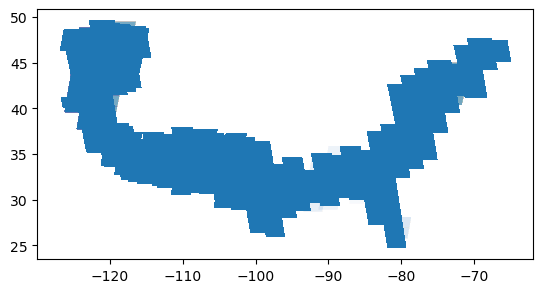

In [23]:
df_ifgs.plot(alpha=.01)

## Total IFGs

In [25]:
df_ifgs.shape

(149448, 6)

## Distribution of Temporal Baselines

In [42]:
xx = (df_ifgs.reference_date).map(pd.Timestamp) - (df_ifgs.secondary_date).map(pd.Timestamp)

In [43]:
yy = xx.dt.total_seconds() / (60 * 60 * 24)

Text(0.5, 0, 'Temporal Baseline (days)')

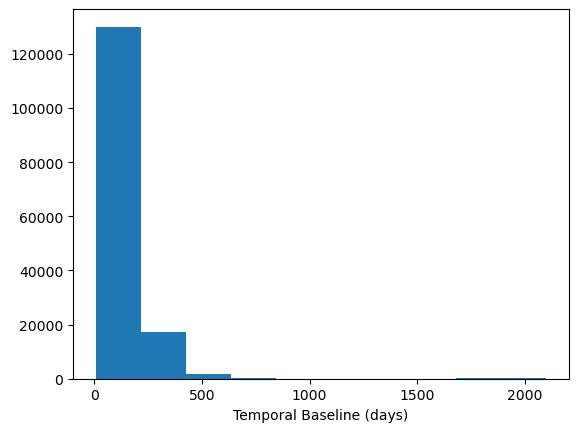

In [44]:
plt.hist(yy)
plt.xlabel('Temporal Baseline (days)')